In [1]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import swifter
from tqdm import tqdm
import gc
pd.options.display.max_columns = None



In [2]:
def preprocessing_LETU(df):
    Y_var = df[['target','treat']]
    X_var = df.drop(['target','treat'], axis = 1)
    dataset = pd.DataFrame()
    cat_vars = ['lftm_type','SEGMENT_N'
                ,	'SUB_EMAIL'
                , 'Тип карты'	
                , 'Канал регистрации'
                , 'NewComer'] 
    ## Categorical to Vec
    dataset = pd.concat([dataset
                    , pd.get_dummies(X_var[cat_vars]
                                    )
                    ], axis = 1)
    X_var = X_var.drop(cat_vars, axis =1)                    
    # dataset.head()

    ## Numeric preprocessing
    med = X_var['AGE'].median()
    dataset = pd.concat([dataset
                        , X_var['AGE'].apply(lambda x: x if((x >= 16) and (x <= 90)) else med).fillna(med)
                        ], axis=1)
    X_var = X_var.drop(['AGE'], axis =1)                     
    
    for_norm = ['last_order_days',	'AMOUNT'
            ,	'ORDERS'
            ,	'AOV'	
            ,'LTV_1M'
            , 'AO_per_month'
            , 'GET_Bonus'
            ,	'USE_Bonus'
            ,	'NON_SPEND_BONUS'
            ,	'BASE_GET_Bonus'
            ,	'BASE_USE_Bonus'
            ,	'Express_GET_Bonus'
            ,	'Express_USE_Bonus'
            ,	'Camp_GET_Bonus'
            ,	'REG_GET_Bonus'	
            , 'Camp_BASE_GET_Bonus'
            ,	'REG_BASE_GET_Bonus'
            , 'AVG_USE_BONUS'
            ,	'DISC_AMOUNT'
            ,	'DISC_ORDERS'
            , 'BASE_AVG_USE_BONUS'
            ,	'BASE_DISC_AMOUNT'
            ,	'BASE_DISC_ORDERS'
            , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS'
             ,'min_days_between', 'max_days_between', 'avg_days_between']

    x_means = X_var[for_norm].mean()
    x_std = X_var[for_norm].std()  
    x_v = X_var[for_norm].astype(float).copy() 
    dataset = pd.concat([dataset
                    , (x_v - x_means).fillna(0) / x_std
                    ], axis = 1)
    X_var = X_var.drop(for_norm, axis =1)      

    dataset = pd.concat([dataset
                    , X_var.fillna(0)] , axis = 1)
    del X_var   
    gc.collect()
    return dataset, Y_var  



In [3]:
def preprocessing_LETU_without_norm(df):
        Y_var = df[['target','treat']]
        X_var = df.drop(['target','treat'], axis = 1)
        dataset = pd.DataFrame()
        cat_vars = ['lftm_type','SEGMENT_N'
                        ,	'SUB_EMAIL'
                        , 'Тип карты'	
                        , 'Канал регистрации'
                        , 'NewComer'] 
        ## Categorical to Vec
        dataset = pd.concat([dataset
                        , pd.get_dummies(X_var[cat_vars])
                        ], axis = 1)
        X_var = X_var.drop(cat_vars, axis =1)                    
        # dataset.head()

        ## Numeric preprocessing
        med = X_var['AGE'].median()
        dataset = pd.concat([dataset
                                , X_var['AGE'].apply(lambda x: x if((x >= 16) and (x <= 90)) else med).fillna(med)
                                ], axis=1)
        X_var = X_var.drop(['AGE'], axis =1)                     

        for_norm = ['last_order_days',	'AMOUNT'
                ,	'ORDERS'
                ,	'AOV'	
                ,'LTV_1M'
                , 'AO_per_month'
                , 'GET_Bonus'
                ,	'USE_Bonus'
                ,	'NON_SPEND_BONUS'
                ,	'BASE_GET_Bonus'
                ,	'BASE_USE_Bonus'
                ,	'Express_GET_Bonus'
                ,	'Express_USE_Bonus'
                ,	'Camp_GET_Bonus'
                ,	'REG_GET_Bonus'	
                , 'Camp_BASE_GET_Bonus'
                ,	'REG_BASE_GET_Bonus'
                , 'AVG_USE_BONUS'
                ,	'DISC_AMOUNT'
                ,	'DISC_ORDERS'
                , 'BASE_AVG_USE_BONUS'
                ,	'BASE_DISC_AMOUNT'
                ,	'BASE_DISC_ORDERS'
                , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS'
                ,'min_days_between', 'max_days_between', 'avg_days_between']

        
        x_v = X_var[for_norm].astype(float).copy() 
        med = x_v.median()
        dataset = pd.concat([dataset
                        , x_v.fillna(med)
                        ], axis = 1)
        X_var = X_var.drop(for_norm, axis =1)      

        med = X_var.median()
        dataset = pd.concat([dataset
                        , X_var.astype(float).fillna(med)] , axis = 1)
        del X_var   
        gc.collect()
        return dataset.astype(float).fillna(pd.NA), Y_var.astype(float)  



# Базовая модель

In [4]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
display(df.head())
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 

SEGMENT_N SUB_EMAIL  target  treat lftm_type  NewComer  \
7701018976         4       Нет       0      1  NewComer         0   
7701018997         1       Нет       0      0  NewComer         0   
7701019567         3        Да       0      1  NewComer         0   
7701019870         3       Нет       0      1  NewComer         0   
7701020445         4        Да       0      0  NewComer         0   

                                   Тип карты Канал регистрации   AGE  AMOUNT  \
7701018976            Без возможности оплаты           Розница   NaN  1597.0   
7701018997            Без возможности оплаты           Розница  55.0   946.0   
7701019567  Как карточное платежное средство             Ecomm  28.0  2753.0   
7701019870            Без возможности оплаты           Розница   NaN  1412.2   
7701020445  Как карточное платежное средство             Ecomm  22.0   183.0   

            ORDERS     AOV  last_order_days  LTV_1M  AO_per_month  GET_Bonus  \
7701018976     1.0  1597.0            109.0  399.25          0.25      516.0   
7701018997     1.0   946.0             35.0  236.50          0.25      310.0   
7701019567     2.0  1376.5             65.0  688.25          0.50     1329.0   
7701019870     1.0  1412.2             73.0  353.05          0.25      516.0   
7701020445     1.0   183.0             36.0   45.75          0.25      802.0   

            USE_Bonus  NON_SPEND_BONUS  BASE_GET_Bonus  BASE_USE_Bonus  \
7701018976        NaN              NaN            16.0             NaN   
7701018997        NaN              NaN            10.0             NaN   
7701019567     1018.0            311.0            29.0            18.0   
7701019870        NaN              NaN            16.0             NaN   
7701020445      182.0            620.0             2.0             NaN   

            Express_GET_Bonus  Express_USE_Bonus  Camp_GET_Bonus  \
7701018976              500.0                NaN             NaN   
7701018997              300.0                NaN             NaN   
7701019567             1300.0             1000.0             NaN   
7701019870              500.0                NaN             NaN   
7701020445              800.0              182.0             NaN   

            REG_GET_Bonus  Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus   AVG_DIS  \
7701018976           16.0                  NaN                16.0       NaN   
7701018997           10.0                  NaN                10.0       NaN   
7701019567           29.0                  NaN                29.0  0.269954   
7701019870           16.0                  NaN                16.0       NaN   
7701020445            2.0                  NaN                 2.0  0.498630   

            AVG_USE_BONUS  DISC_AMOUNT  DISC_ORDERS  BASE_AVG_DIS  \
7701018976            NaN          NaN          NaN           NaN   
7701018997            NaN          NaN          NaN           NaN   
7701019567          509.0       2753.0          2.0      0.017543   
7701019870            NaN          NaN          NaN           NaN   
7701020445          182.0        183.0          1.0           NaN   

            BASE_AVG_USE_BONUS  BASE_DISC_AMOUNT  BASE_DISC_ORDERS  \
7701018976                 NaN               NaN               NaN   
7701018997                 NaN               NaN               NaN   
7701019567                18.0            1008.0               1.0   
7701019870                 NaN               NaN               NaN   
7701020445                 NaN               NaN               NaN   

            Express_AVG_DIS  Express_AVG_USE_BONUS  Express_DISC_AMOUNT  \
7701018976              NaN                    NaN                  NaN   
7701018997              NaN                    NaN                  NaN   
7701019567         0.266453                  500.0               2753.0   
7701019870              NaN                    NaN                  NaN   
7701020445         0.498630                  182.0                183.0   

            

NewComer  lftm_type_NewComer  lftm_type_Regular  SEGMENT_N_1  \
7701018976         0                   1                  0            0   
7701018997         0                   1                  0            1   
7701019567         0                   1                  0            0   
7701019870         0                   1                  0            0   
7701020445         0                   1                  0            0   

            SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  SEGMENT_N_5  SEGMENT_N_6  \
7701018976            0            0            1            0            0   
7701018997            0            0            0            0            0   
7701019567            0            1            0            0            0   
7701019870            0            1            0            0            0   
7701020445            0            0            1            0            0   

            SEGMENT_N_8  SUB_EMAIL_Да  SUB_EMAIL_Нет  \
7701018976            0             0              1   
7701018997            0             0              1   
7701019567            0             1              0   
7701019870            0             0              1   
7701020445            0             1              0   

            Тип карты_Без возможности оплаты  \
7701018976                                 1   
7701018997                                 1   
7701019567                                 0   
7701019870                                 1   
7701020445                                 0   

            Тип карты_Как карточное платежное средство  \
7701018976                                           0   
7701018997                                           0   
7701019567                                           1   
7701019870                                           0   
7701020445                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7701018976                        0                          1  36.0   
7701018997                        0                          1  55.0   
7701019567                        1                          0  28.0   
7701019870                        0                          1  36.0   
7701020445                        1                          0  22.0   

            last_order_days    AMOUNT    ORDERS       AOV    LTV_1M  \
7701018976         2.042661 -0.394610 -0.326186 -0.308688 -0.394610   
7701018997        -0.381745 -0.507723 -0.326186 -0.516129 -0.507723   
7701019567         0.601122 -0.193753  0.359438 -0.378950 -0.193753   
7701019870         0.863220 -0.426720 -0.326186 -0.367575 -0.426720   
7701020445        -0.348983 -0.640295 -0.326186 -0.759258 -0.640295   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7701018976     -0.326186  -0.382164   0.000000         0.000000   
7701018997     -0.326186  -0.974353   0.000000         0.000000   
7701019567      0.359438   1.954967   1.881439        -0.028650   
7701019870     -0.326186  -0.382164   0.000000         0.000000   
7701020445     -0.326186   0.440000  -0.945282         1.055797   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7701018976       -0.300324        0.000000          -0.327790   
7701018997       -0.352820        0.000000          -0.945474   
7701019567       -0.186582       -0.357901           2.142946   
7701019870       -0.300324        0.000000          -0.327790   
7701020445       -0.422816        0.000000           0.598736   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7701018976           0.000000             0.0      -0.411228   
7701018997           0.000000             0.0      -0.514400   
7701019567           2.173032             0.0      -0.187688   
7701019870           0.000000             0.0      -0.411228   
7701020445          -1.077897             0.0      -0.651963   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS

target  treat
7701018976       0      1
7701018997       0      0
7701019567       0      1
7701019870       0      1
7701020445       0      0

WAU = 0.009046823393600252; UpLift at 30% 0.010006735789249765


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


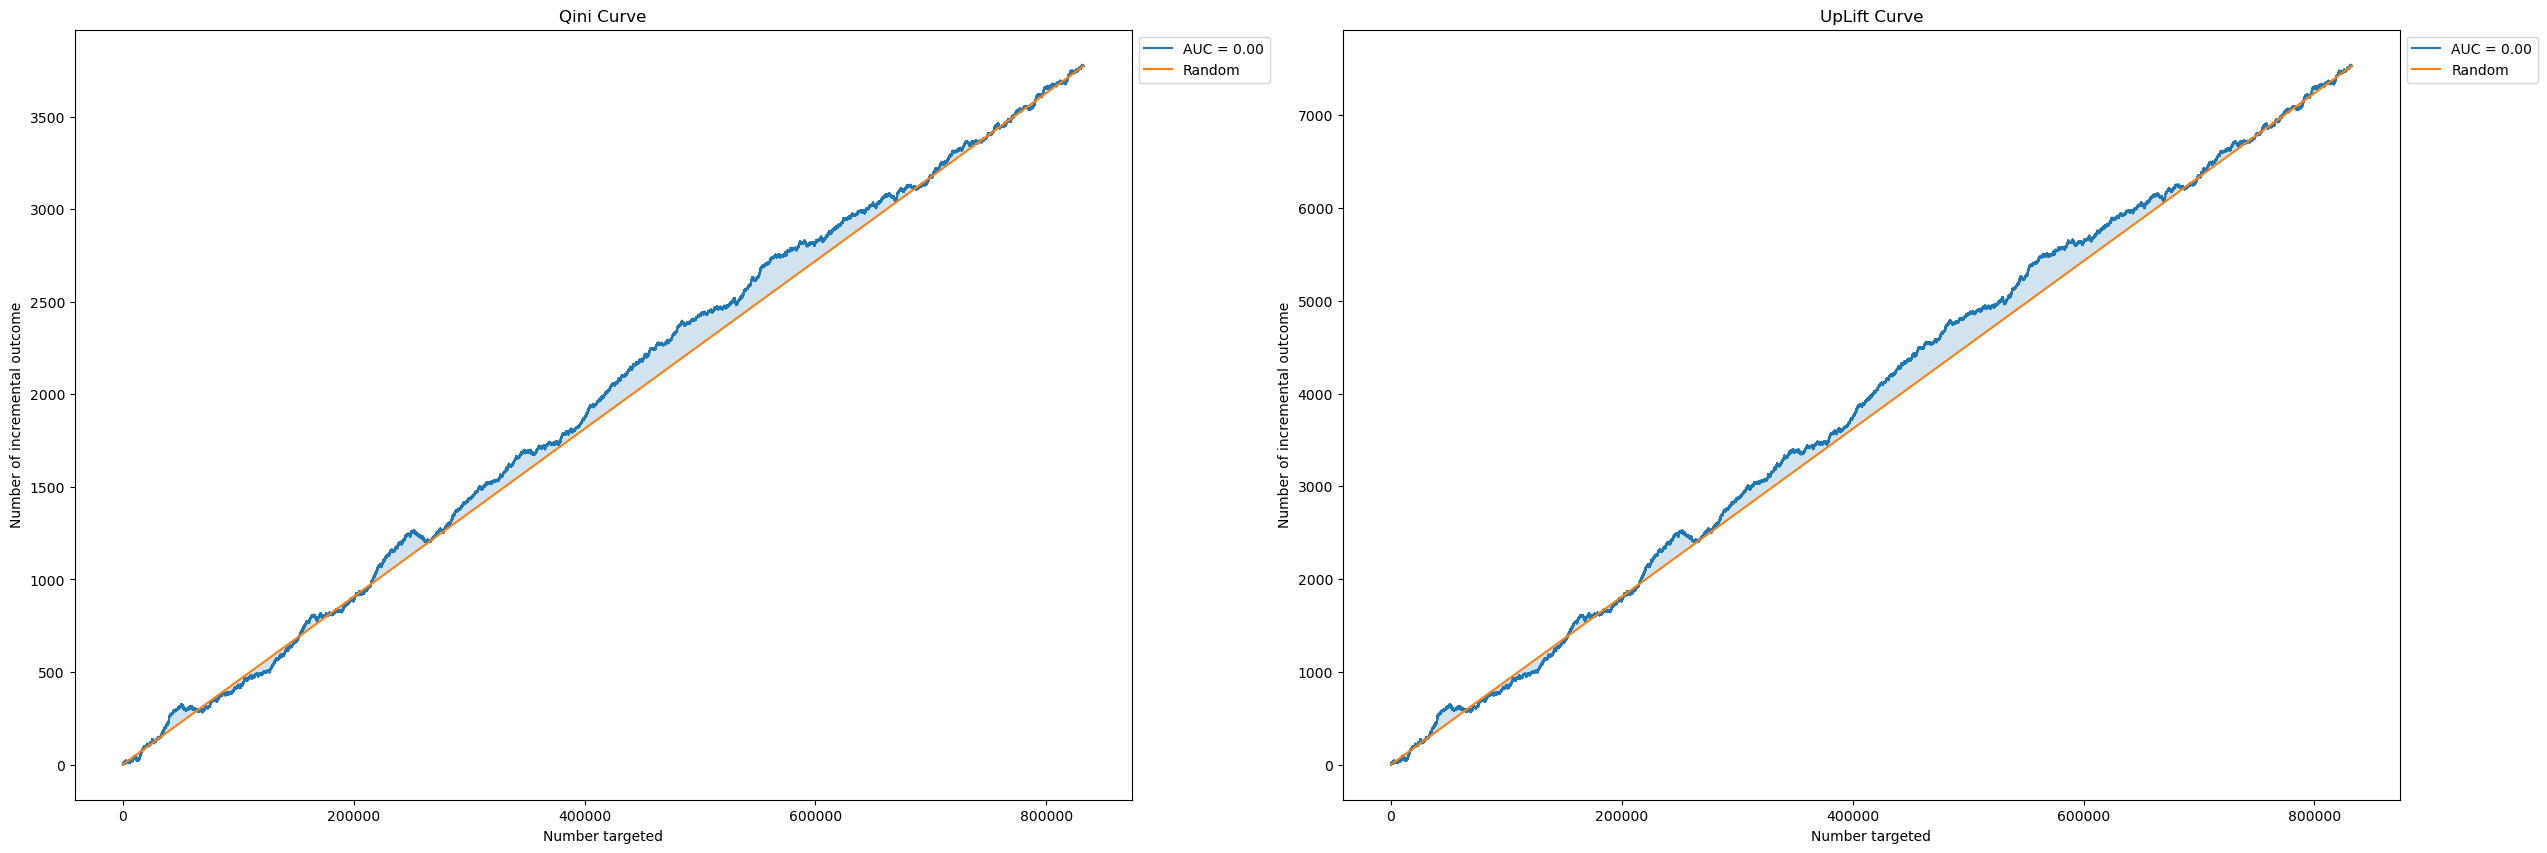

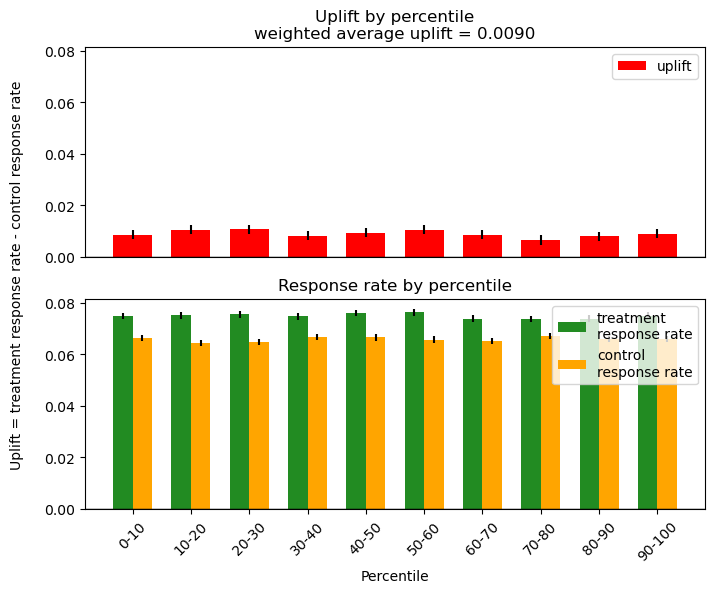

In [5]:
treat = Y_data.treat.values
y = Y_data.target.values

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


y_pred = np.random.uniform(-1, 1, len(treat)).tolist()
gc.collect()
wau = weighted_average_uplift(y_true=y , uplift=y_pred,
                        treatment=treat)
uplift_overall = uplift_at_k(y_true=y , uplift=y_pred,
                        treatment=treat, strategy='by_group', k=0.3)

print(f'WAU = {wau}; UpLift at 30% {uplift_overall}')
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax[0].set_title('Qini Curve')
ax[1].set_title('UpLift Curve')
plot_qini_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[0], perfect=False)
gc.collect()
plot_uplift_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[1], perfect=False)
gc.collect()
gc.collect()
gc.collect()
plt.savefig(f"Plots/Base model Split.png")

plot_uplift_by_percentile(y_true=y , uplift=y_pred,
                        treatment=treat, kind='bar')
plt.savefig(f"Plots/Base model Procentile.png")






In [6]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

8227

# Метод одной модели

In [7]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
X_data = pd.concat([X_data, Y_data.treat], axis= 1)
treat = Y_data.treat.values
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()

NewComer  lftm_type_NewComer  lftm_type_Regular  SEGMENT_N_1  \
7701018976         0                   1                  0            0   
7701018997         0                   1                  0            1   
7701019567         0                   1                  0            0   
7701019870         0                   1                  0            0   
7701020445         0                   1                  0            0   

            SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  SEGMENT_N_5  SEGMENT_N_6  \
7701018976            0            0            1            0            0   
7701018997            0            0            0            0            0   
7701019567            0            1            0            0            0   
7701019870            0            1            0            0            0   
7701020445            0            0            1            0            0   

            SEGMENT_N_8  SUB_EMAIL_Да  SUB_EMAIL_Нет  \
7701018976            0             0              1   
7701018997            0             0              1   
7701019567            0             1              0   
7701019870            0             0              1   
7701020445            0             1              0   

            Тип карты_Без возможности оплаты  \
7701018976                                 1   
7701018997                                 1   
7701019567                                 0   
7701019870                                 1   
7701020445                                 0   

            Тип карты_Как карточное платежное средство  \
7701018976                                           0   
7701018997                                           0   
7701019567                                           1   
7701019870                                           0   
7701020445                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7701018976                        0                          1  36.0   
7701018997                        0                          1  55.0   
7701019567                        1                          0  28.0   
7701019870                        0                          1  36.0   
7701020445                        1                          0  22.0   

            last_order_days    AMOUNT    ORDERS       AOV    LTV_1M  \
7701018976         2.042661 -0.394610 -0.326186 -0.308688 -0.394610   
7701018997        -0.381745 -0.507723 -0.326186 -0.516129 -0.507723   
7701019567         0.601122 -0.193753  0.359438 -0.378950 -0.193753   
7701019870         0.863220 -0.426720 -0.326186 -0.367575 -0.426720   
7701020445        -0.348983 -0.640295 -0.326186 -0.759258 -0.640295   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7701018976     -0.326186  -0.382164   0.000000         0.000000   
7701018997     -0.326186  -0.974353   0.000000         0.000000   
7701019567      0.359438   1.954967   1.881439        -0.028650   
7701019870     -0.326186  -0.382164   0.000000         0.000000   
7701020445     -0.326186   0.440000  -0.945282         1.055797   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7701018976       -0.300324        0.000000          -0.327790   
7701018997       -0.352820        0.000000          -0.945474   
7701019567       -0.186582       -0.357901           2.142946   
7701019870       -0.300324        0.000000          -0.327790   
7701020445       -0.422816        0.000000           0.598736   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7701018976           0.000000             0.0      -0.411228   
7701018997           0.000000             0.0      -0.514400   
7701019567           2.173032             0.0      -0.187688   
7701019870           0.000000             0.0      -0.411228   
7701020445          -1.077897             0.0      -0.651963   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS

target  treat
7701018976       0      1
7701018997       0      0
7701019567       0      1
7701019870       0      1
7701020445       0      0

0

In [8]:
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt



Split 1; WAU = 0.007760023388518952; UpLift at 30% 0.012357429316954827


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.008837966395489097; UpLift at 30% 0.015702691704640184


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.00892071062573076; UpLift at 30% 0.01673661797547947


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.00671579439698497; UpLift at 30% 0.013490034275764895


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.010923554796041799; UpLift at 30% 0.020060343209183762


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0086; Mean UpLift 30% = 0.0157


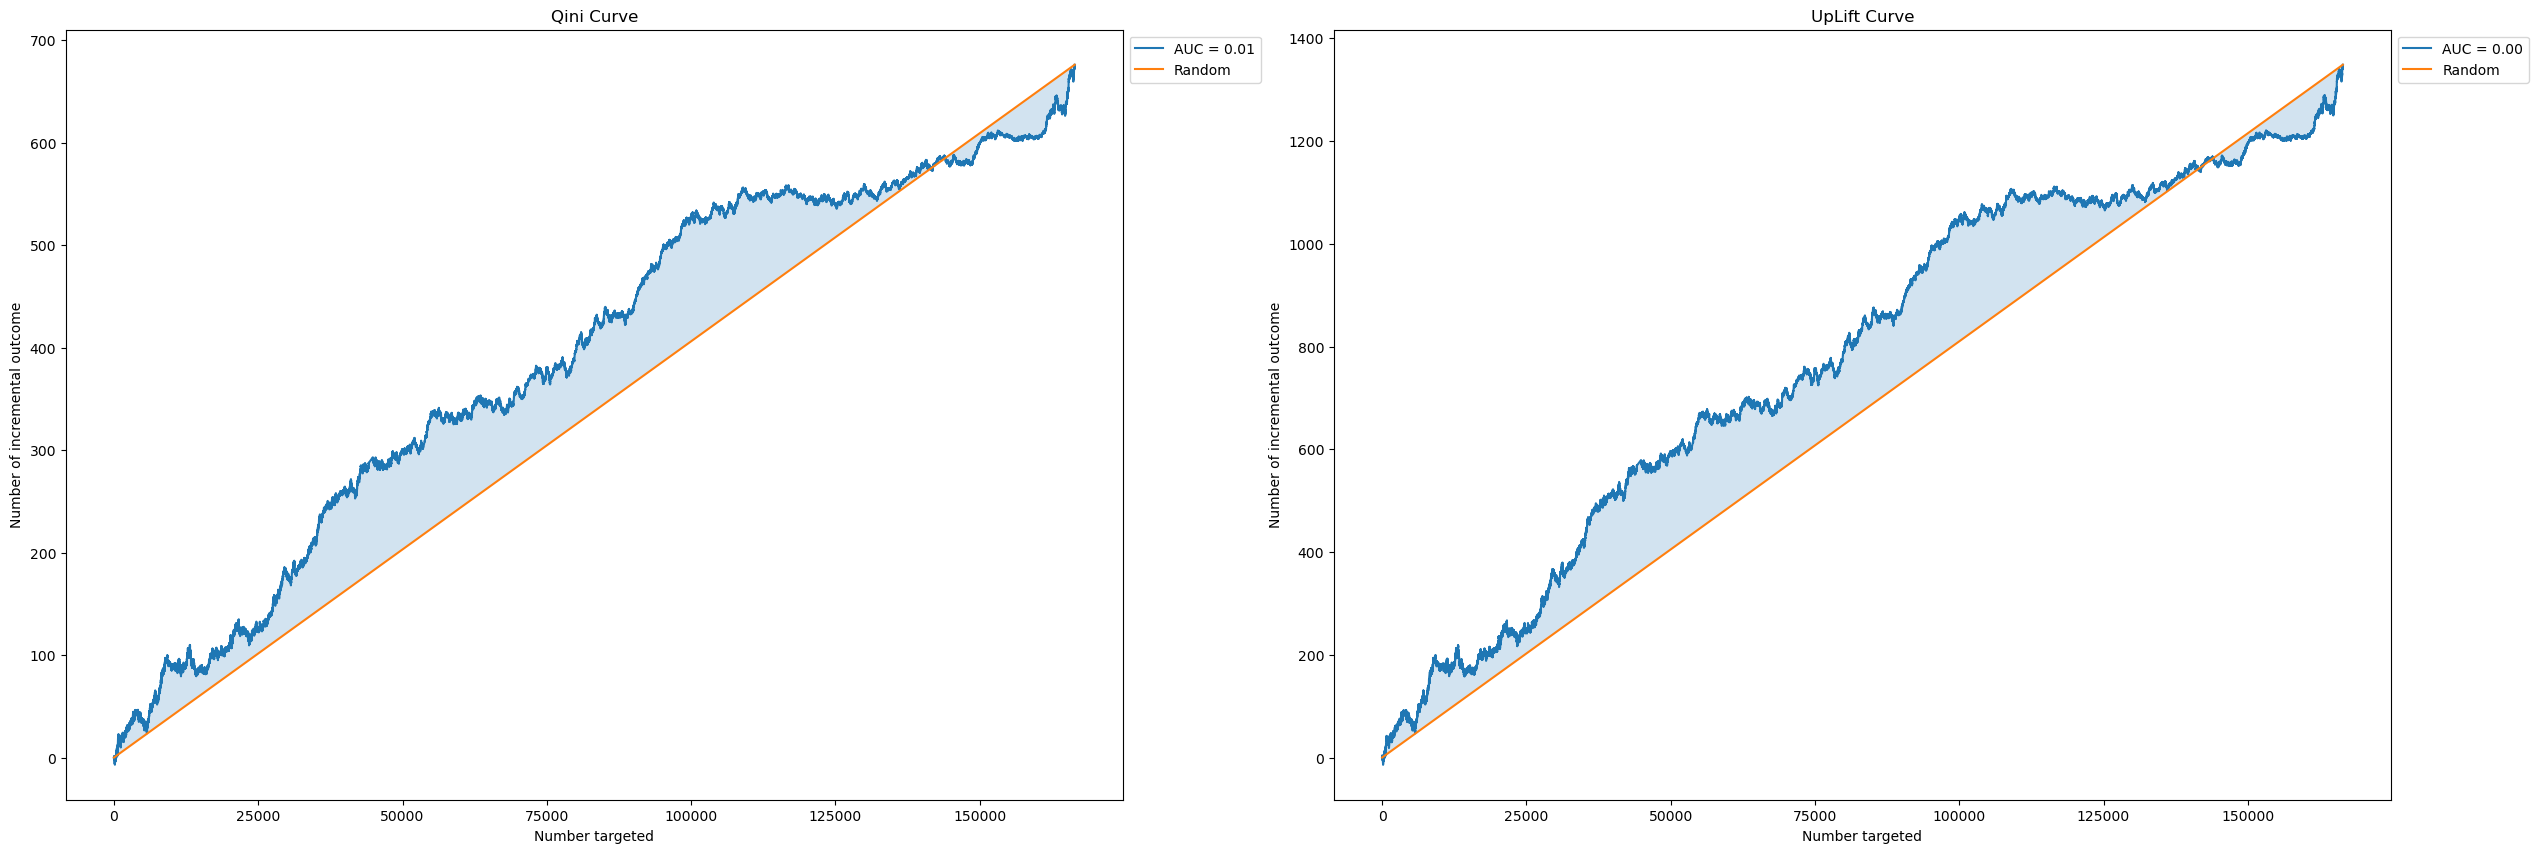

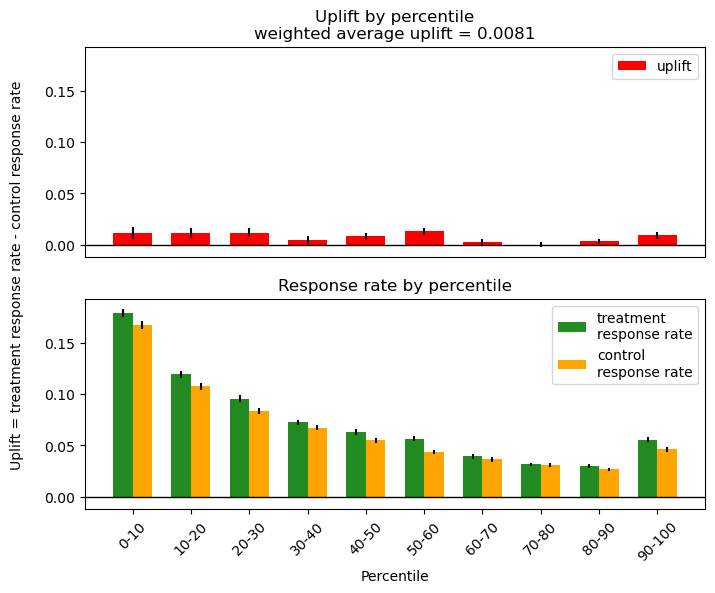

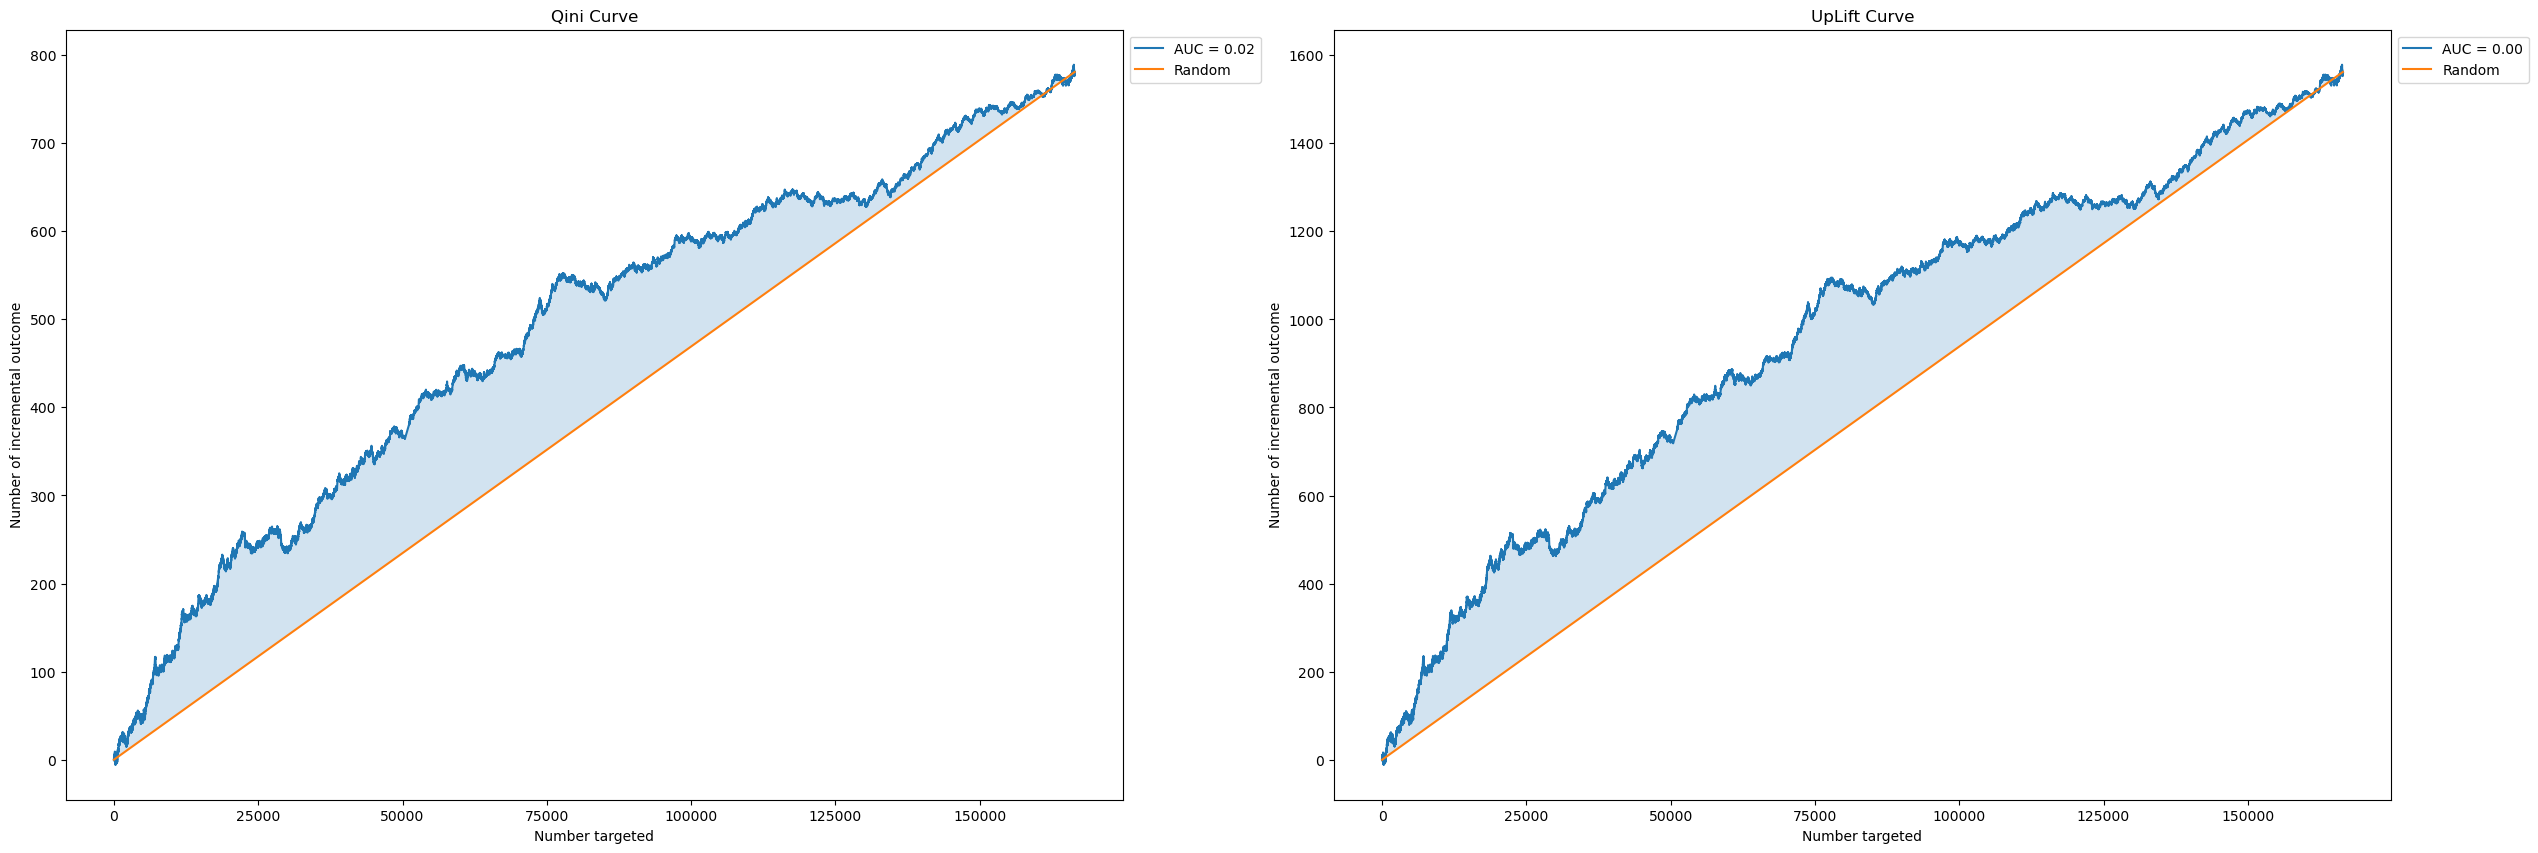

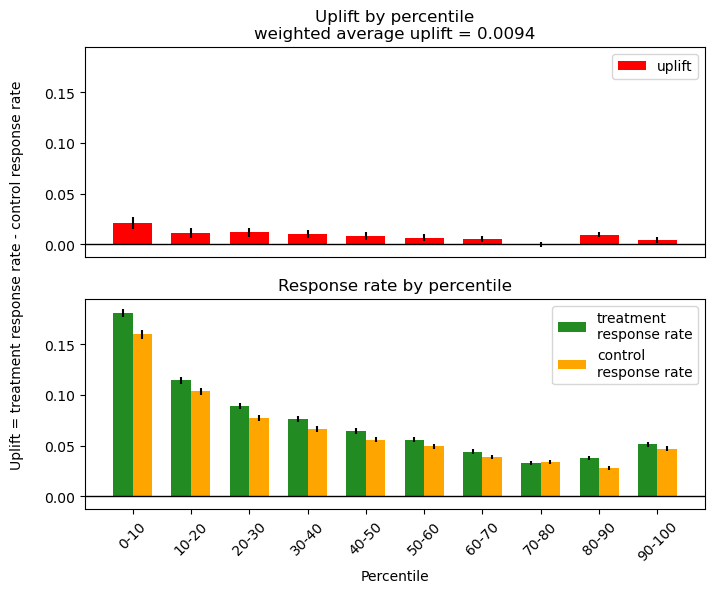

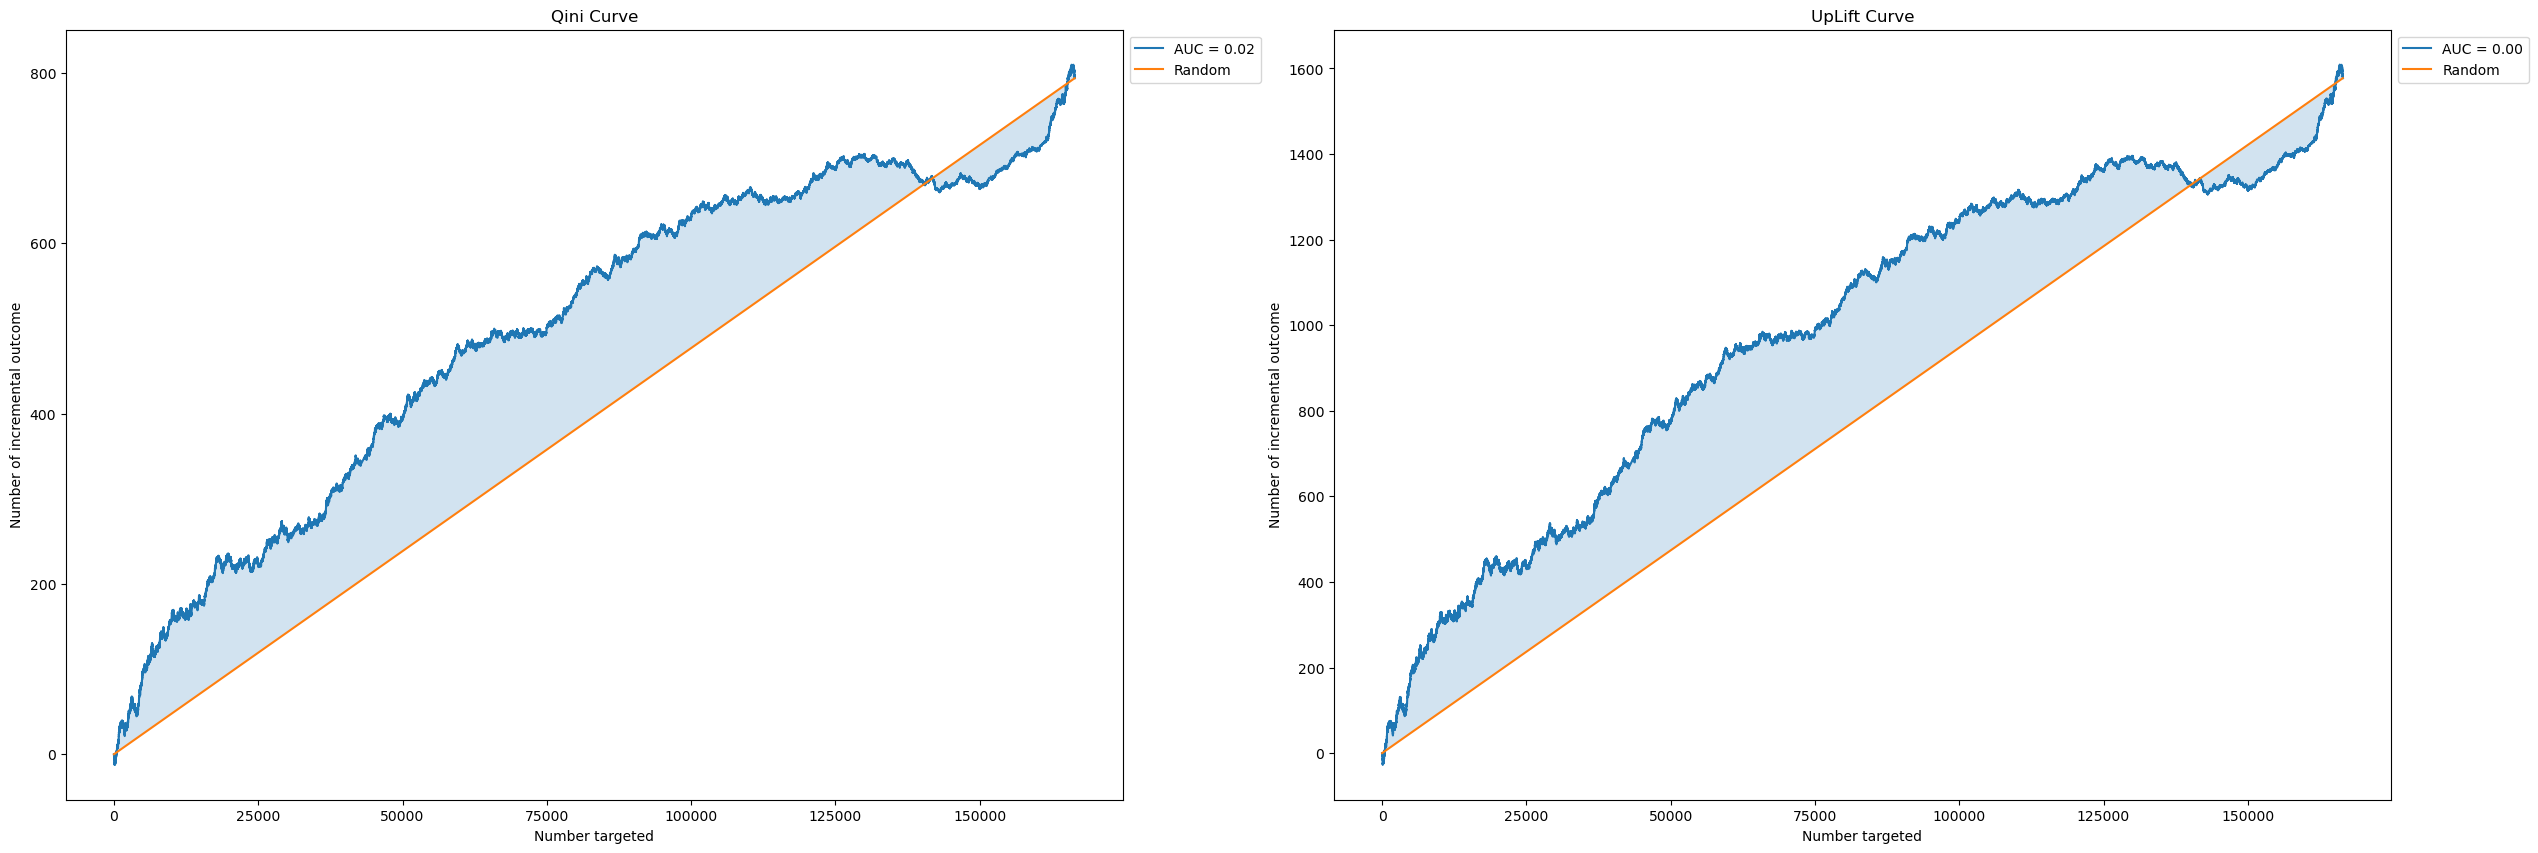

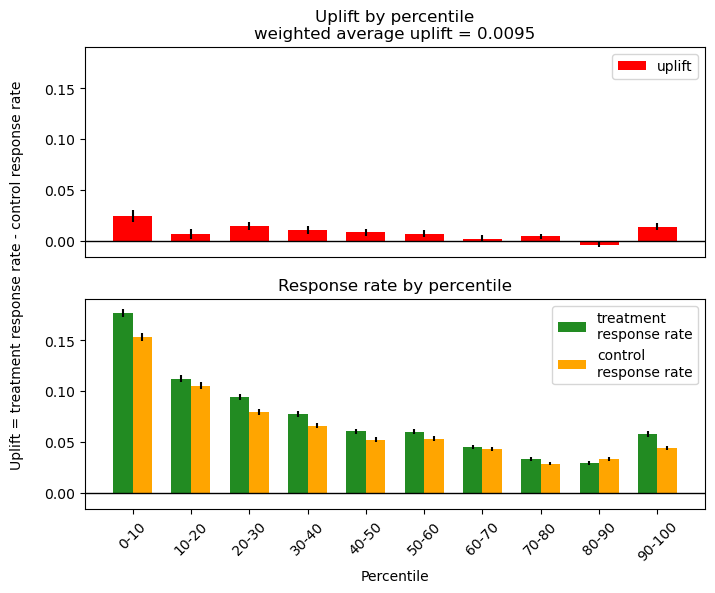

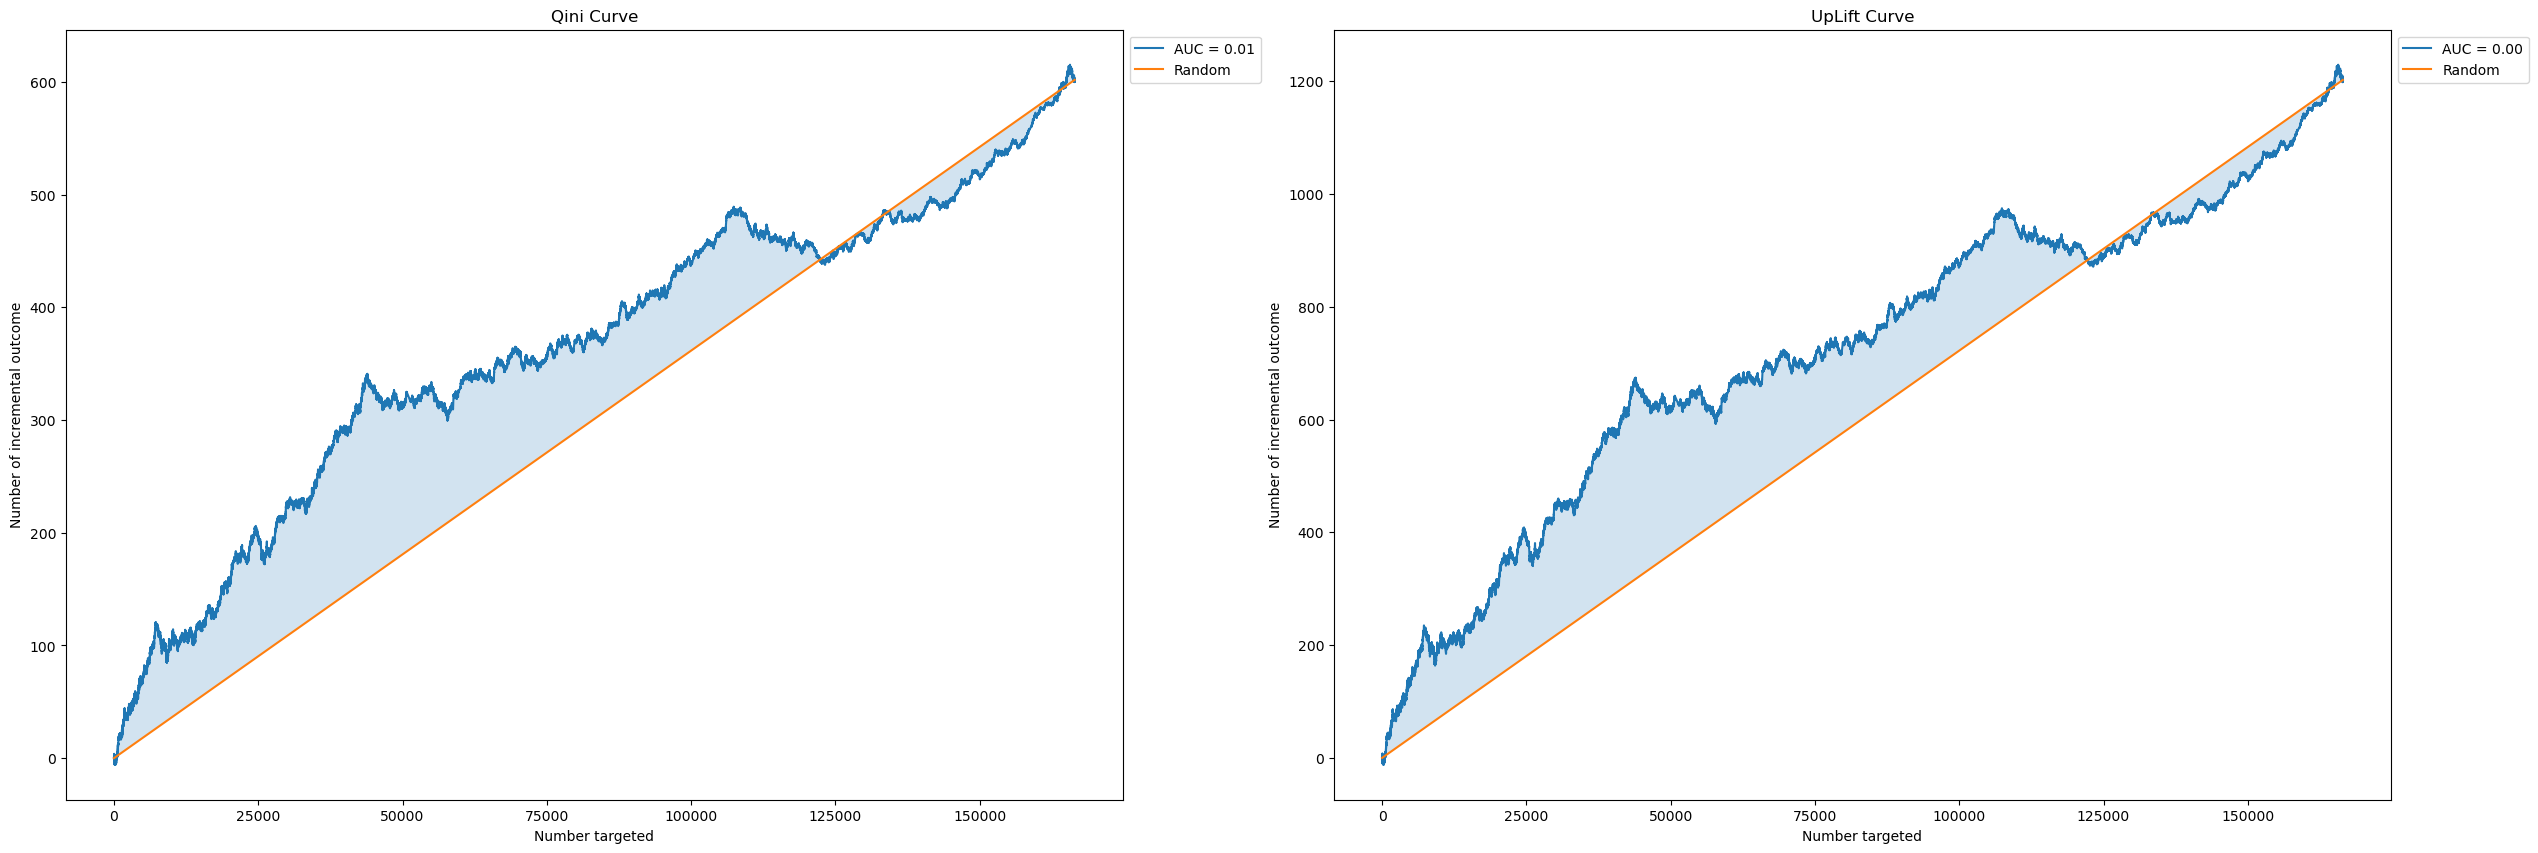

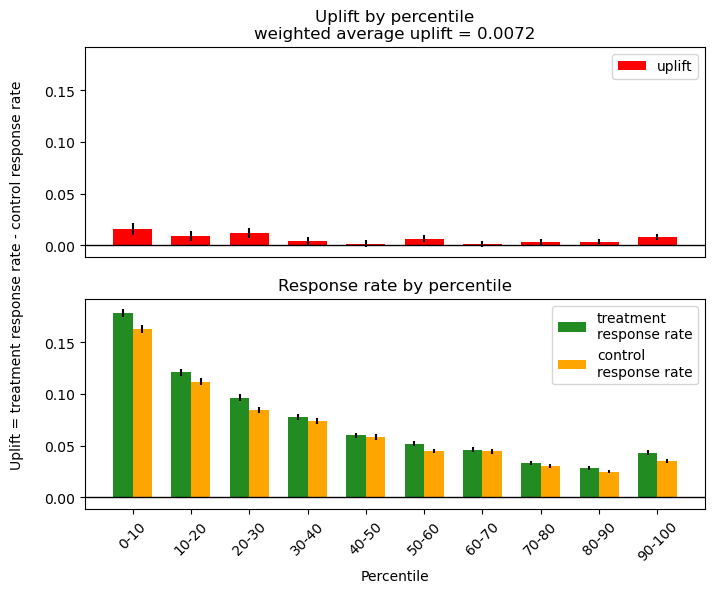

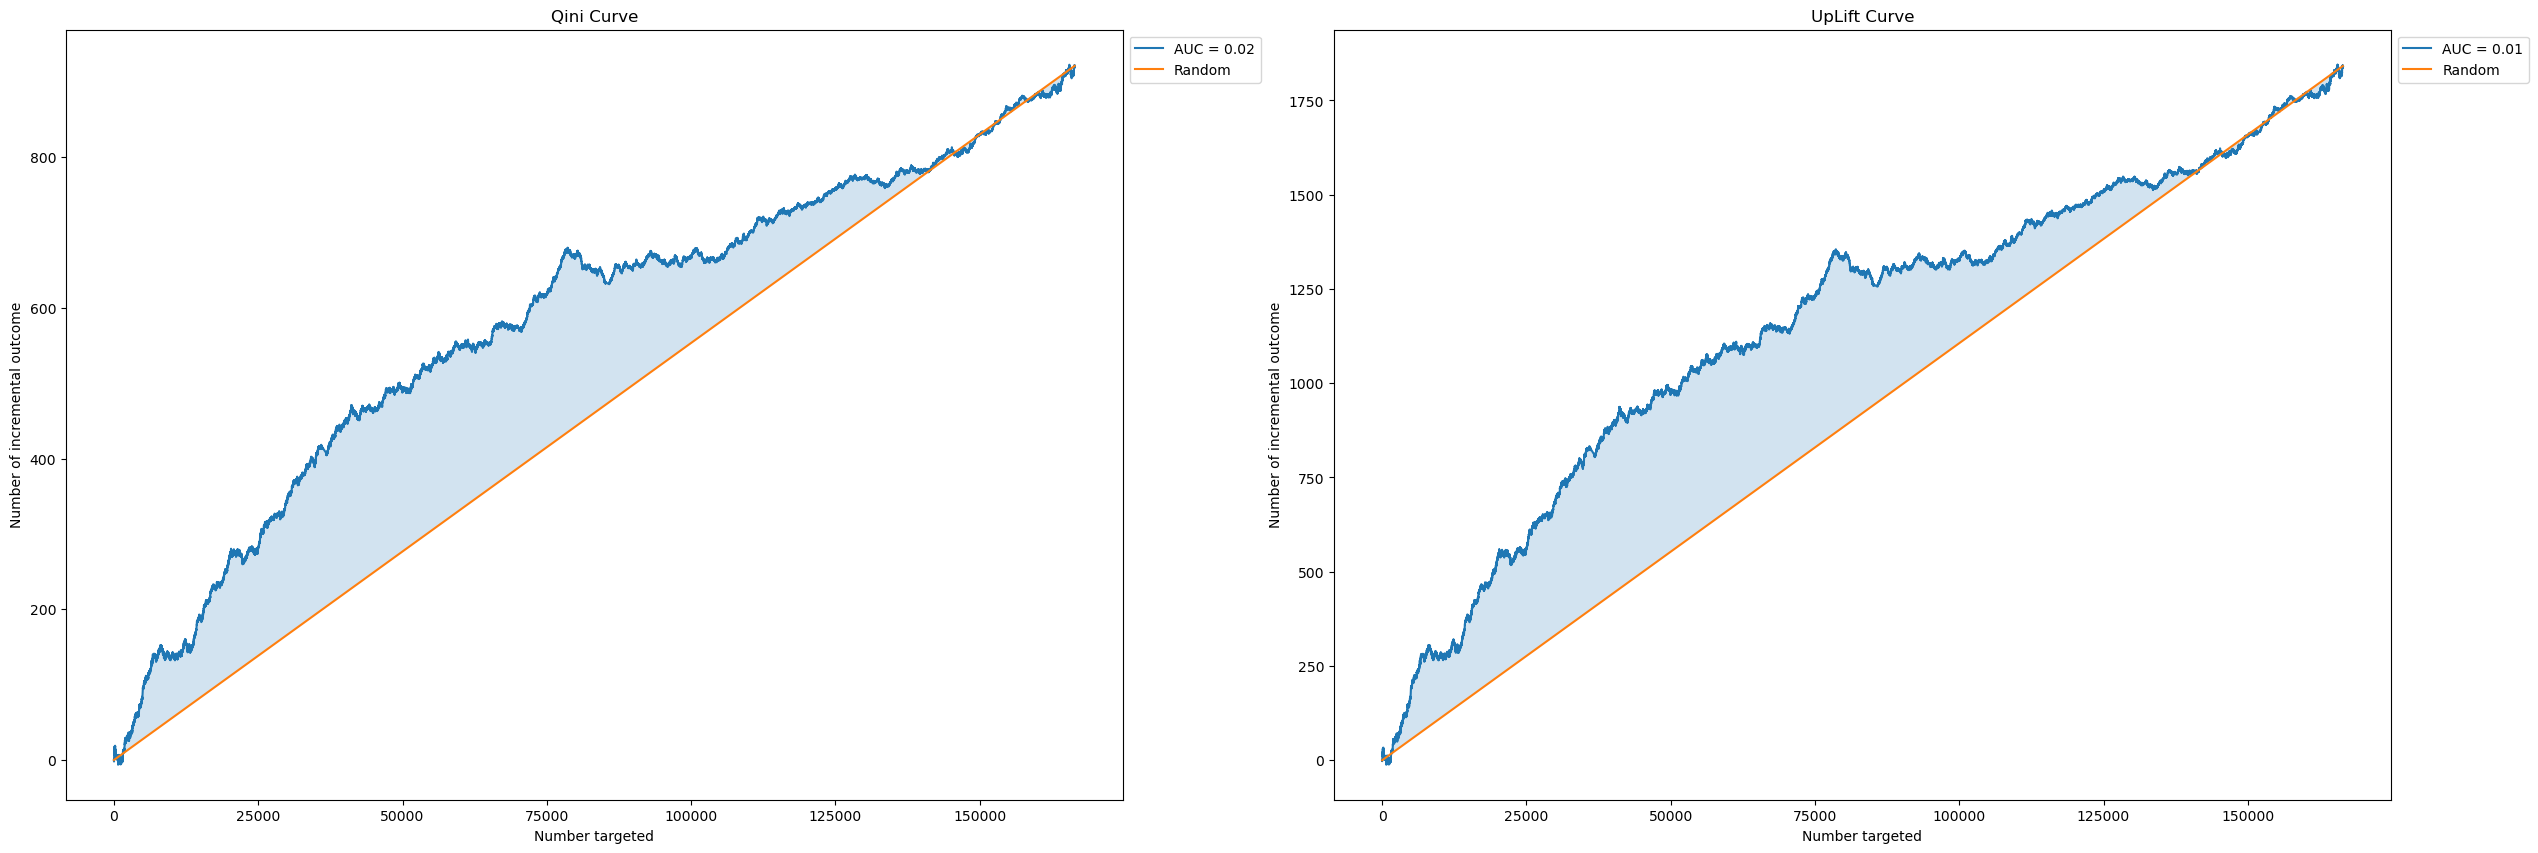

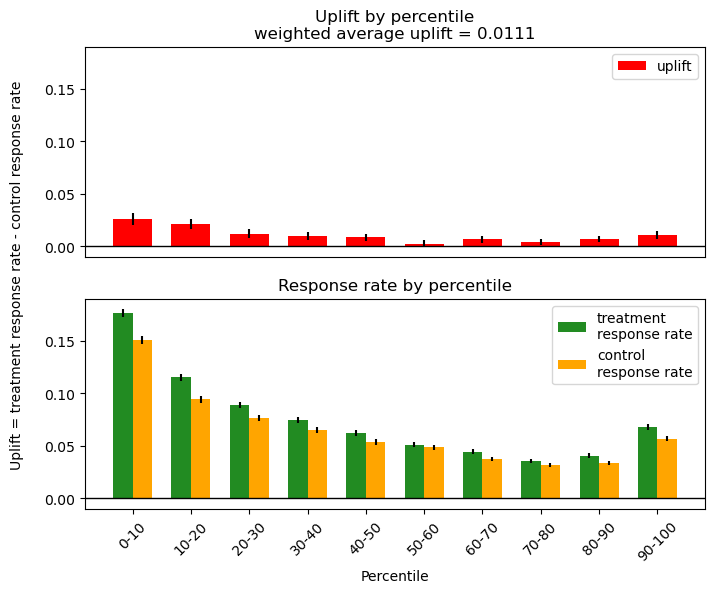

In [9]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      clf = CatBoostClassifier(verbose = 0)
      clf.fit(X_train_, y_train_)
      X_test_[:, -1] = 1#np.ones(len(test_index))
      y_pred1 = clf.predict_proba(X_test_).T[1]
      X_test_[:, -1] = 0#np.ones(len(test_index))
      y_pred0 = clf.predict_proba(X_test_).T[1]
      y_pred = y_pred1 - y_pred0
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/One model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/One model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

In [10]:
wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

Mean WAU = 0.0086; Mean UpLift 30% = 0.0157


In [11]:
gc.collect()

69370

In [12]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

0

# Метод двух моделей

In [13]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = Y_data.treat.values
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target.values
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







NewComer  lftm_type_NewComer  lftm_type_Regular  SEGMENT_N_1  \
7701018976         0                   1                  0            0   
7701018997         0                   1                  0            1   
7701019567         0                   1                  0            0   
7701019870         0                   1                  0            0   
7701020445         0                   1                  0            0   

            SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  SEGMENT_N_5  SEGMENT_N_6  \
7701018976            0            0            1            0            0   
7701018997            0            0            0            0            0   
7701019567            0            1            0            0            0   
7701019870            0            1            0            0            0   
7701020445            0            0            1            0            0   

            SEGMENT_N_8  SUB_EMAIL_Да  SUB_EMAIL_Нет  \
7701018976            0             0              1   
7701018997            0             0              1   
7701019567            0             1              0   
7701019870            0             0              1   
7701020445            0             1              0   

            Тип карты_Без возможности оплаты  \
7701018976                                 1   
7701018997                                 1   
7701019567                                 0   
7701019870                                 1   
7701020445                                 0   

            Тип карты_Как карточное платежное средство  \
7701018976                                           0   
7701018997                                           0   
7701019567                                           1   
7701019870                                           0   
7701020445                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7701018976                        0                          1  36.0   
7701018997                        0                          1  55.0   
7701019567                        1                          0  28.0   
7701019870                        0                          1  36.0   
7701020445                        1                          0  22.0   

            last_order_days    AMOUNT    ORDERS       AOV    LTV_1M  \
7701018976         2.042661 -0.394610 -0.326186 -0.308688 -0.394610   
7701018997        -0.381745 -0.507723 -0.326186 -0.516129 -0.507723   
7701019567         0.601122 -0.193753  0.359438 -0.378950 -0.193753   
7701019870         0.863220 -0.426720 -0.326186 -0.367575 -0.426720   
7701020445        -0.348983 -0.640295 -0.326186 -0.759258 -0.640295   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7701018976     -0.326186  -0.382164   0.000000         0.000000   
7701018997     -0.326186  -0.974353   0.000000         0.000000   
7701019567      0.359438   1.954967   1.881439        -0.028650   
7701019870     -0.326186  -0.382164   0.000000         0.000000   
7701020445     -0.326186   0.440000  -0.945282         1.055797   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7701018976       -0.300324        0.000000          -0.327790   
7701018997       -0.352820        0.000000          -0.945474   
7701019567       -0.186582       -0.357901           2.142946   
7701019870       -0.300324        0.000000          -0.327790   
7701020445       -0.422816        0.000000           0.598736   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7701018976           0.000000             0.0      -0.411228   
7701018997           0.000000             0.0      -0.514400   
7701019567           2.173032             0.0      -0.187688   
7701019870           0.000000             0.0      -0.411228   
7701020445          -1.077897             0.0      -0.651963   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS

target  treat
7701018976       0      1
7701018997       0      0
7701019567       0      1
7701019870       0      1
7701020445       0      0

Split 1; WAU = 0.0077363629015524665; UpLift 30% 0.011093809117516507


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.008952520944935878; UpLift 30% 0.011970865081218612


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.009239933934116646; UpLift 30% 0.015999129156634276


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.0069560169670557365; UpLift 30% 0.011844741102982531


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.010954371297369061; UpLift 30% 0.014955362553195836


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0088; Mean UpLift 30% = 0.0132


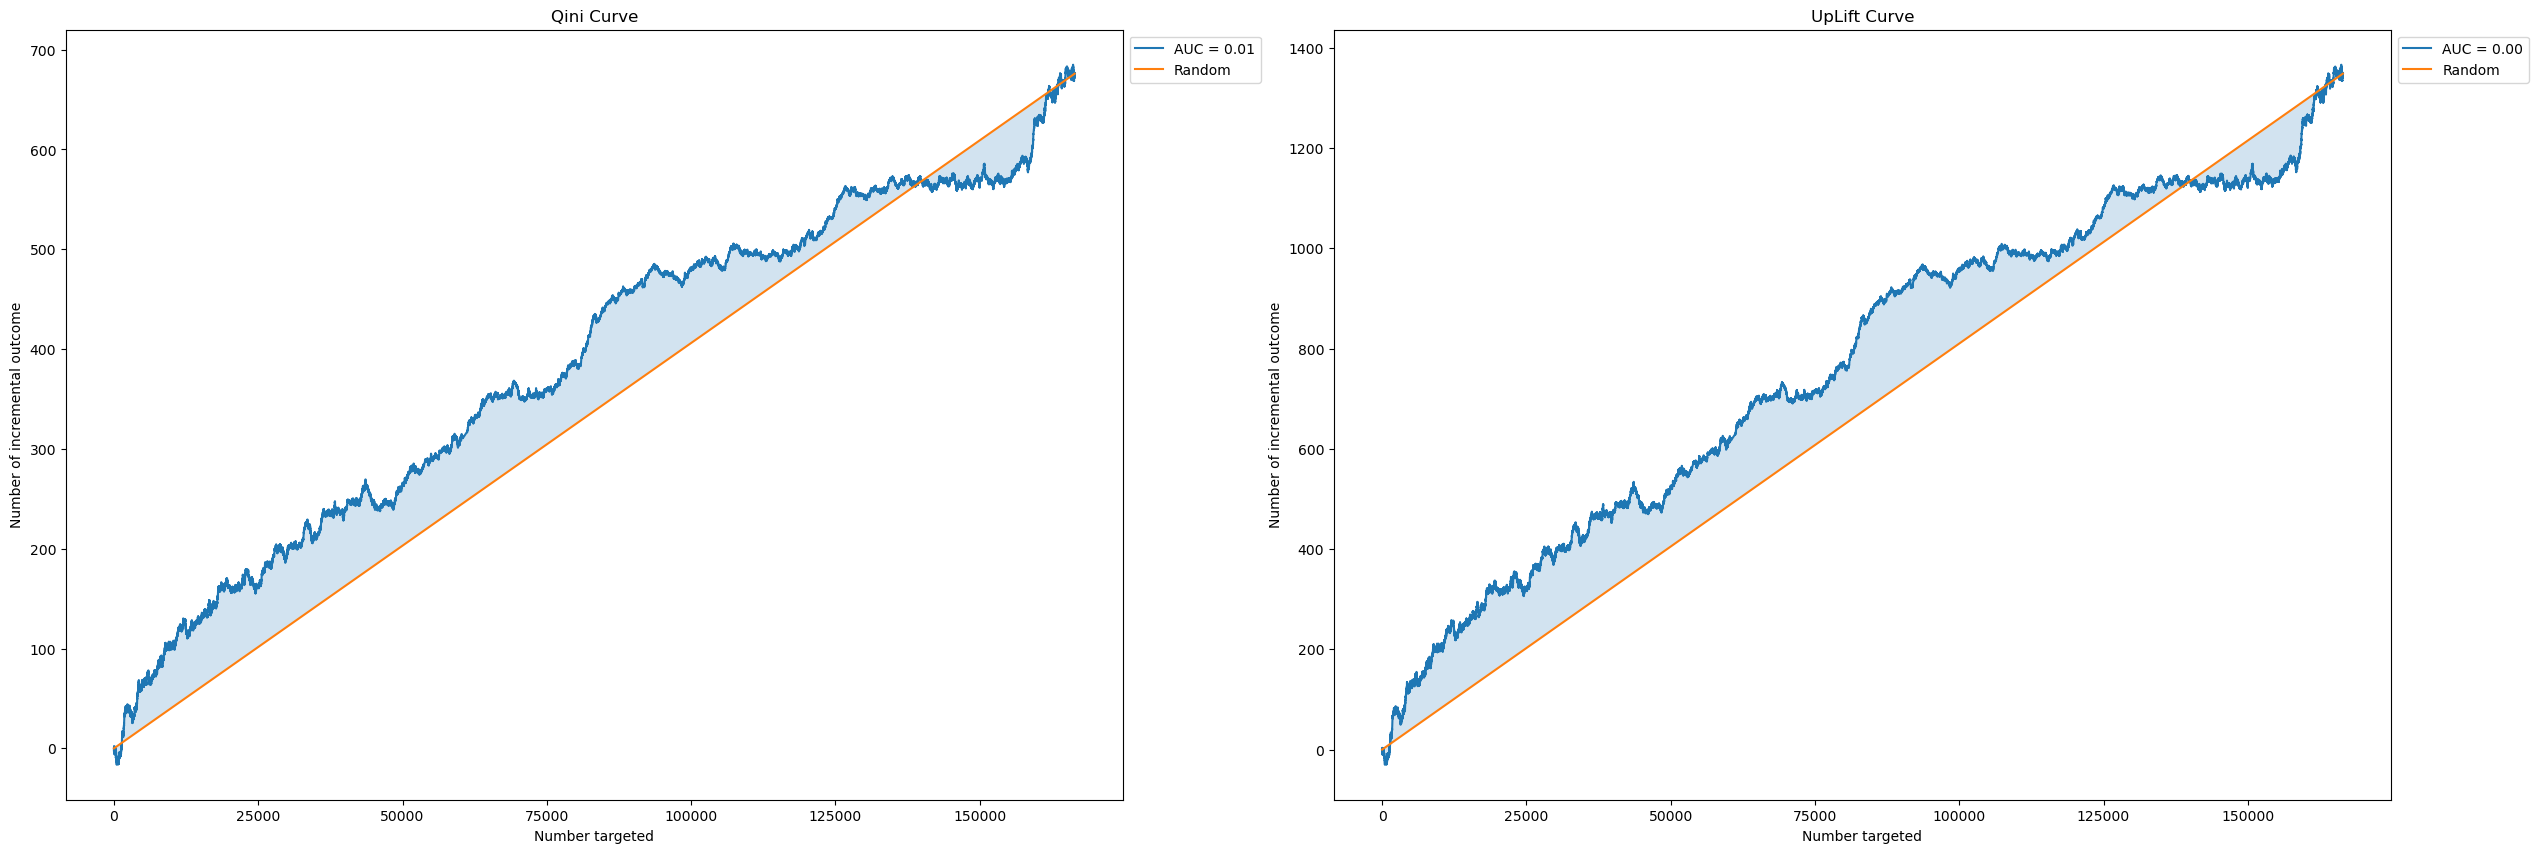

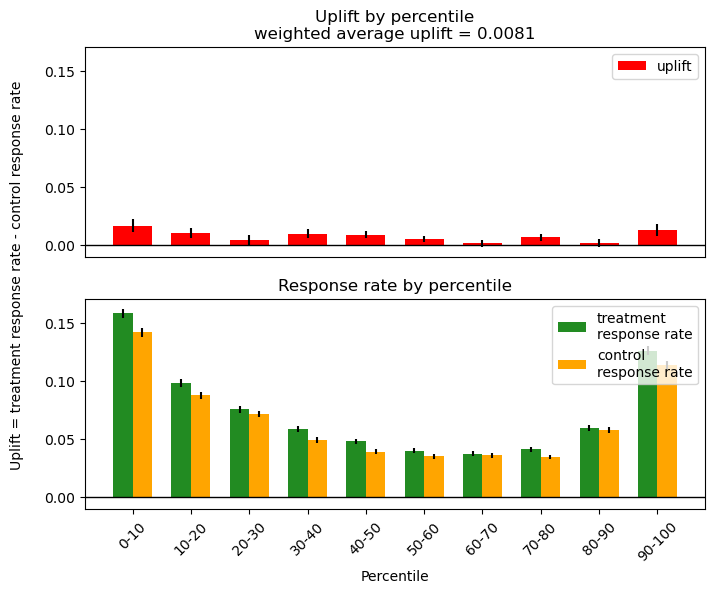

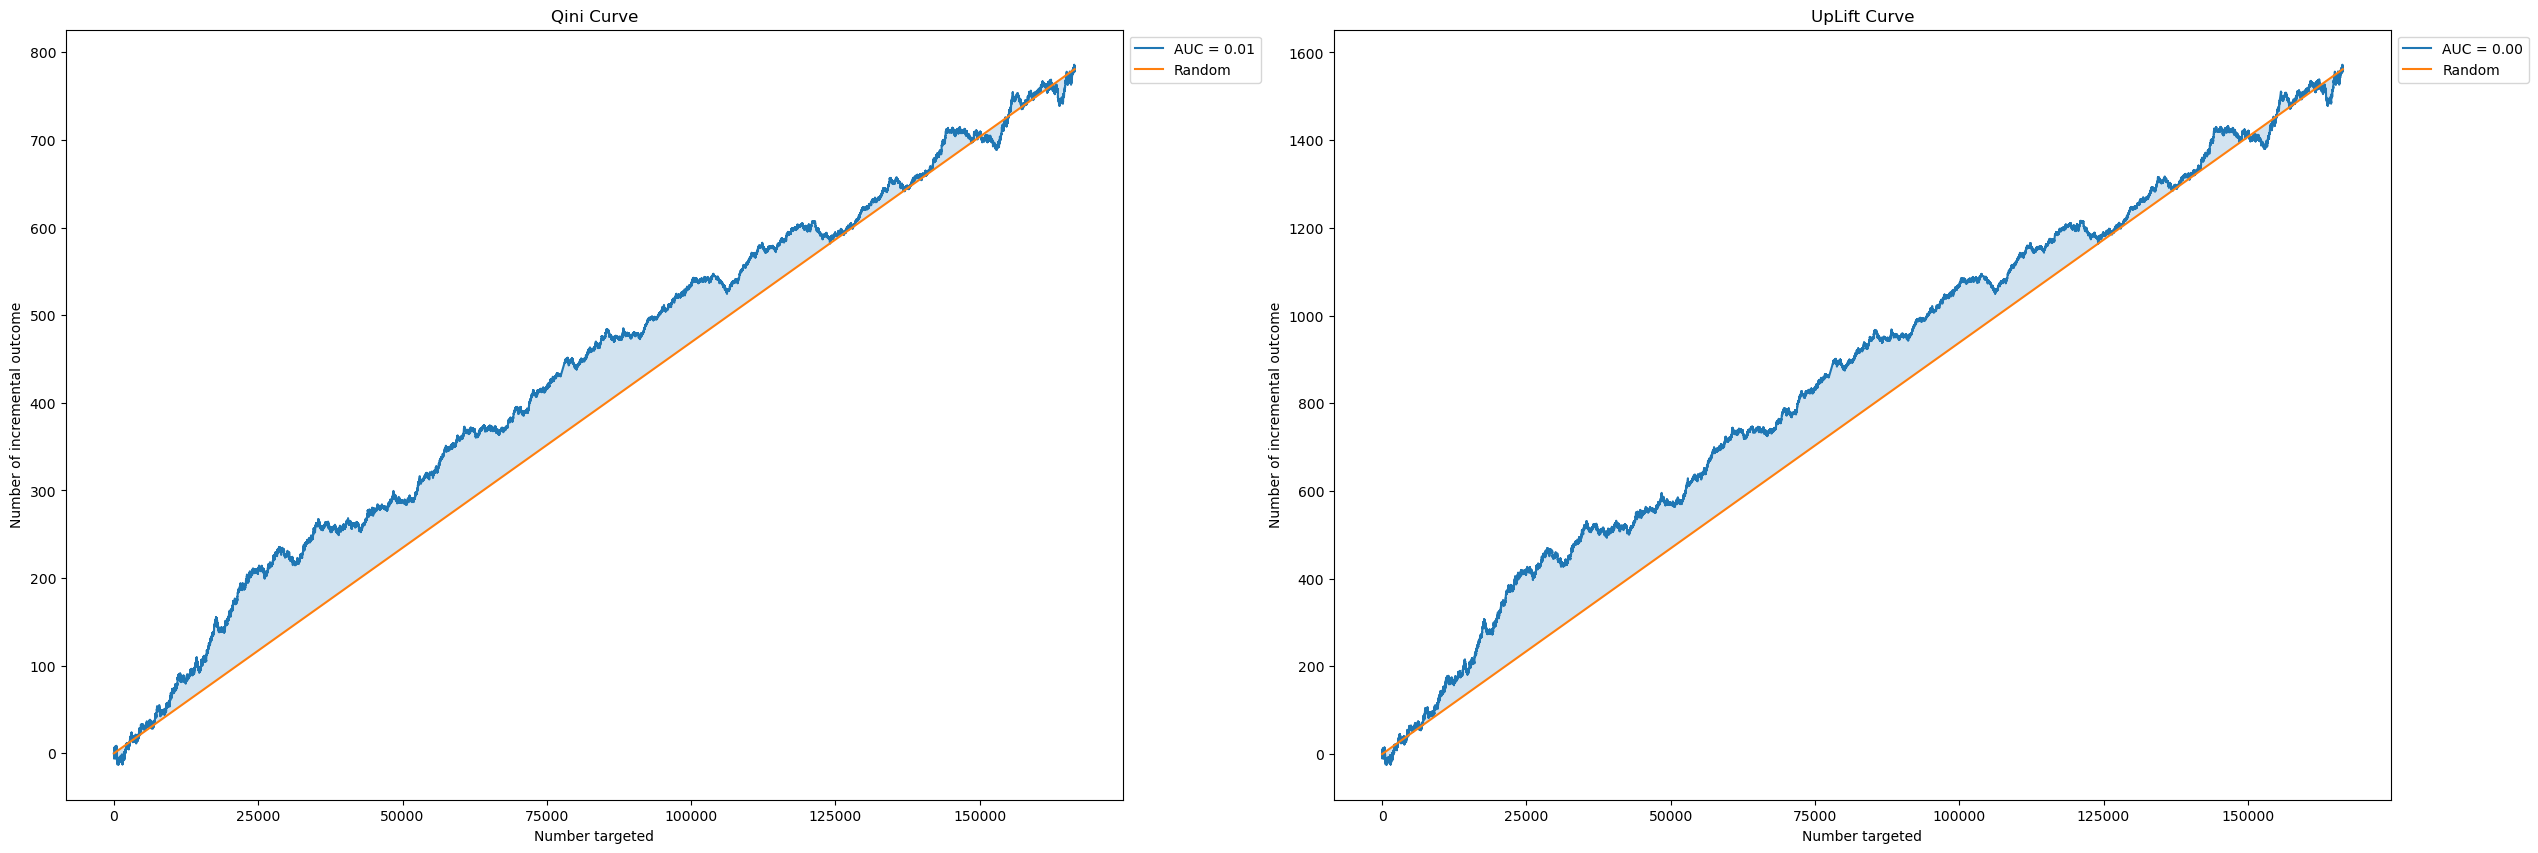

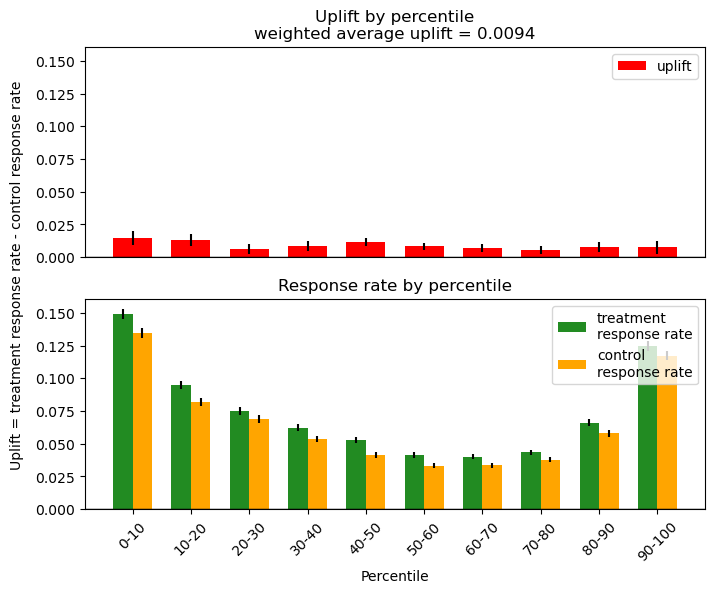

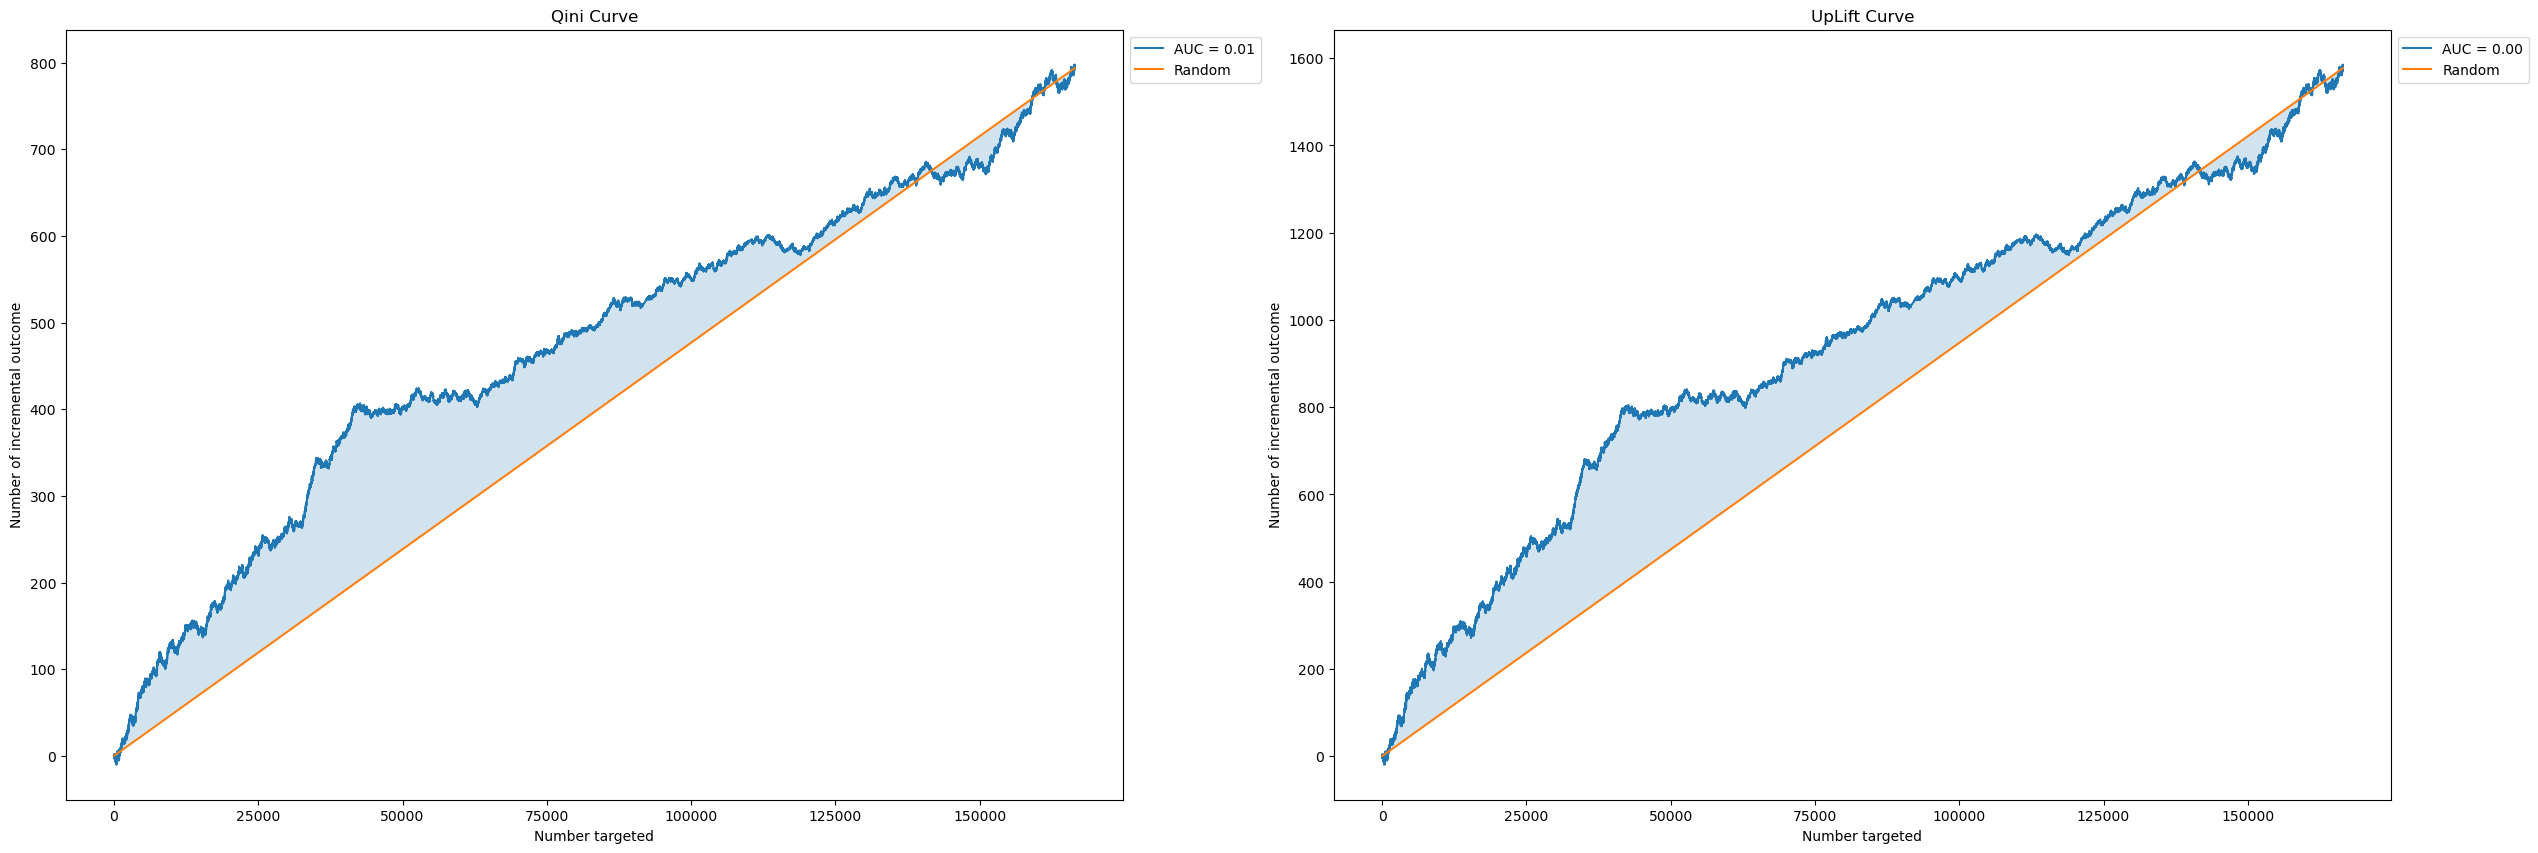

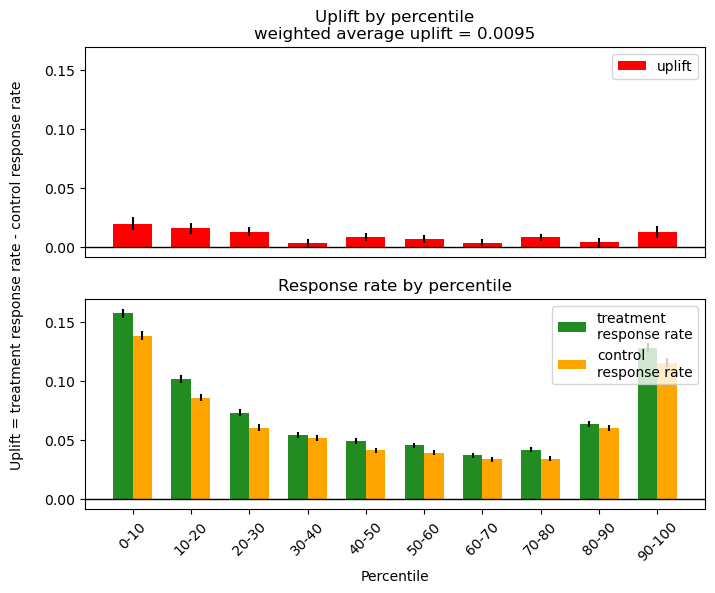

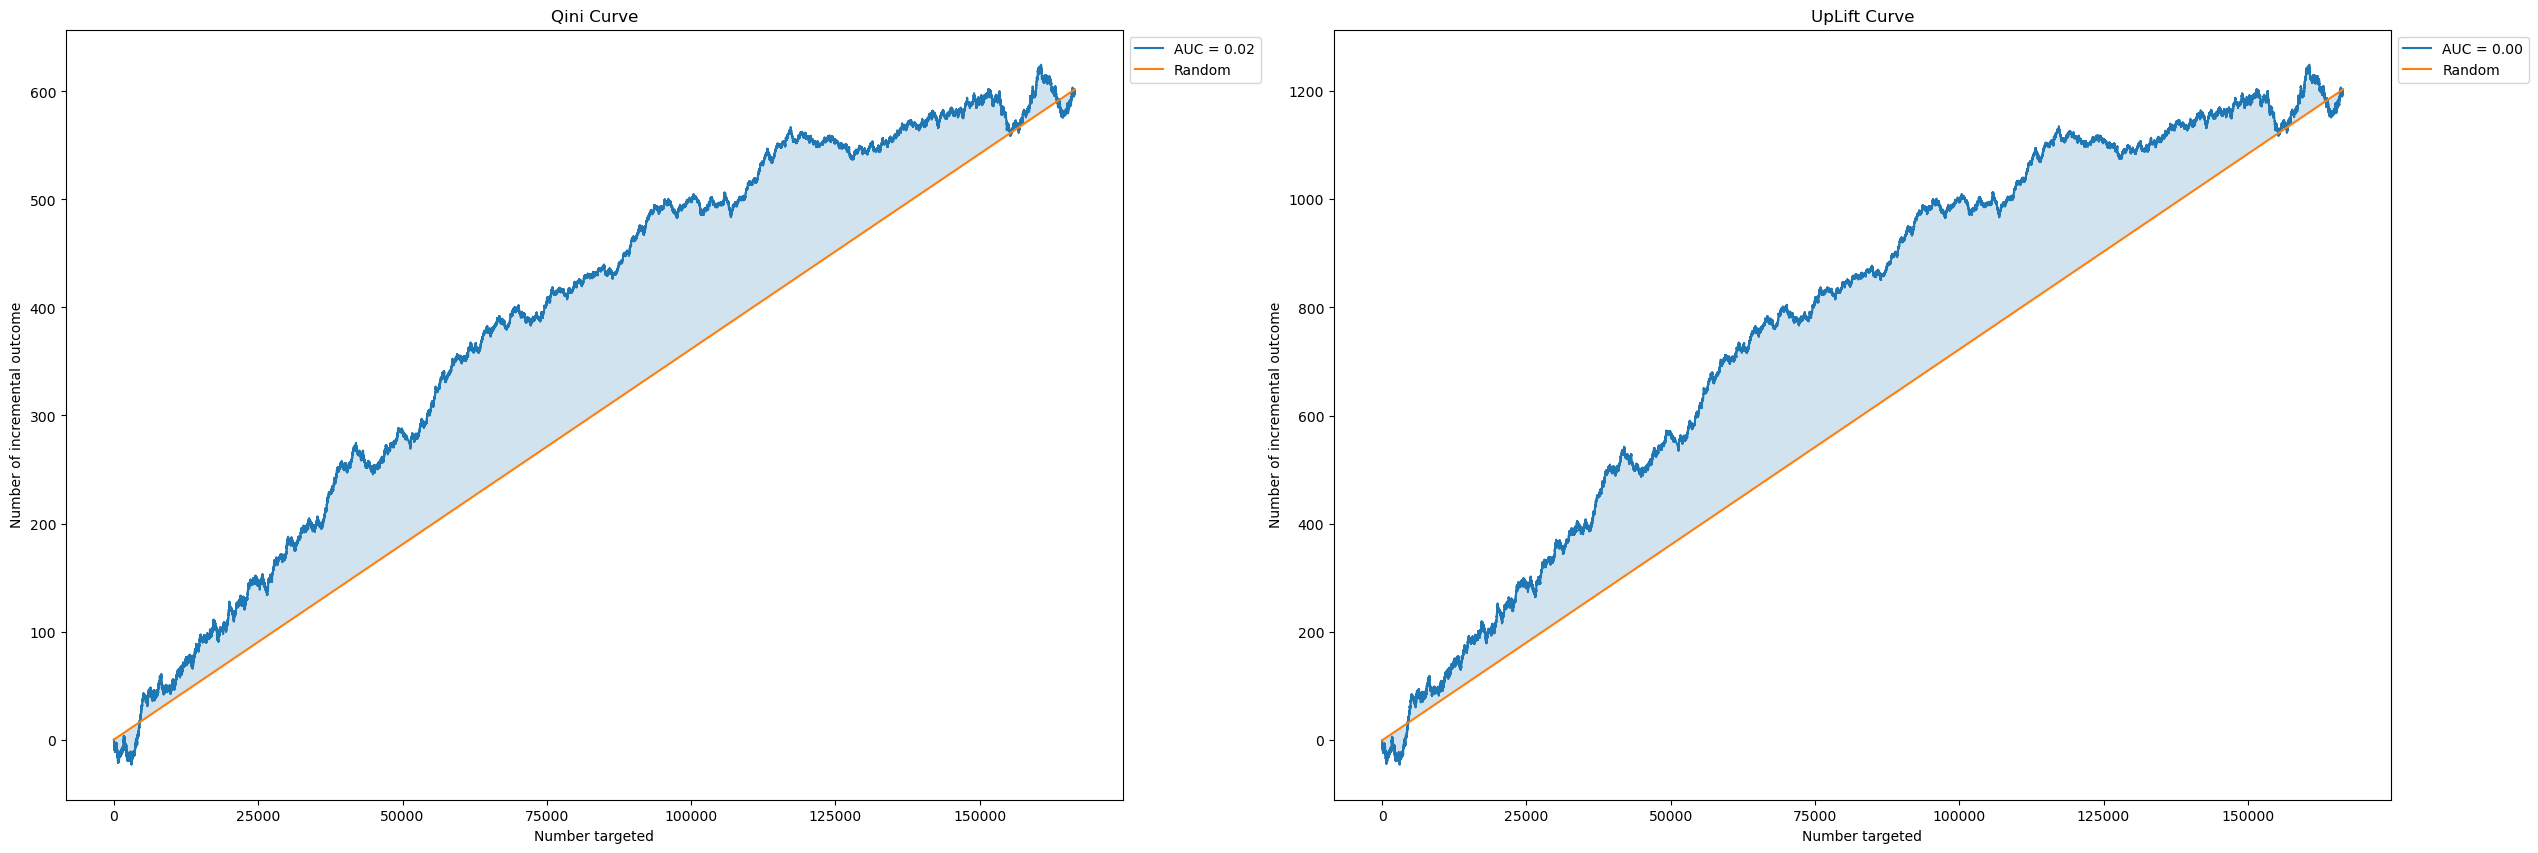

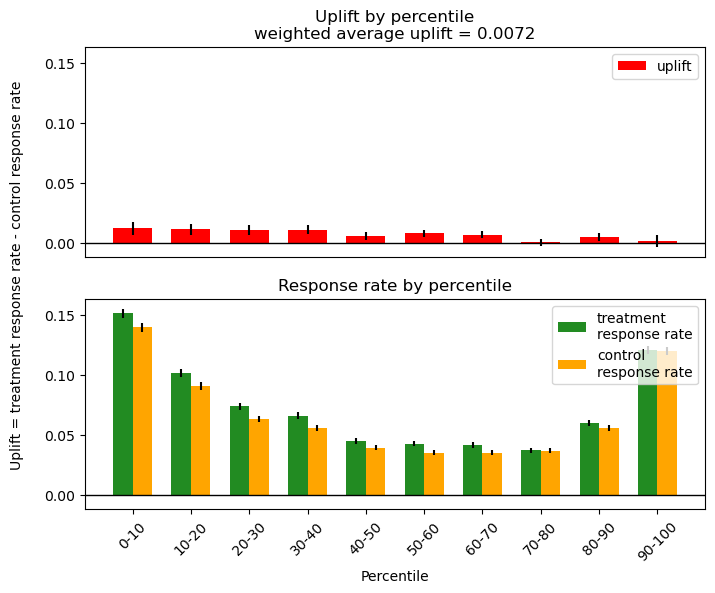

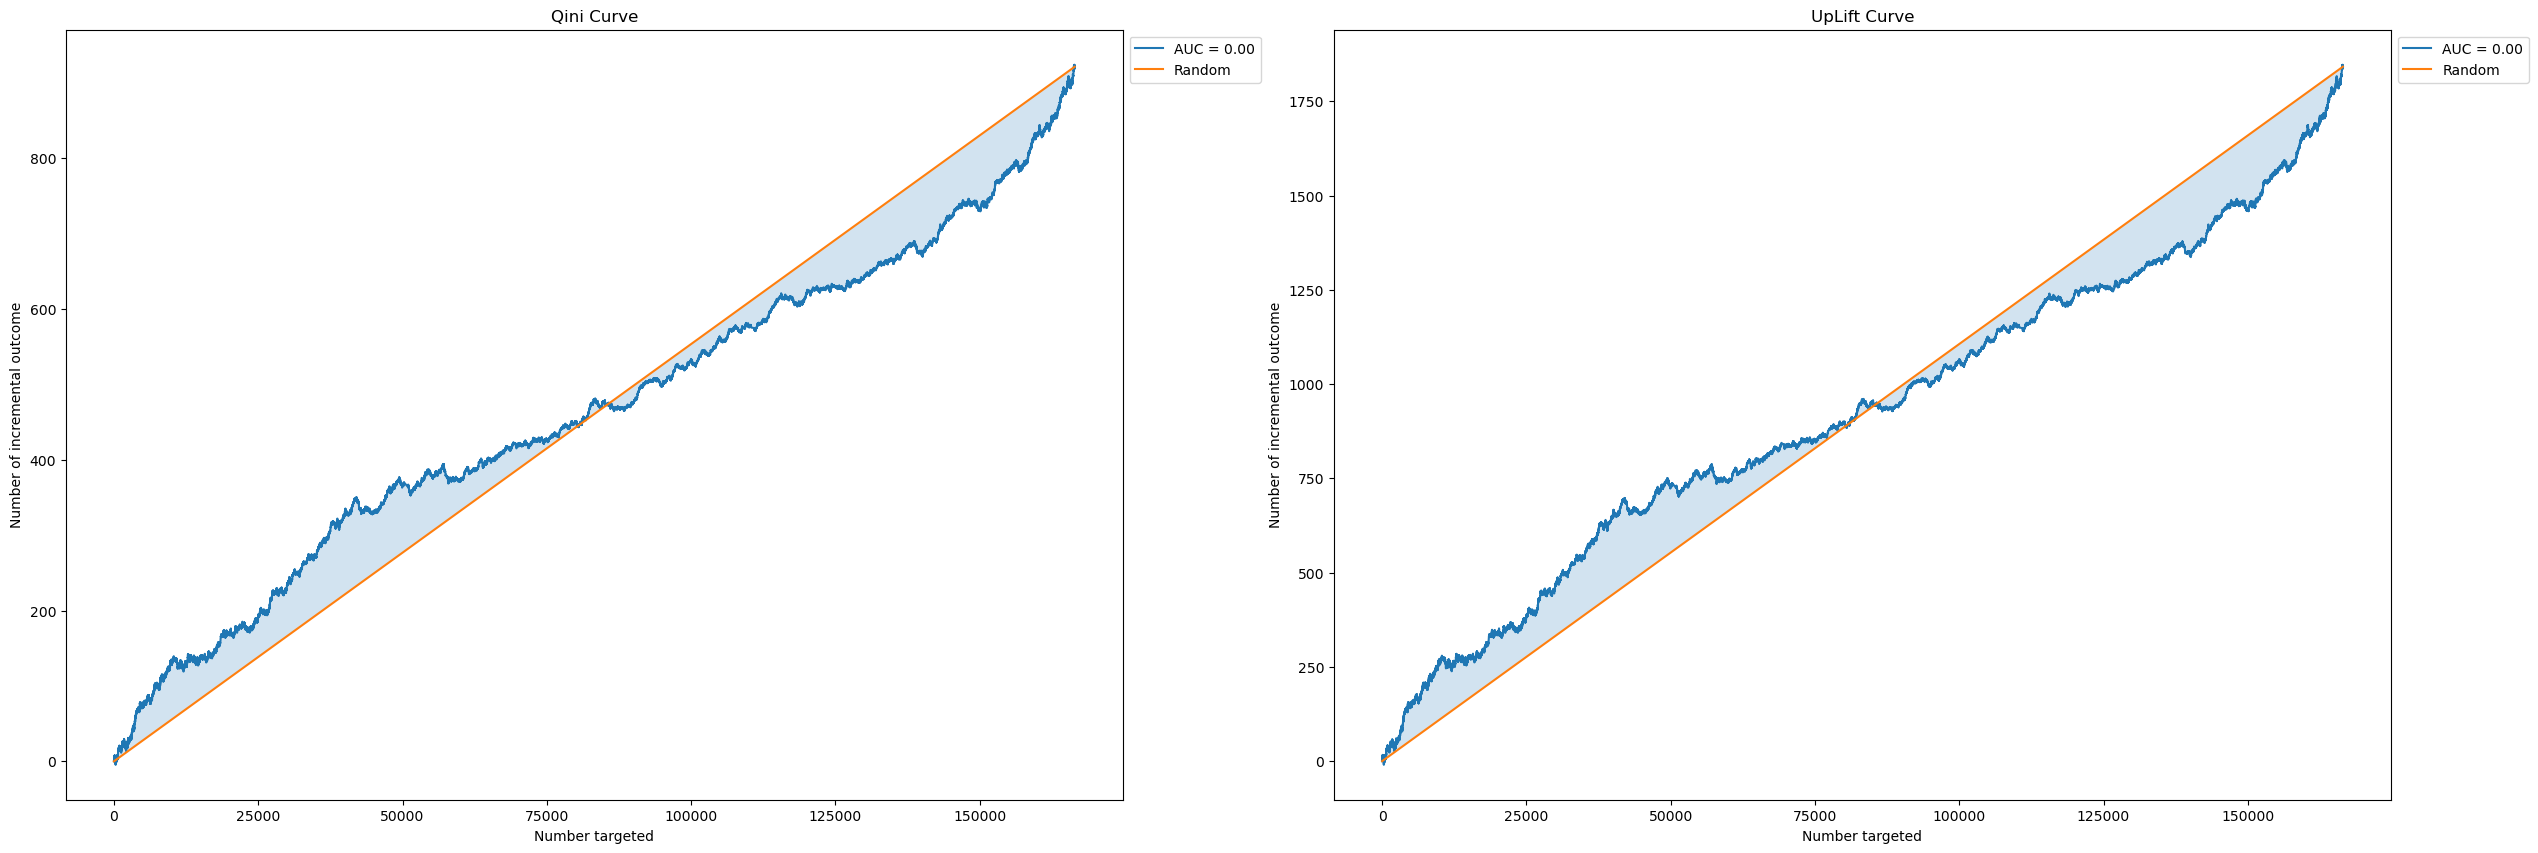

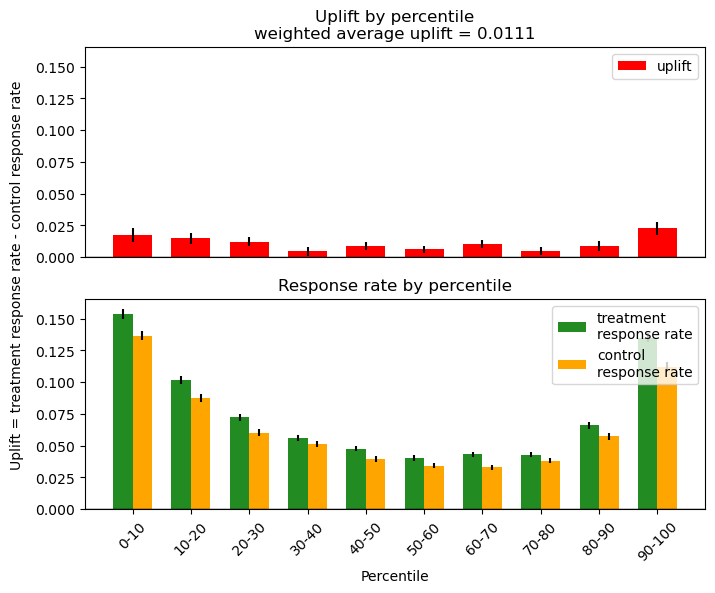

In [14]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      t_0 = np.argwhere(treat[train_index] == 0)
      t_1 = np.argwhere(treat[train_index] == 1)
      clf0 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf0.fit(np.squeeze(X_train_[t_0]), np.squeeze(y_train_[t_0]))
      clf1 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf1.fit(np.squeeze(X_train_[t_1]), np.squeeze(y_train_[t_1]))
      y_pred1 = clf1.predict_proba(X_test_).T[1]
      y_pred0 = clf0.predict_proba(X_test_).T[1]
      y_pred = y_pred1 - y_pred0
      del clf0
      del clf1
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Two model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Two model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

In [15]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

70330

# Метод трансформации класса

In [16]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







NewComer  lftm_type_NewComer  lftm_type_Regular  SEGMENT_N_1  \
7701018976         0                   1                  0            0   
7701018997         0                   1                  0            1   
7701019567         0                   1                  0            0   
7701019870         0                   1                  0            0   
7701020445         0                   1                  0            0   

            SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  SEGMENT_N_5  SEGMENT_N_6  \
7701018976            0            0            1            0            0   
7701018997            0            0            0            0            0   
7701019567            0            1            0            0            0   
7701019870            0            1            0            0            0   
7701020445            0            0            1            0            0   

            SEGMENT_N_8  SUB_EMAIL_Да  SUB_EMAIL_Нет  \
7701018976            0             0              1   
7701018997            0             0              1   
7701019567            0             1              0   
7701019870            0             0              1   
7701020445            0             1              0   

            Тип карты_Без возможности оплаты  \
7701018976                                 1   
7701018997                                 1   
7701019567                                 0   
7701019870                                 1   
7701020445                                 0   

            Тип карты_Как карточное платежное средство  \
7701018976                                           0   
7701018997                                           0   
7701019567                                           1   
7701019870                                           0   
7701020445                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7701018976                        0                          1  36.0   
7701018997                        0                          1  55.0   
7701019567                        1                          0  28.0   
7701019870                        0                          1  36.0   
7701020445                        1                          0  22.0   

            last_order_days    AMOUNT    ORDERS       AOV    LTV_1M  \
7701018976         2.042661 -0.394610 -0.326186 -0.308688 -0.394610   
7701018997        -0.381745 -0.507723 -0.326186 -0.516129 -0.507723   
7701019567         0.601122 -0.193753  0.359438 -0.378950 -0.193753   
7701019870         0.863220 -0.426720 -0.326186 -0.367575 -0.426720   
7701020445        -0.348983 -0.640295 -0.326186 -0.759258 -0.640295   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7701018976     -0.326186  -0.382164   0.000000         0.000000   
7701018997     -0.326186  -0.974353   0.000000         0.000000   
7701019567      0.359438   1.954967   1.881439        -0.028650   
7701019870     -0.326186  -0.382164   0.000000         0.000000   
7701020445     -0.326186   0.440000  -0.945282         1.055797   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7701018976       -0.300324        0.000000          -0.327790   
7701018997       -0.352820        0.000000          -0.945474   
7701019567       -0.186582       -0.357901           2.142946   
7701019870       -0.300324        0.000000          -0.327790   
7701020445       -0.422816        0.000000           0.598736   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7701018976           0.000000             0.0      -0.411228   
7701018997           0.000000             0.0      -0.514400   
7701019567           2.173032             0.0      -0.187688   
7701019870           0.000000             0.0      -0.411228   
7701020445          -1.077897             0.0      -0.651963   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS

target  treat
7701018976       0      1
7701018997       0      0
7701019567       0      1
7701019870       0      1
7701020445       0      0

In [17]:
treat = Y_data.treat.values
p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
targ = Y_data.target
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


[[0.       1.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.269954 0.017543 0.266453]
 ...
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]]
[ 0. -0.  0. ...  0. -0. -0.]
0.5010158242714119


Split 1; WAU = 0.007944828123201204; UpLift 30% = 0.011956788390925552


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.009419691815104981; UpLift 30% = 0.013203845990407595


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.00931485778264898; UpLift 30% = 0.015072413707384852


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.006728913227714725; UpLift 30% = 0.011843557415751577


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.01124195828196546; UpLift 30% = 0.018907797987522998


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0089; Mean UpLift 30% = 0.0142


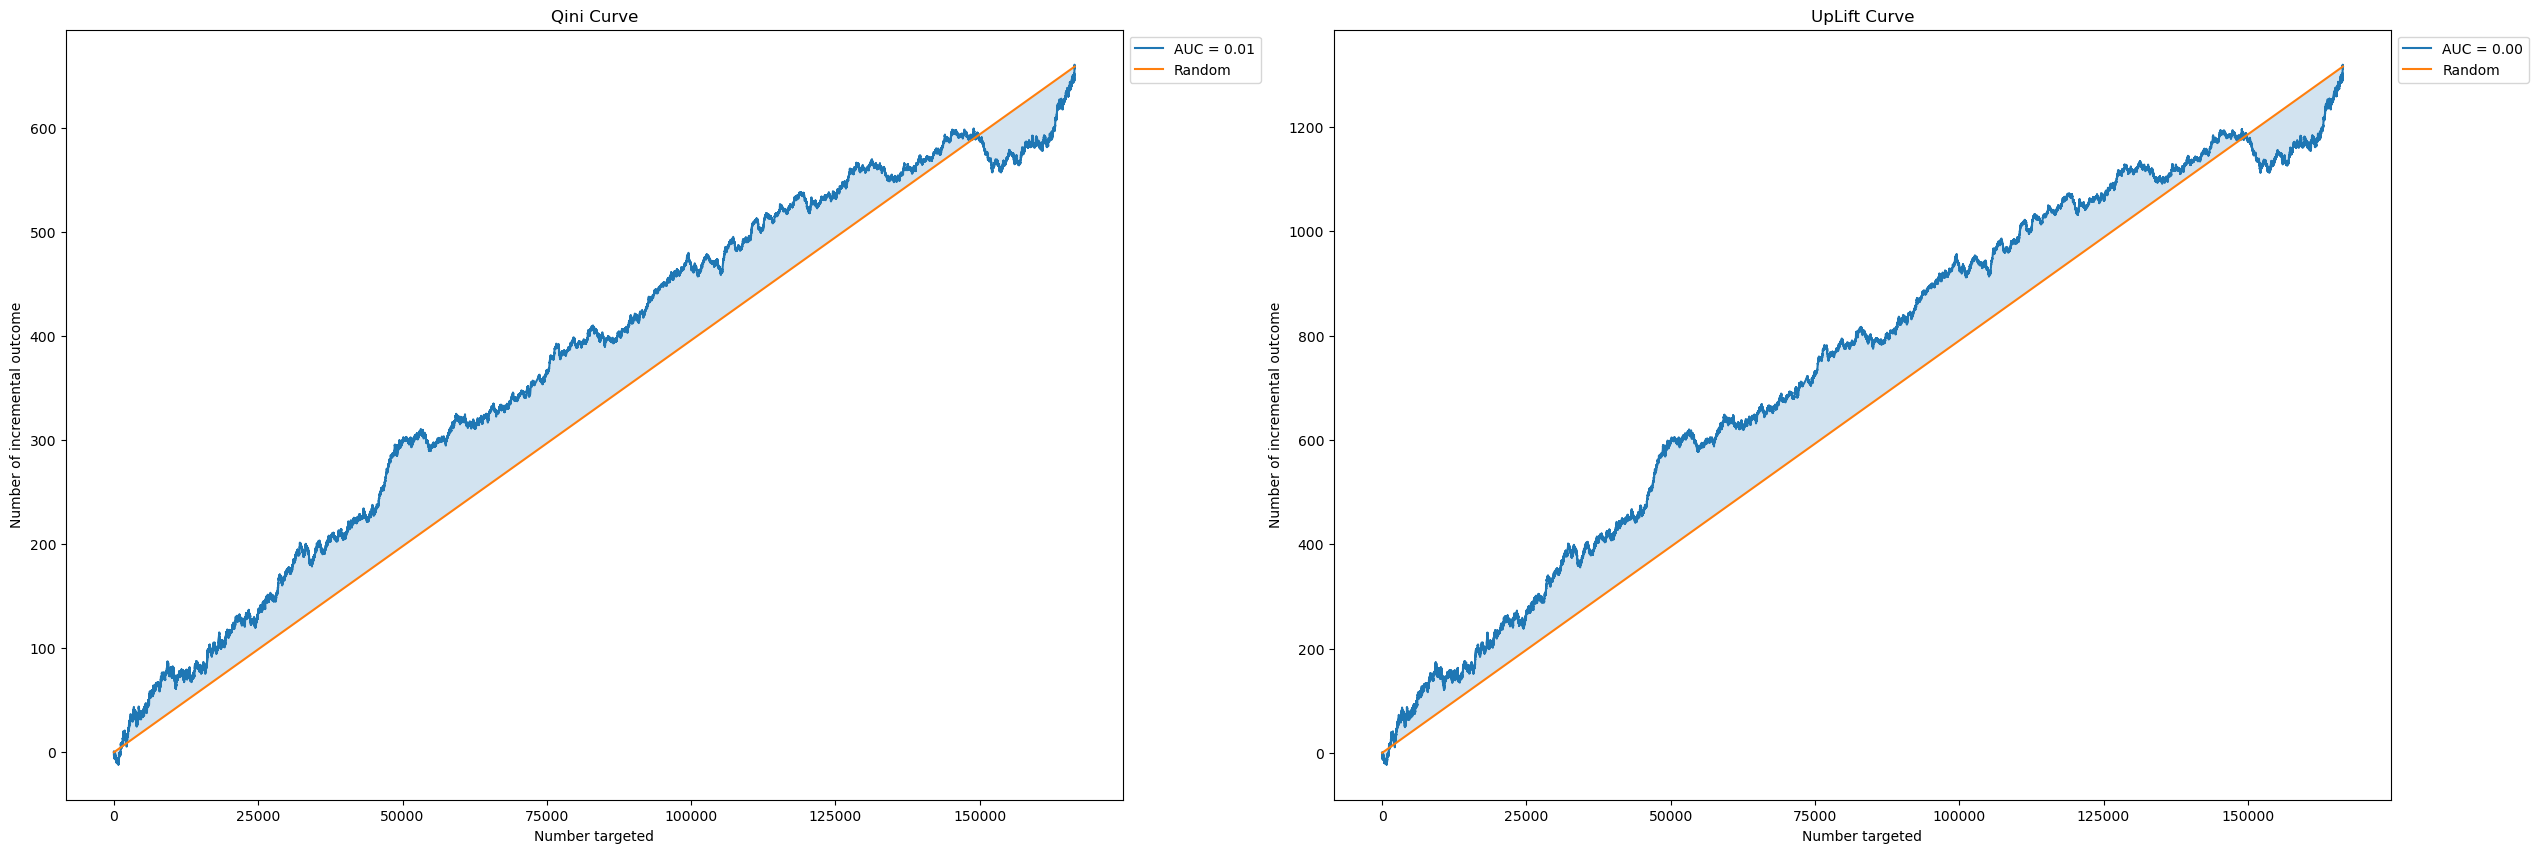

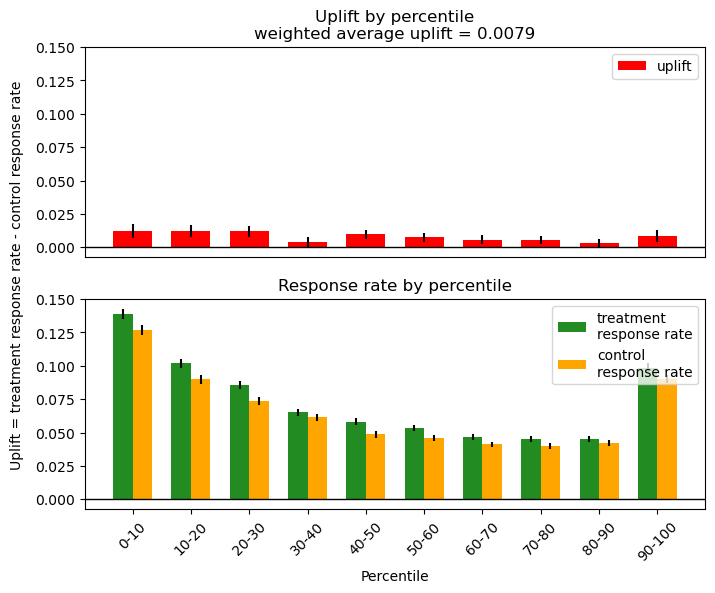

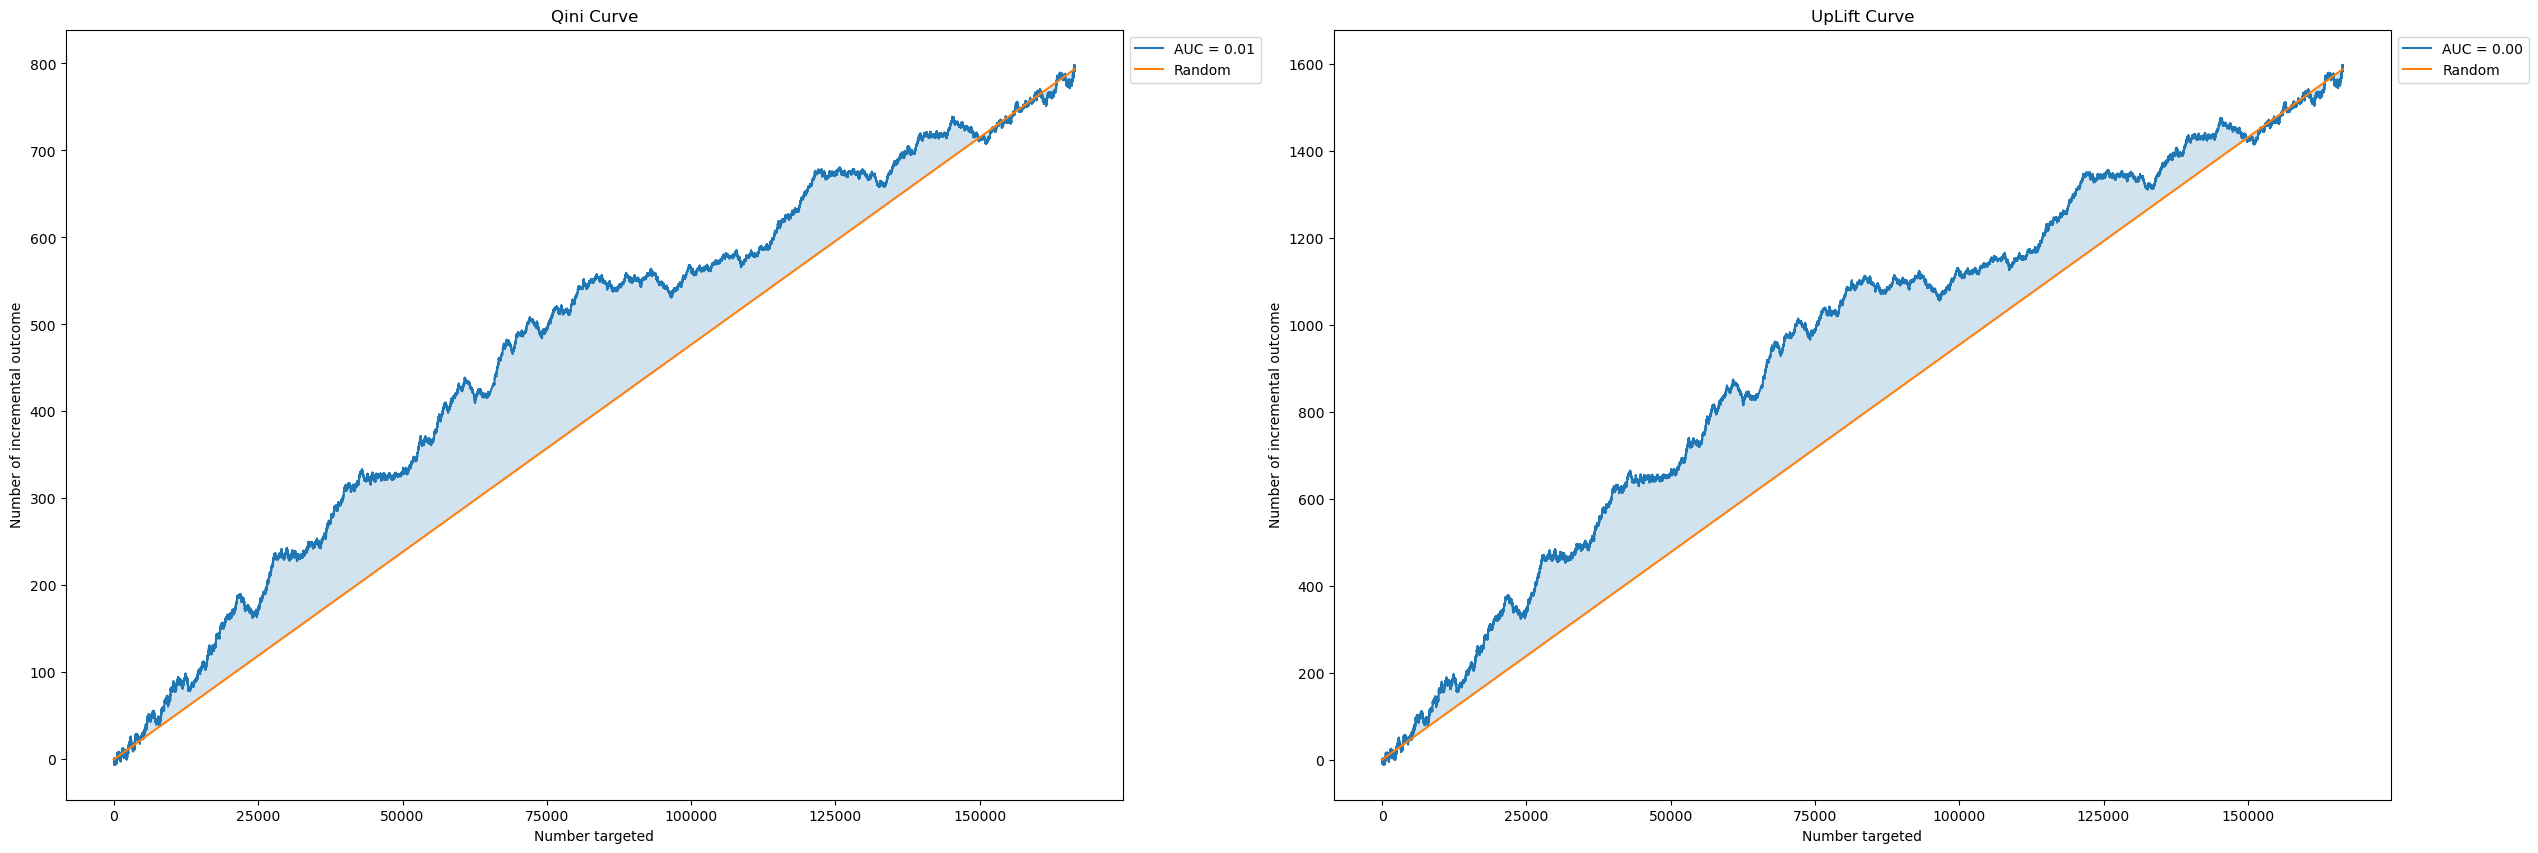

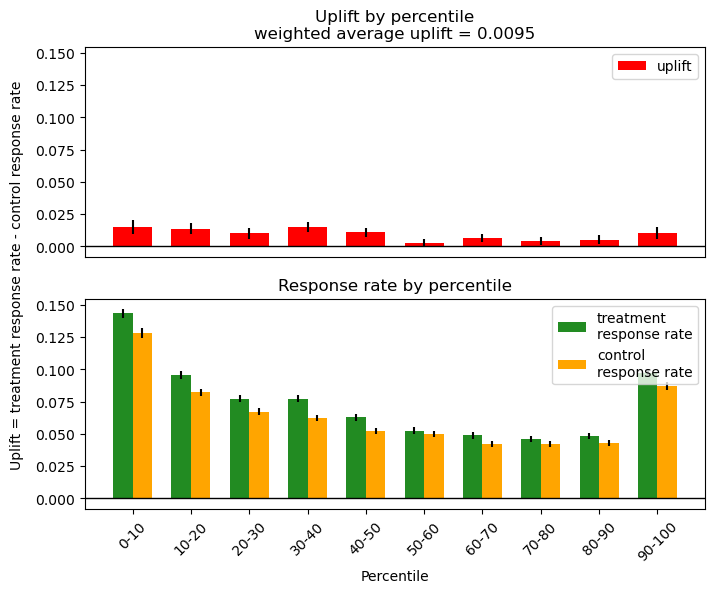

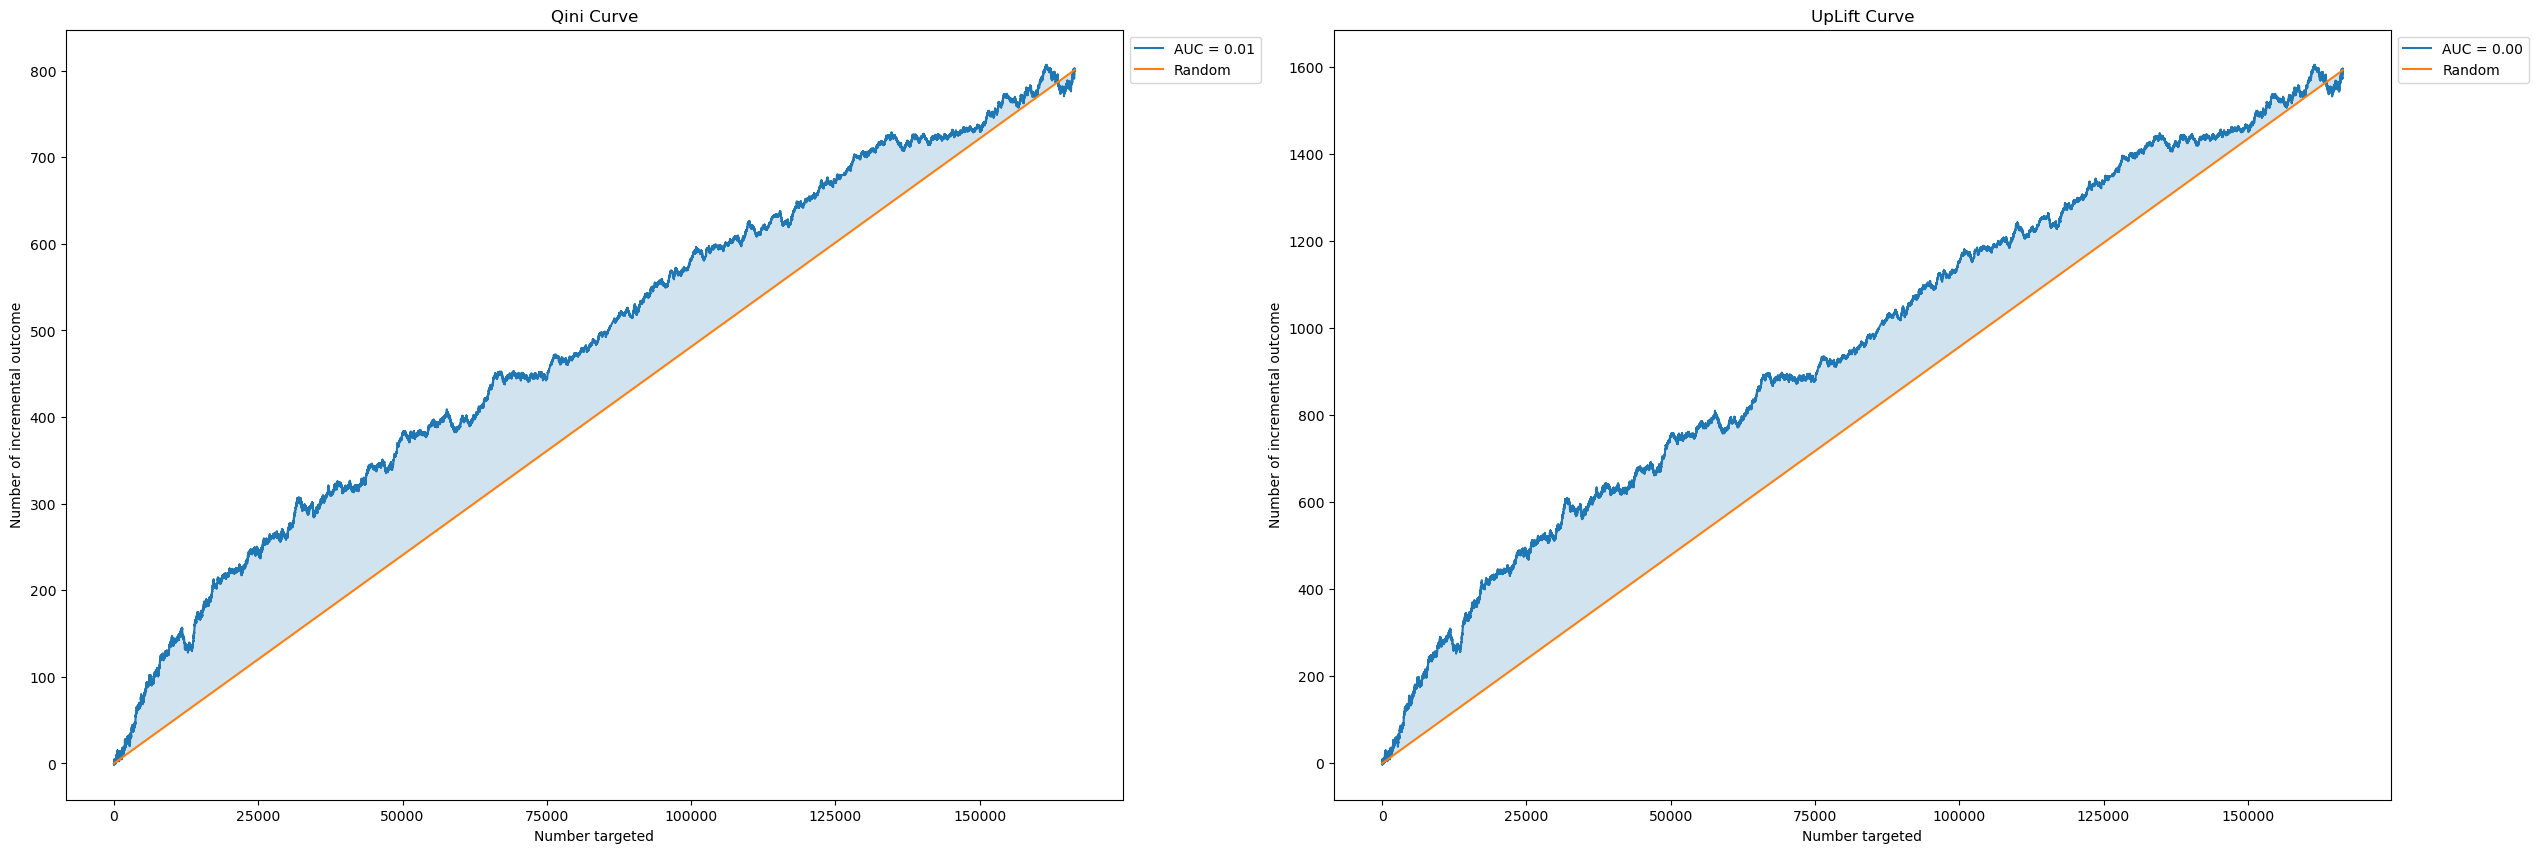

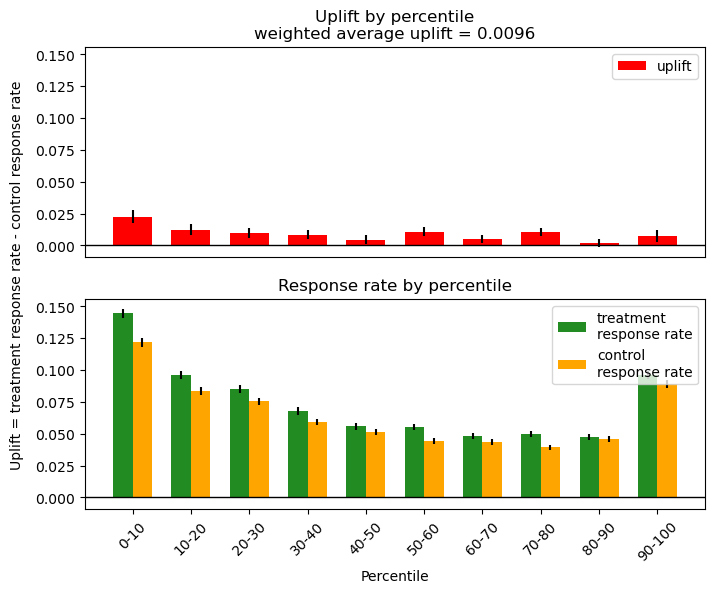

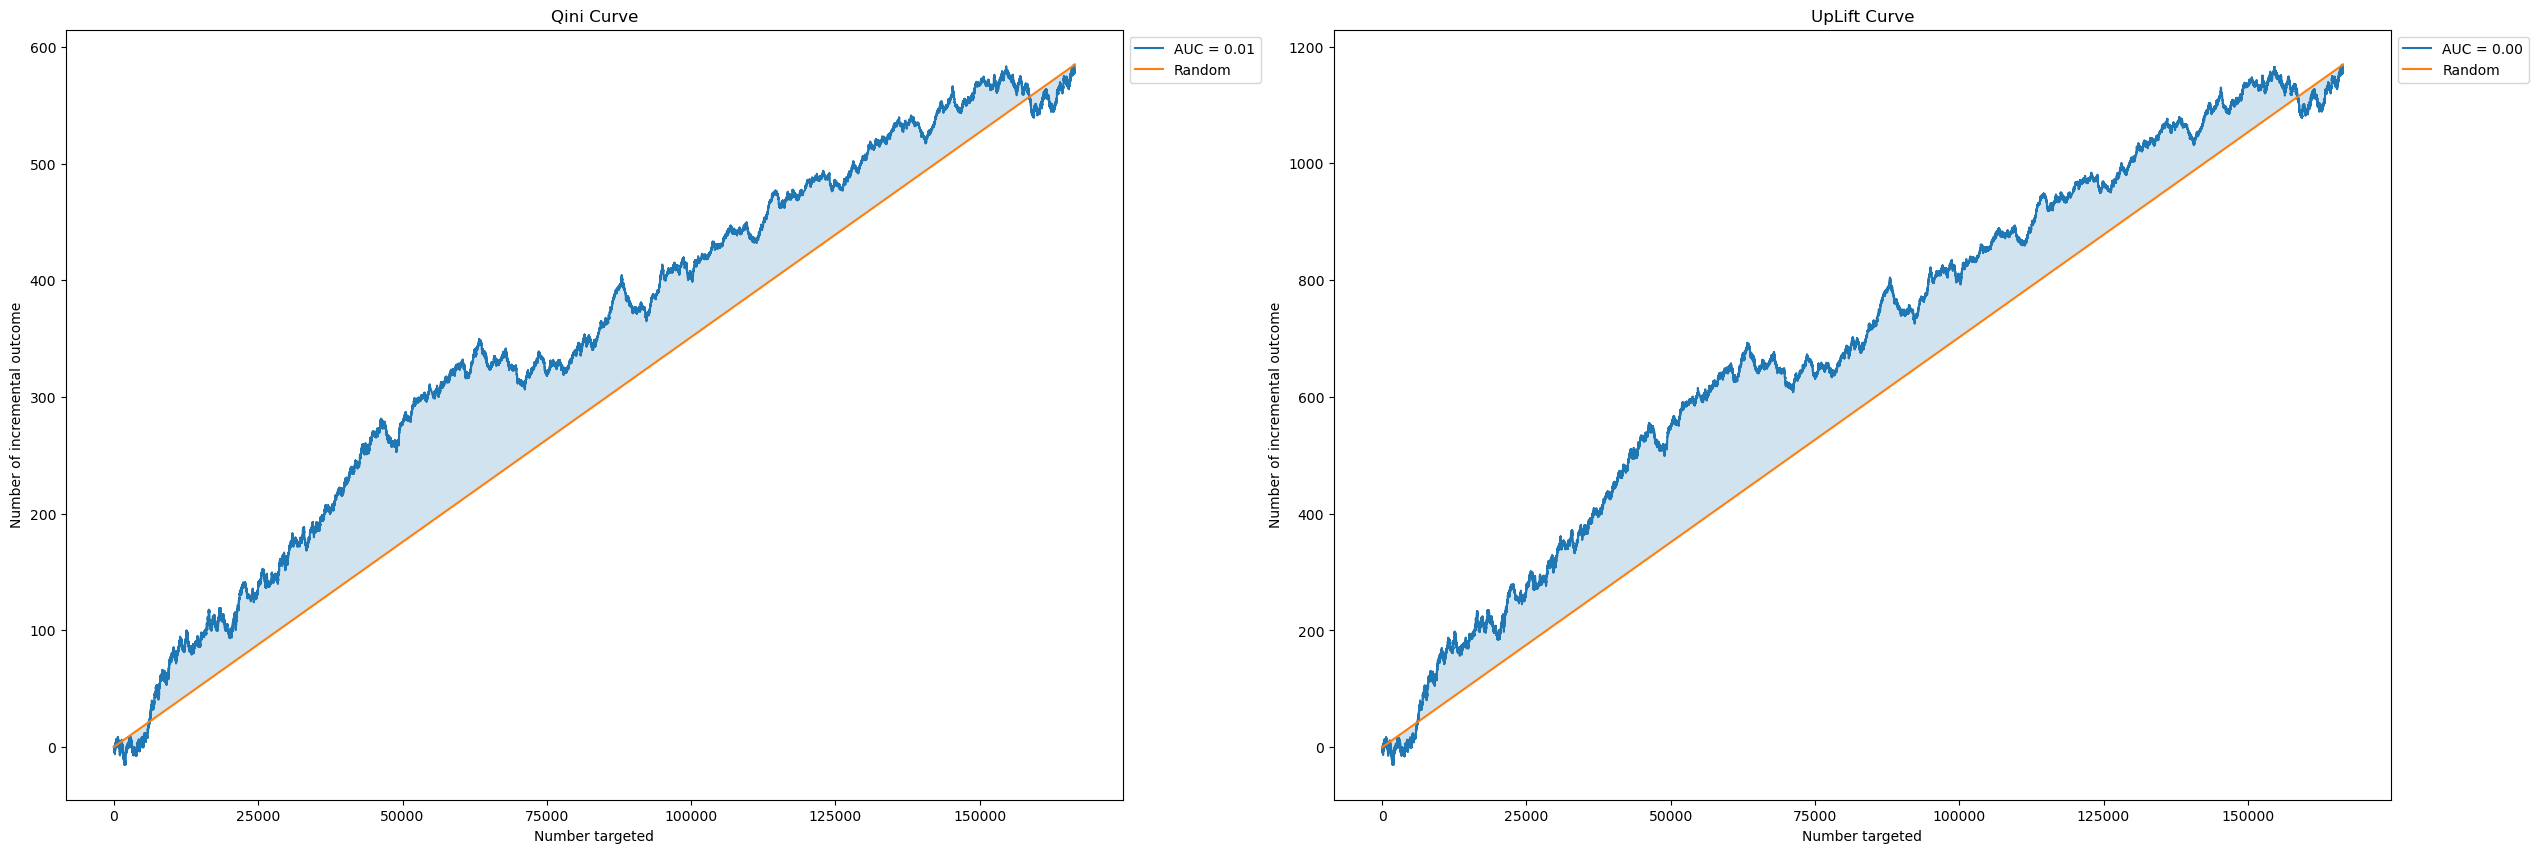

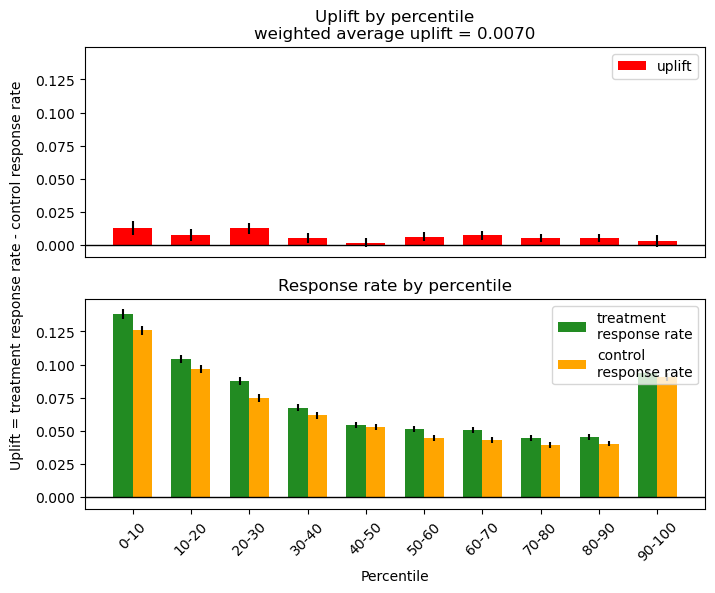

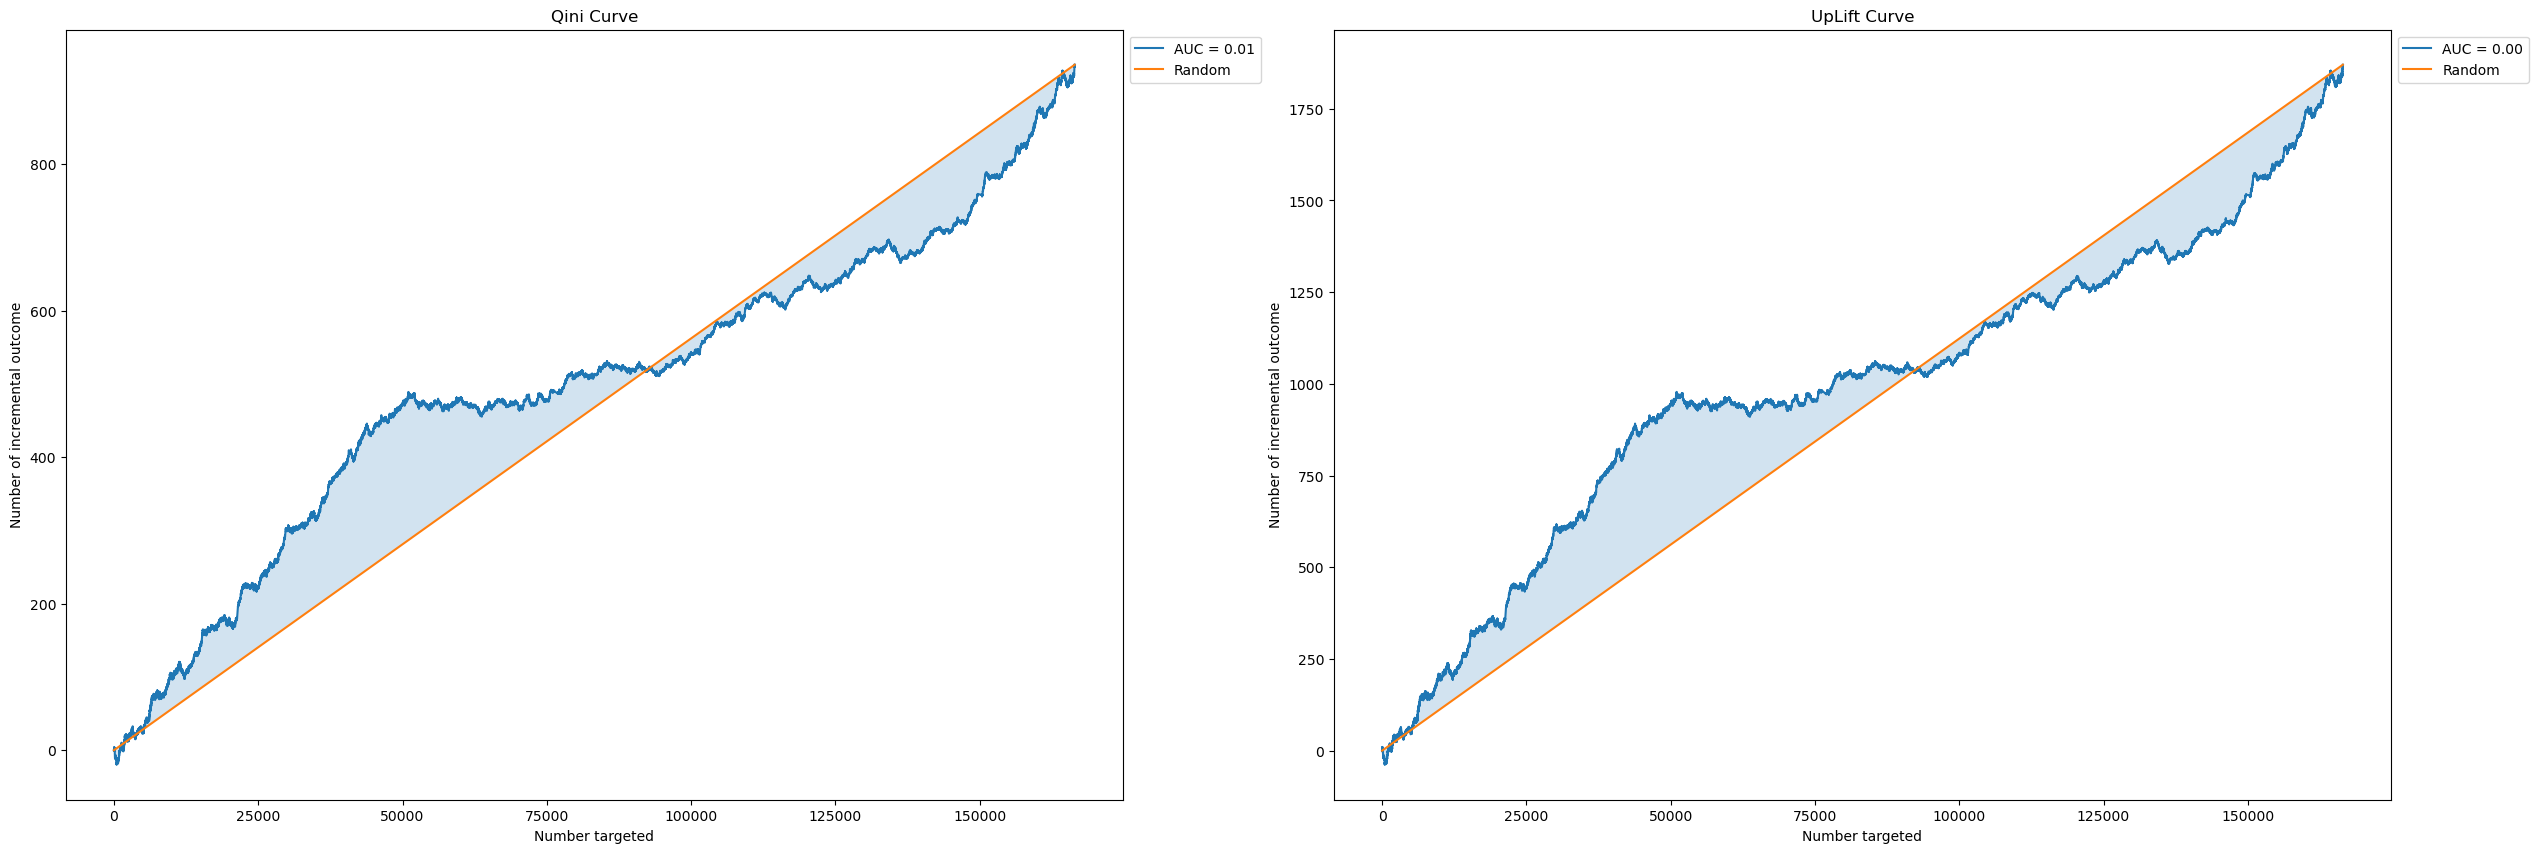

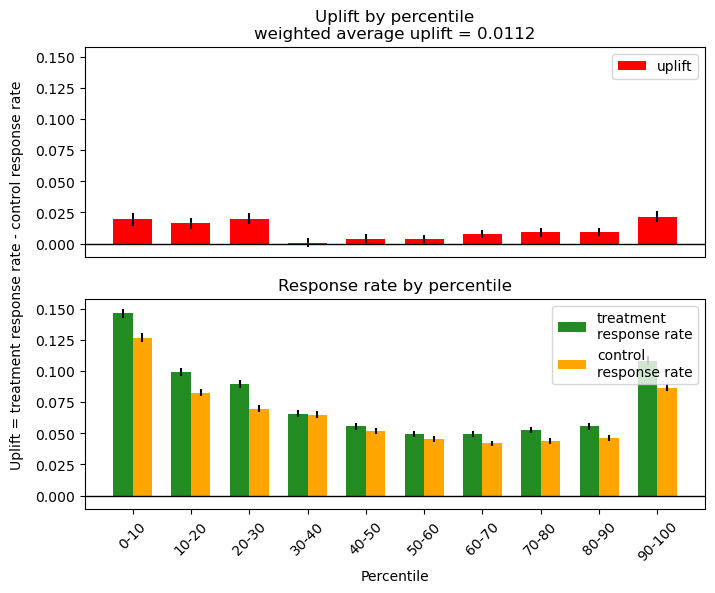

In [18]:
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      reg = CatBoostRegressor(verbose=0)
      reg.fit(X_train_, y_train_)
      y_pred = reg.predict(X_test_)
      del reg
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% = {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')


In [19]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

71680

# AutoML

## Search PipeLine

In [4]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values.astype(float)
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


NewComer  lftm_type_NewComer  lftm_type_Regular  SEGMENT_N_1  \
7701018976         0                   1                  0            0   
7701018997         0                   1                  0            1   
7701019567         0                   1                  0            0   
7701019870         0                   1                  0            0   
7701020445         0                   1                  0            0   

            SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  SEGMENT_N_5  SEGMENT_N_6  \
7701018976            0            0            1            0            0   
7701018997            0            0            0            0            0   
7701019567            0            1            0            0            0   
7701019870            0            1            0            0            0   
7701020445            0            0            1            0            0   

            SEGMENT_N_8  SUB_EMAIL_Да  SUB_EMAIL_Нет  \
7701018976            0             0              1   
7701018997            0             0              1   
7701019567            0             1              0   
7701019870            0             0              1   
7701020445            0             1              0   

            Тип карты_Без возможности оплаты  \
7701018976                                 1   
7701018997                                 1   
7701019567                                 0   
7701019870                                 1   
7701020445                                 0   

            Тип карты_Как карточное платежное средство  \
7701018976                                           0   
7701018997                                           0   
7701019567                                           1   
7701019870                                           0   
7701020445                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7701018976                        0                          1  36.0   
7701018997                        0                          1  55.0   
7701019567                        1                          0  28.0   
7701019870                        0                          1  36.0   
7701020445                        1                          0  22.0   

            last_order_days    AMOUNT    ORDERS       AOV    LTV_1M  \
7701018976         2.042661 -0.394610 -0.326186 -0.308688 -0.394610   
7701018997        -0.381745 -0.507723 -0.326186 -0.516129 -0.507723   
7701019567         0.601122 -0.193753  0.359438 -0.378950 -0.193753   
7701019870         0.863220 -0.426720 -0.326186 -0.367575 -0.426720   
7701020445        -0.348983 -0.640295 -0.326186 -0.759258 -0.640295   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7701018976     -0.326186  -0.382164   0.000000         0.000000   
7701018997     -0.326186  -0.974353   0.000000         0.000000   
7701019567      0.359438   1.954967   1.881439        -0.028650   
7701019870     -0.326186  -0.382164   0.000000         0.000000   
7701020445     -0.326186   0.440000  -0.945282         1.055797   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7701018976       -0.300324        0.000000          -0.327790   
7701018997       -0.352820        0.000000          -0.945474   
7701019567       -0.186582       -0.357901           2.142946   
7701019870       -0.300324        0.000000          -0.327790   
7701020445       -0.422816        0.000000           0.598736   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7701018976           0.000000             0.0      -0.411228   
7701018997           0.000000             0.0      -0.514400   
7701019567           2.173032             0.0      -0.187688   
7701019870           0.000000             0.0      -0.411228   
7701020445          -1.077897             0.0      -0.651963   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS

target  treat
7701018976       0      1
7701018997       0      0
7701019567       0      1
7701019870       0      1
7701020445       0      0

[[0.       1.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.269954 0.017543 0.266453]
 ...
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]]
[ 0. -0.  0. ...  0. -0. -0.]
0.5010158242714119


In [5]:
import evalml
from evalml import AutoMLSearch

In [2]:
# from evalml.objectives import get_optimization_objectives
# from evalml.problem_types import ProblemTypes

# for objective in get_optimization_objectives(ProblemTypes.REGRESSION):
#     print(objective.name)

ExpVariance
MaxError
MedianAE
MSE
MAE
R2
Root Mean Squared Error


In [6]:
X_train,X_test,y_train,y_test= evalml.preprocessing.utils.split_data(X, y, problem_type="regression")

In [7]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='regression'
                    , patience= 20
                    , verbose = True
                    , allow_long_running_models = True
                    , max_batches = 20
                    , objective = 'MSE'
                    , optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 20
                    , holdout_set_size= 0
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for MSE. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 20 batches for a total of 20 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean MSE: 0.282

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean MSE: 0.282
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer:
	Starting cross validation
	Finished cross validation - mean MSE: 0.282

*****************************
* Evaluating Batch Number 2 *
*****************************

Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean MSE: 0.282
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cr

{1: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler': '00:16',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer': '00:26',
  'Total time of batch': '00:43'},
 2: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model': '00:30',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model': '00:38',
  'Total time of batch': '01:09'},
 3: {'Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:05',
  'Extra Trees Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:12',
  'XGBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:11',
  'CatBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:05',
  'LightGBM Regressor w/ Replace

In [8]:
automl.save('automl_big_searching.cloudpickle')

## Train Best Pipeline

In [9]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching.cloudpickle')


In [10]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [11]:
ranks.to_csv('evalml_res.csv', index = False)

In [12]:
ranks.head()

pipeline_name  validation_score  \
0  CatBoost Regressor w/ Replace Nullable Types T...          0.281737   
1  Elastic Net Regressor w/ Replace Nullable Type...          0.281743   
2                  Mean Baseline Regression Pipeline          0.281745   
3  Elastic Net Regressor w/ Replace Nullable Type...          0.281745   
6  Elastic Net Regressor w/ Replace Nullable Type...          0.281764   

   percent_better_than_baseline  \
0                      0.002700   
1                      0.000738   
2                      0.000000   
3                      0.000000   
6                     -0.006971   

                                          parameters  
0  {'Imputer': {'categorical_impute_strategy': 'm...  
1  {'Imputer': {'categorical_impute_strategy': 'm...  
2       {'Baseline Regressor': {'strategy': 'mean'}}  
3  {'Imputer': {'categorical_impute_strategy': 'm...  
6  {'Imputer': {'categorical_impute_strategy': 'm...

In [13]:
ranks.shape

(13, 4)

In [14]:

ranks.head(10).to_excel('res.xlsx')

In [15]:
ranks.iloc[0, :].parameters

{'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Select Columns Transformer': {'columns': [0,
   3,
   5,
   16,
   17,
   18,
   20,
   21,
   23,
   24,
   25,
   26,
   28,
   31,
   33,
   34,
   35,
   38,
   41,
   43,
   44,
   45,
   46,
   47,
   48]},
 'CatBoost Regressor': {'n_estimators': 10,
  'eta': 0.03,
  'max_depth': 6,
  'bootstrap_type': None,
  'silent': False,
  'allow_writing_files': False,
  'n_jobs': -1}}

In [17]:
ctbst  = automl.best_pipeline
type(ctbst)

evalml.pipelines.regression_pipeline.RegressionPipeline

In [18]:
#ctbst.fit(X_train, y_train)

In [20]:
best_features = ctbst.feature_importance.copy()
best_features = best_features[best_features.importance.abs() > 1]
best_features

feature  importance
0        17   11.346774
1        16   10.933050
2        25   10.834083
3        47    7.690868
4        34    7.640018
5        44    5.878395
6        26    5.738071
7        43    5.736764
8        23    4.748306
9        35    4.147978
10       38    4.062204
11       20    3.989149
12       33    3.673056
13       18    3.490013
14       31    2.803592
15       28    2.109016
16       46    1.832253
17       48    1.791435

In [21]:
features

['NewComer',
 'lftm_type_NewComer',
 'lftm_type_Regular',
 'SEGMENT_N_1',
 'SEGMENT_N_2',
 'SEGMENT_N_3',
 'SEGMENT_N_4',
 'SEGMENT_N_5',
 'SEGMENT_N_6',
 'SEGMENT_N_8',
 'SUB_EMAIL_Да',
 'SUB_EMAIL_Нет',
 'Тип карты_Без возможности оплаты',
 'Тип карты_Как карточное платежное средство',
 'Канал регистрации_Ecomm',
 'Канал регистрации_Розница',
 'AGE',
 'last_order_days',
 'AMOUNT',
 'ORDERS',
 'AOV',
 'LTV_1M',
 'AO_per_month',
 'GET_Bonus',
 'USE_Bonus',
 'NON_SPEND_BONUS',
 'BASE_GET_Bonus',
 'BASE_USE_Bonus',
 'Express_GET_Bonus',
 'Express_USE_Bonus',
 'Camp_GET_Bonus',
 'REG_GET_Bonus',
 'Camp_BASE_GET_Bonus',
 'REG_BASE_GET_Bonus',
 'AVG_USE_BONUS',
 'DISC_AMOUNT',
 'DISC_ORDERS',
 'BASE_AVG_USE_BONUS',
 'BASE_DISC_AMOUNT',
 'BASE_DISC_ORDERS',
 'Express_AVG_USE_BONUS',
 'Express_DISC_AMOUNT',
 'Express_DISC_ORDERS',
 'min_days_between',
 'max_days_between',
 'avg_days_between',
 'AVG_DIS',
 'BASE_AVG_DIS',
 'Express_AVG_DIS']

In [22]:
best_features['Name'] = best_features.feature.apply(lambda x: features[x])
best_features

feature  importance                Name
0        17   11.346774     last_order_days
1        16   10.933050                 AGE
2        25   10.834083     NON_SPEND_BONUS
3        47    7.690868        BASE_AVG_DIS
4        34    7.640018       AVG_USE_BONUS
5        44    5.878395    max_days_between
6        26    5.738071      BASE_GET_Bonus
7        43    5.736764    min_days_between
8        23    4.748306           GET_Bonus
9        35    4.147978         DISC_AMOUNT
10       38    4.062204    BASE_DISC_AMOUNT
11       20    3.989149                 AOV
12       33    3.673056  REG_BASE_GET_Bonus
13       18    3.490013              AMOUNT
14       31    2.803592       REG_GET_Bonus
15       28    2.109016   Express_GET_Bonus
16       46    1.832253             AVG_DIS
17       48    1.791435     Express_AVG_DIS

In [23]:
print(best_features.Name.tolist())

['last_order_days', 'AGE', 'NON_SPEND_BONUS', 'BASE_AVG_DIS', 'AVG_USE_BONUS', 'max_days_between', 'BASE_GET_Bonus', 'min_days_between', 'GET_Bonus', 'DISC_AMOUNT', 'BASE_DISC_AMOUNT', 'AOV', 'REG_BASE_GET_Bonus', 'AMOUNT', 'REG_GET_Bonus', 'Express_GET_Bonus', 'AVG_DIS', 'Express_AVG_DIS']


In [24]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


NewComer  lftm_type_NewComer  lftm_type_Regular  SEGMENT_N_1  \
7701018976         0                   1                  0            0   
7701018997         0                   1                  0            1   
7701019567         0                   1                  0            0   
7701019870         0                   1                  0            0   
7701020445         0                   1                  0            0   

            SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  SEGMENT_N_5  SEGMENT_N_6  \
7701018976            0            0            1            0            0   
7701018997            0            0            0            0            0   
7701019567            0            1            0            0            0   
7701019870            0            1            0            0            0   
7701020445            0            0            1            0            0   

            SEGMENT_N_8  SUB_EMAIL_Да  SUB_EMAIL_Нет  \
7701018976            0             0              1   
7701018997            0             0              1   
7701019567            0             1              0   
7701019870            0             0              1   
7701020445            0             1              0   

            Тип карты_Без возможности оплаты  \
7701018976                                 1   
7701018997                                 1   
7701019567                                 0   
7701019870                                 1   
7701020445                                 0   

            Тип карты_Как карточное платежное средство  \
7701018976                                           0   
7701018997                                           0   
7701019567                                           1   
7701019870                                           0   
7701020445                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7701018976                        0                          1  36.0   
7701018997                        0                          1  55.0   
7701019567                        1                          0  28.0   
7701019870                        0                          1  36.0   
7701020445                        1                          0  22.0   

            last_order_days    AMOUNT    ORDERS       AOV    LTV_1M  \
7701018976         2.042661 -0.394610 -0.326186 -0.308688 -0.394610   
7701018997        -0.381745 -0.507723 -0.326186 -0.516129 -0.507723   
7701019567         0.601122 -0.193753  0.359438 -0.378950 -0.193753   
7701019870         0.863220 -0.426720 -0.326186 -0.367575 -0.426720   
7701020445        -0.348983 -0.640295 -0.326186 -0.759258 -0.640295   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7701018976     -0.326186  -0.382164   0.000000         0.000000   
7701018997     -0.326186  -0.974353   0.000000         0.000000   
7701019567      0.359438   1.954967   1.881439        -0.028650   
7701019870     -0.326186  -0.382164   0.000000         0.000000   
7701020445     -0.326186   0.440000  -0.945282         1.055797   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7701018976       -0.300324        0.000000          -0.327790   
7701018997       -0.352820        0.000000          -0.945474   
7701019567       -0.186582       -0.357901           2.142946   
7701019870       -0.300324        0.000000          -0.327790   
7701020445       -0.422816        0.000000           0.598736   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7701018976           0.000000             0.0      -0.411228   
7701018997           0.000000             0.0      -0.514400   
7701019567           2.173032             0.0      -0.187688   
7701019870           0.000000             0.0      -0.411228   
7701020445          -1.077897             0.0      -0.651963   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS

target  treat
7701018976       0      1
7701018997       0      0
7701019567       0      1
7701019870       0      1
7701020445       0      0

[[0.       1.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.269954 0.017543 0.266453]
 ...
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]]
[ 0. -0.  0. ...  0. -0. -0.]
0.5010158242714119


Split 1; WAU = 0.007832964790919678; UpLift 30% = 0.01705224195456198


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 2; WAU = 0.009405154111598318; UpLift 30% = 0.017088927883819244


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 3; WAU = 0.009143054846603257; UpLift 30% = 0.02200289575721534


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 4; WAU = 0.0068205753192238615; UpLift 30% = 0.015493891652616804


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 5; WAU = 0.01103813217950361; UpLift 30% = 0.022150146298680284


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Mean WAU = 0.0088; Mean UpLift 30% = 0.0188


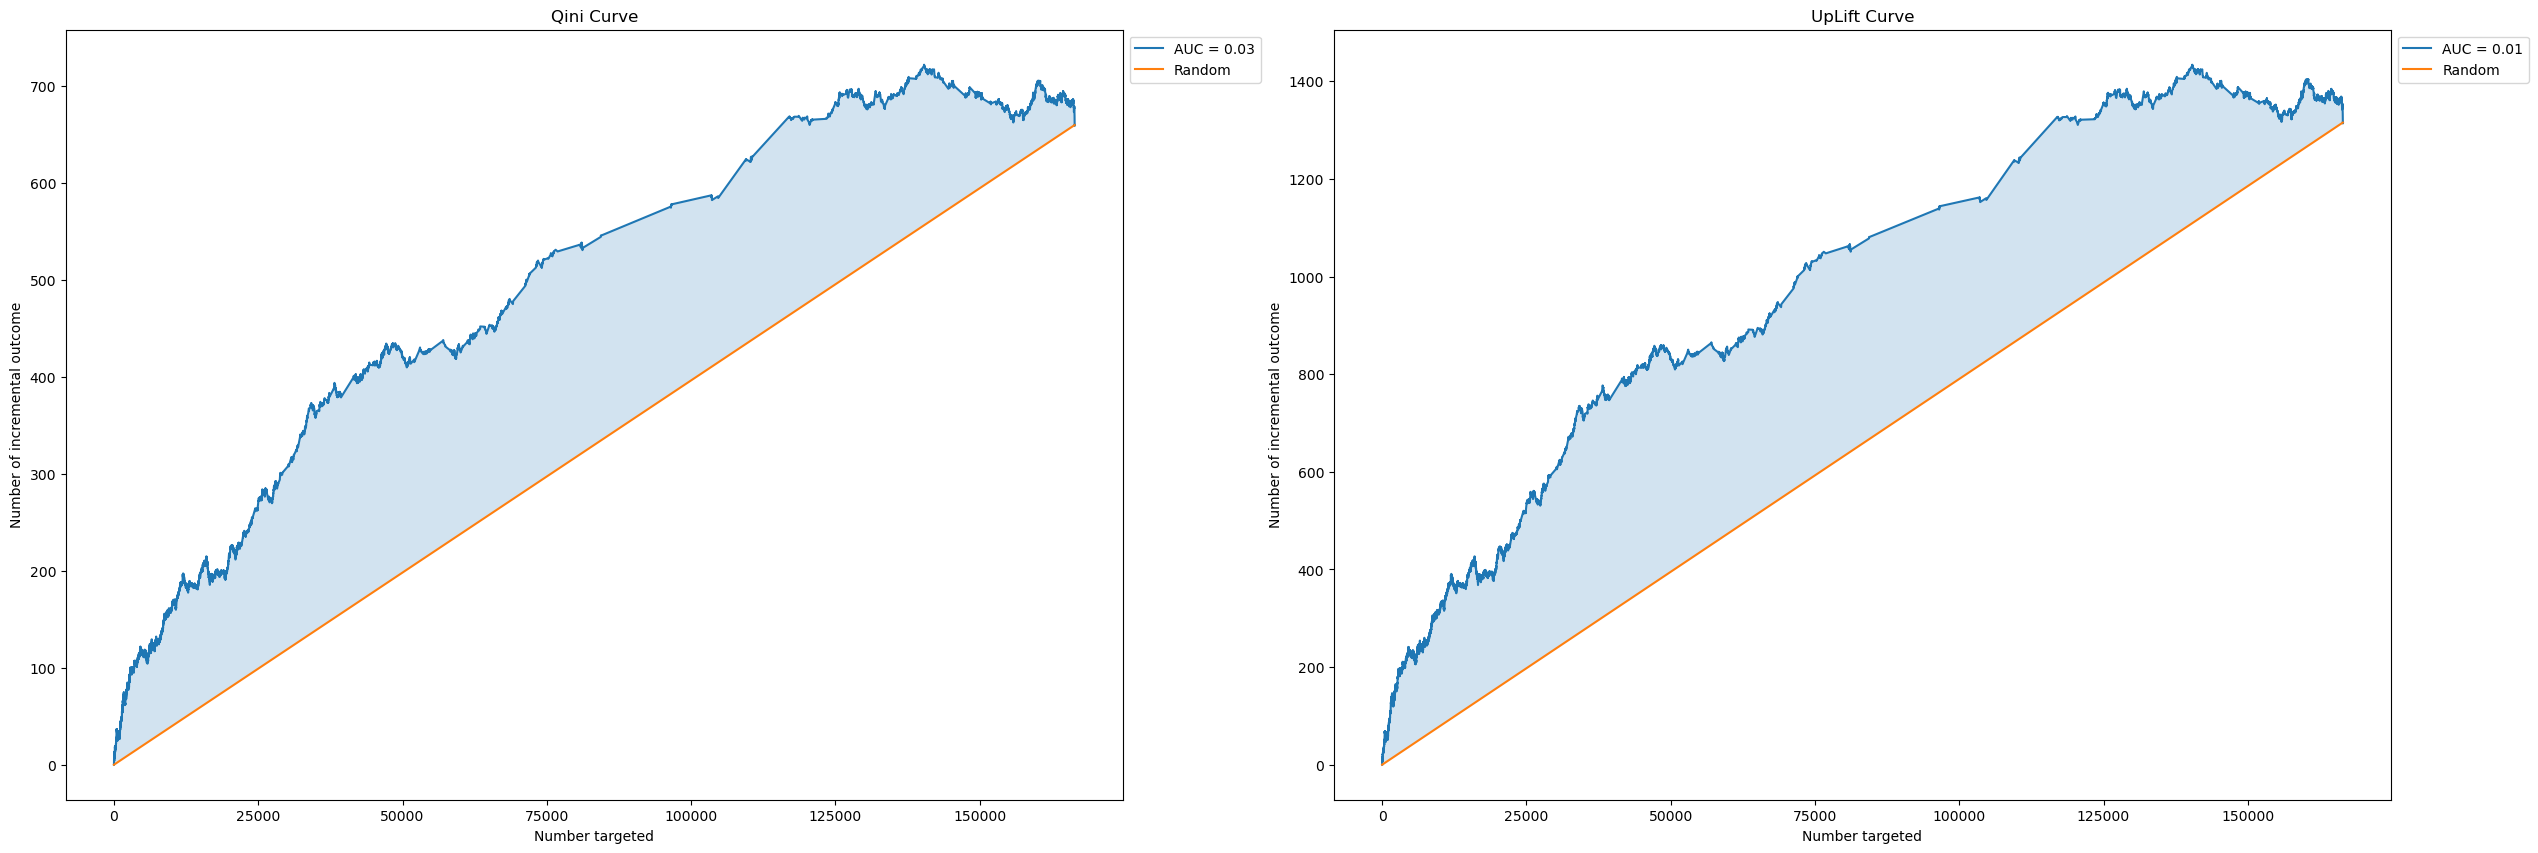

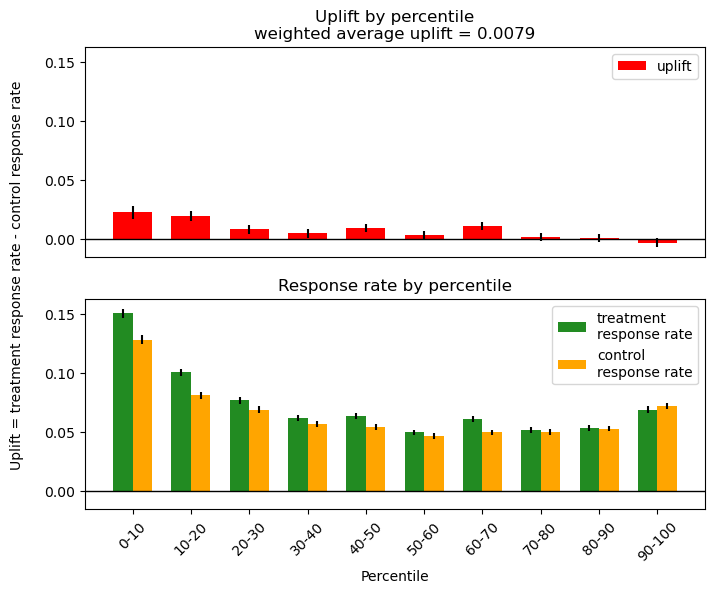

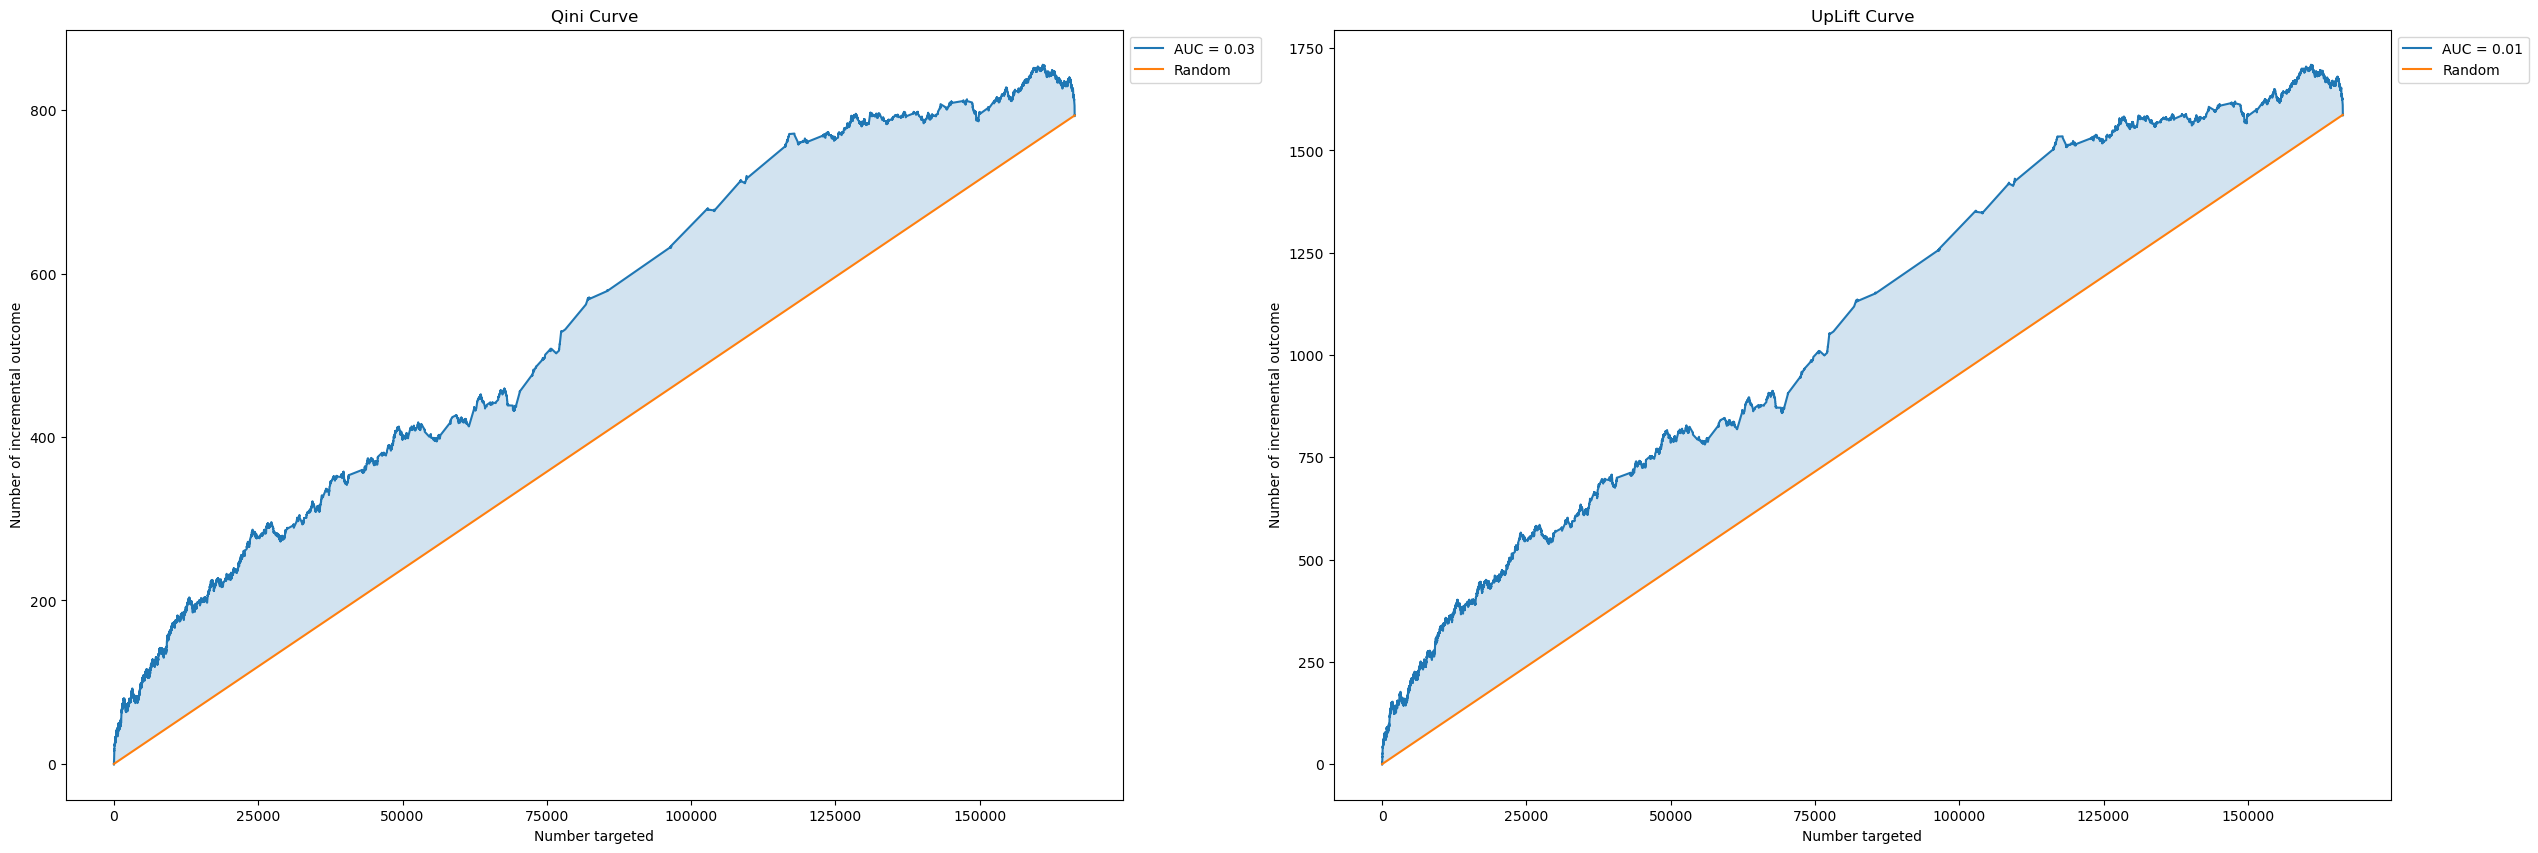

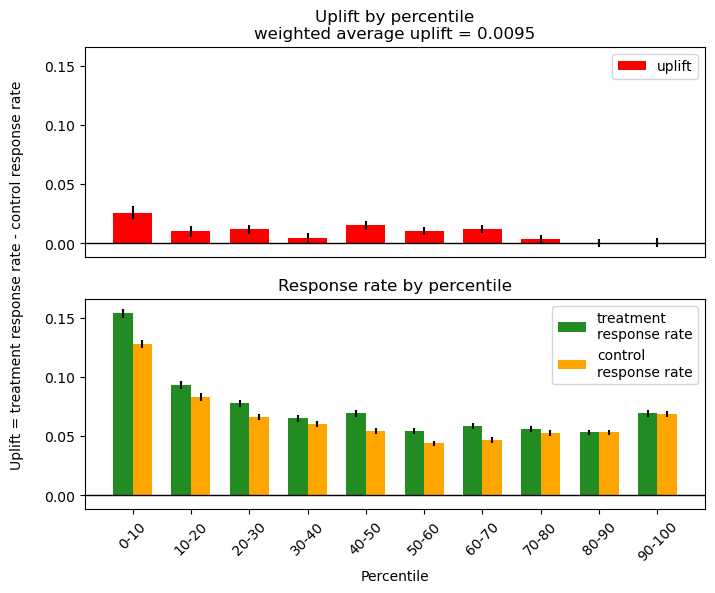

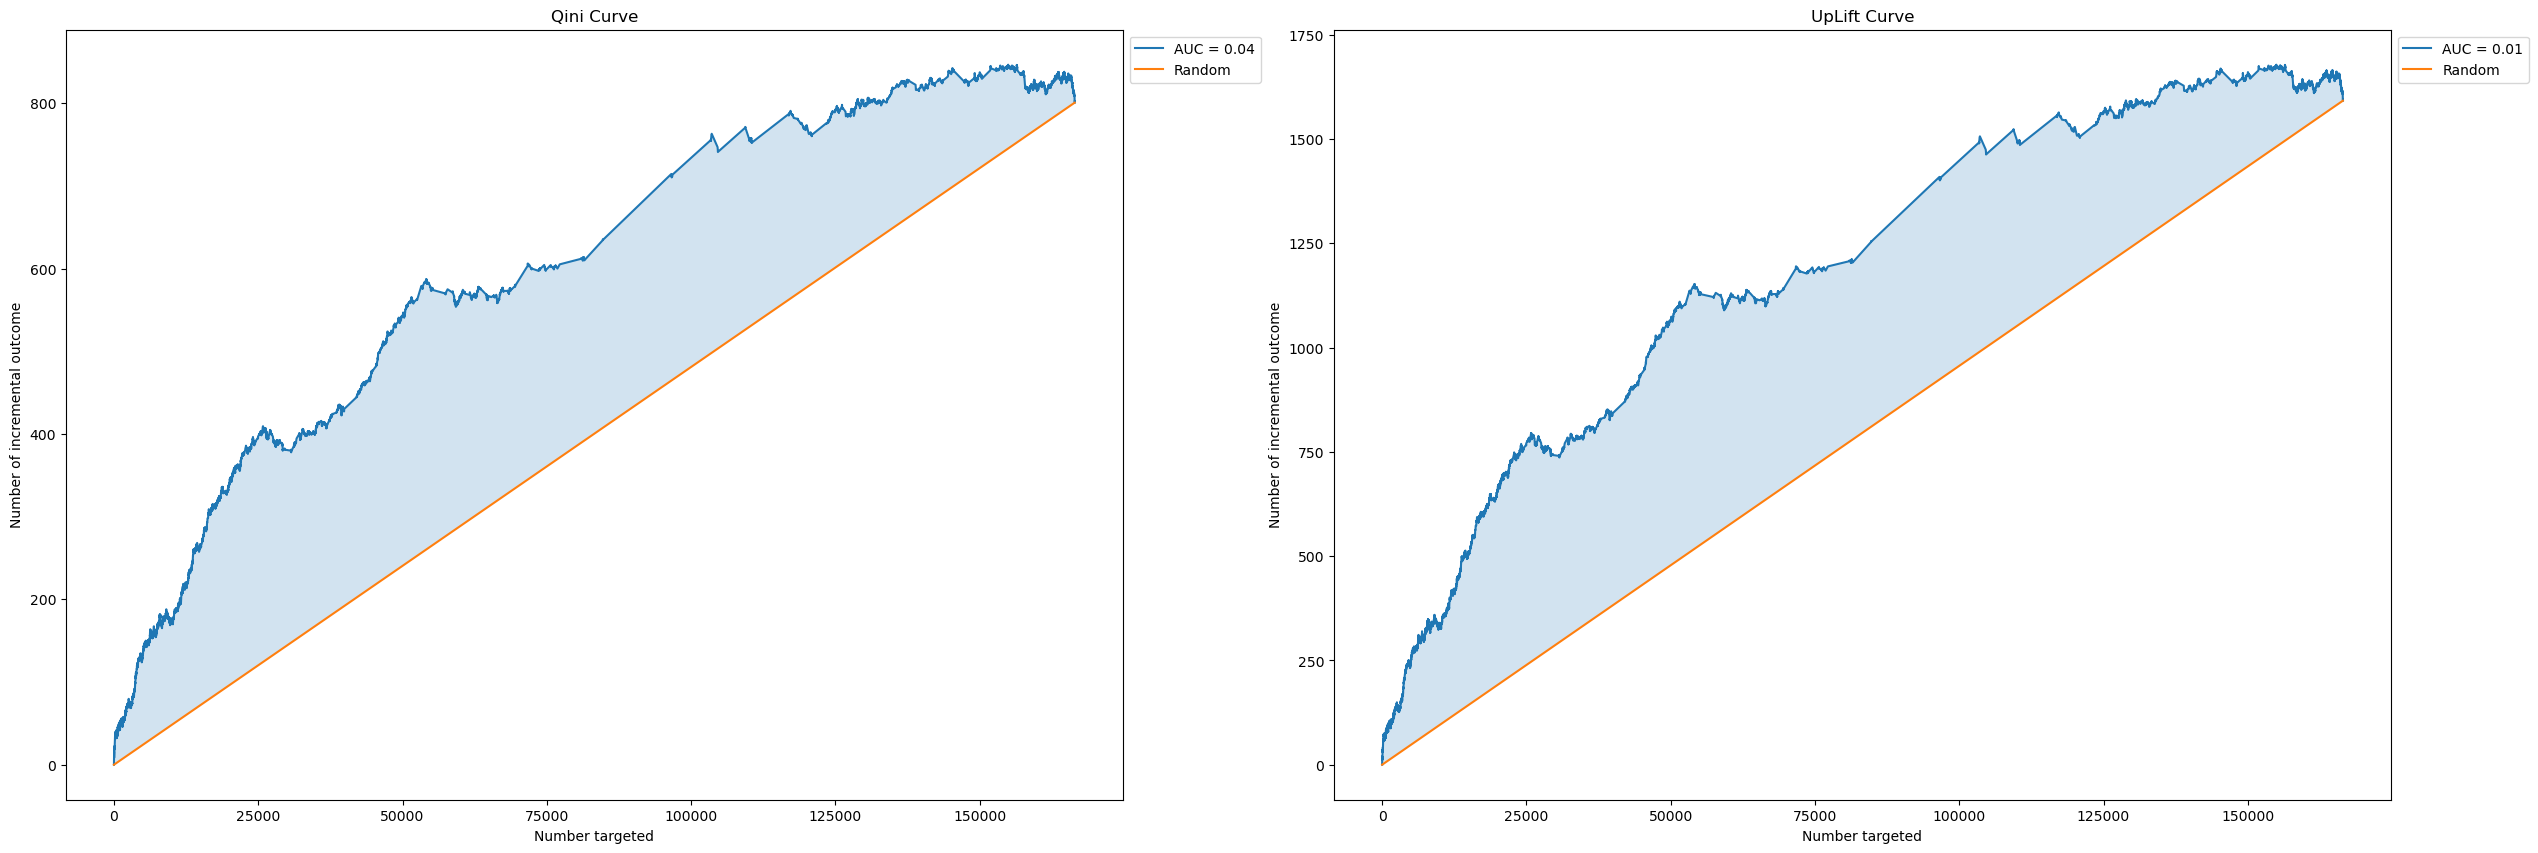

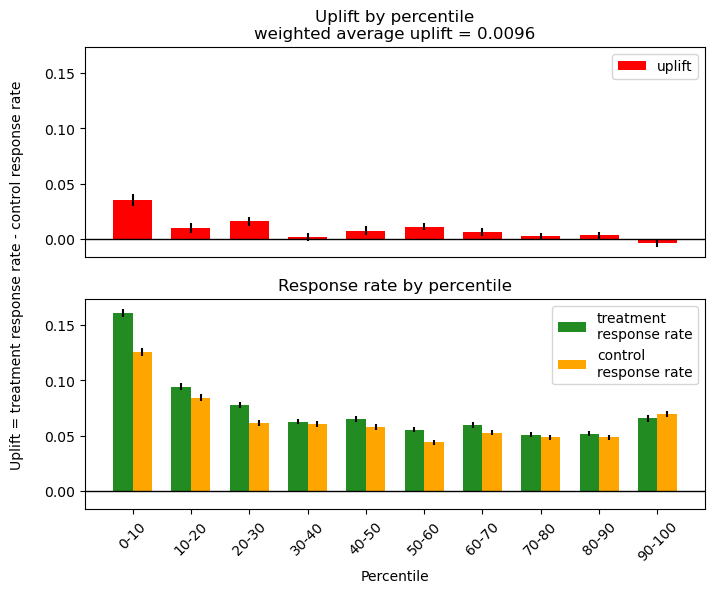

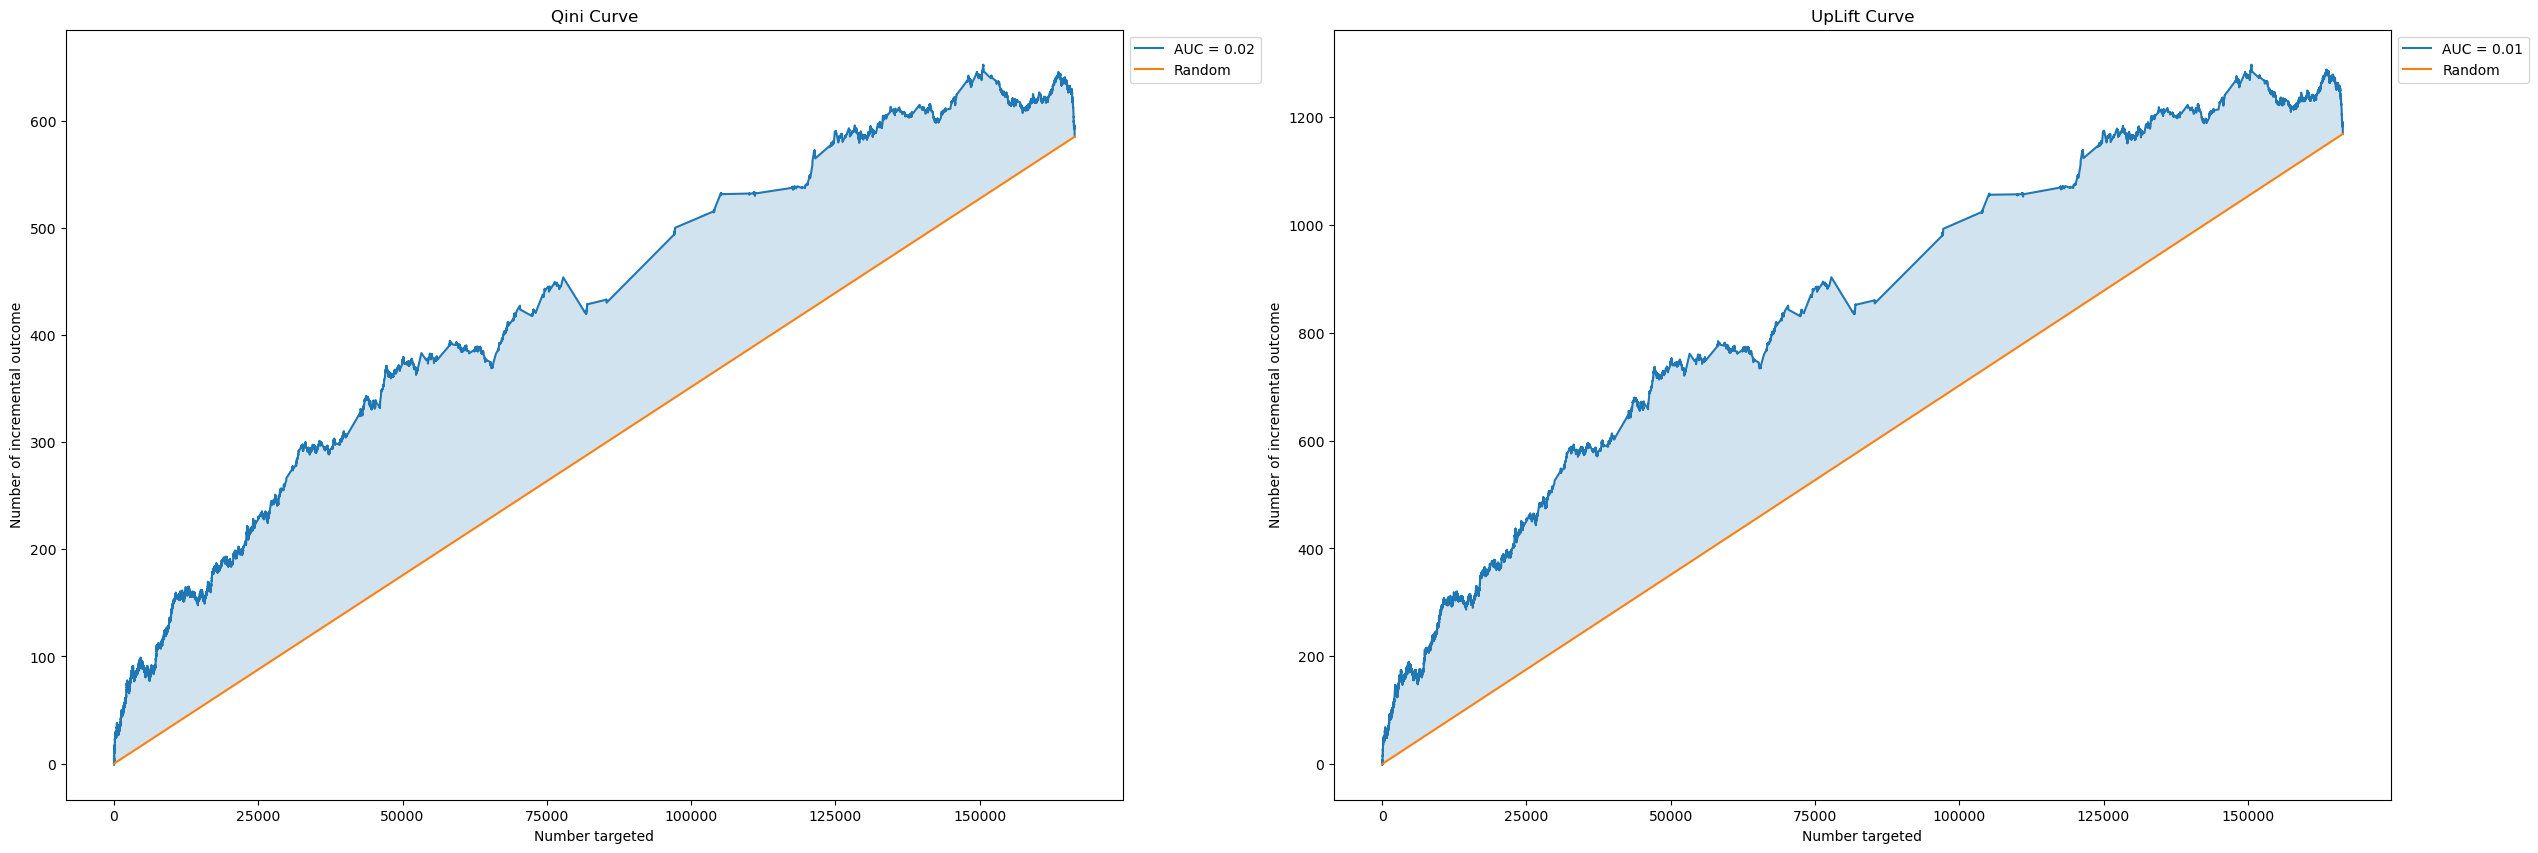

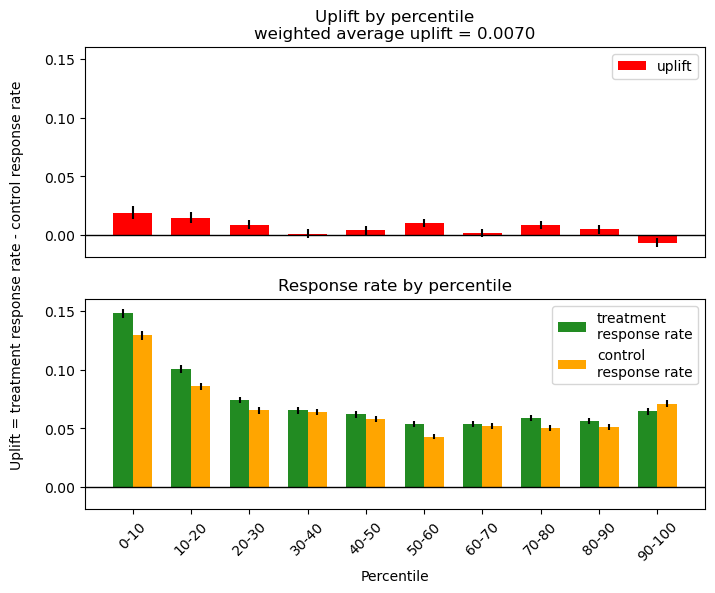

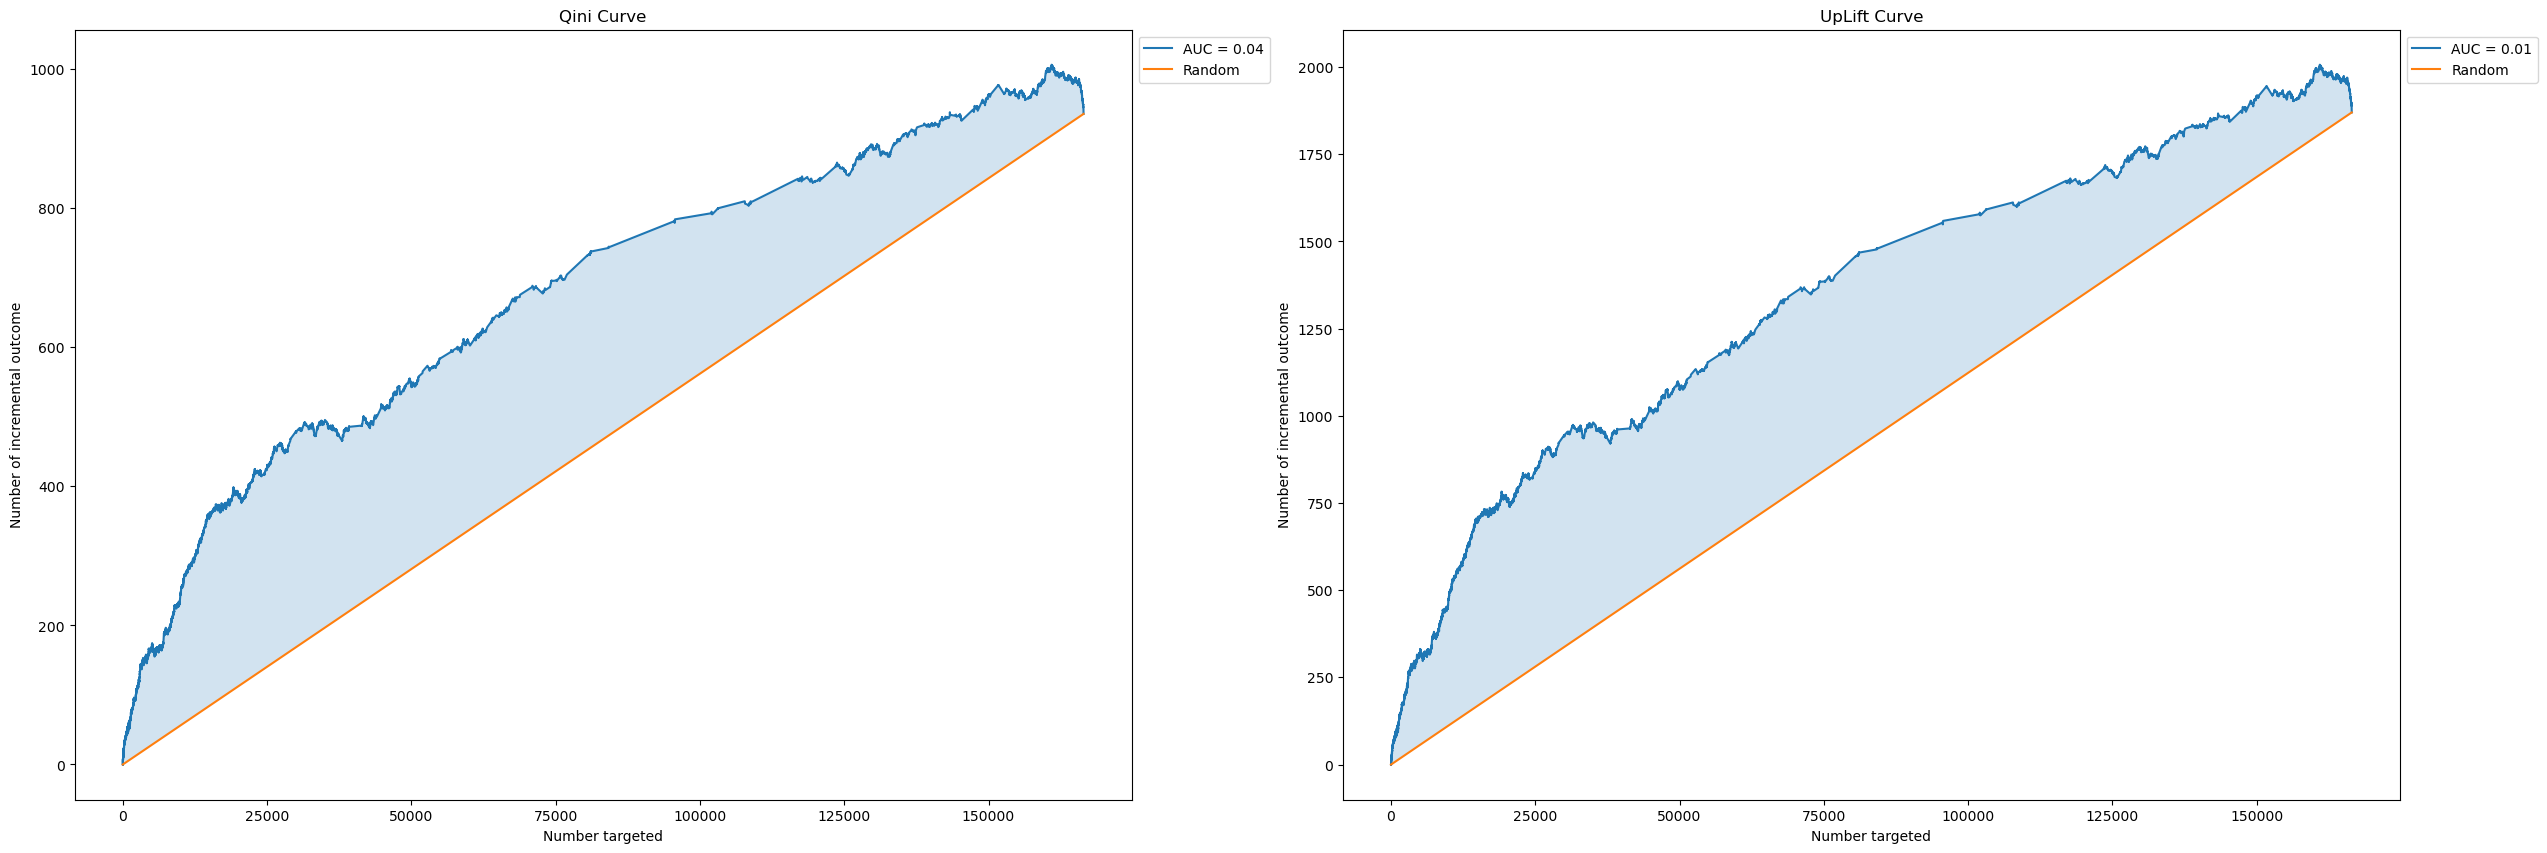

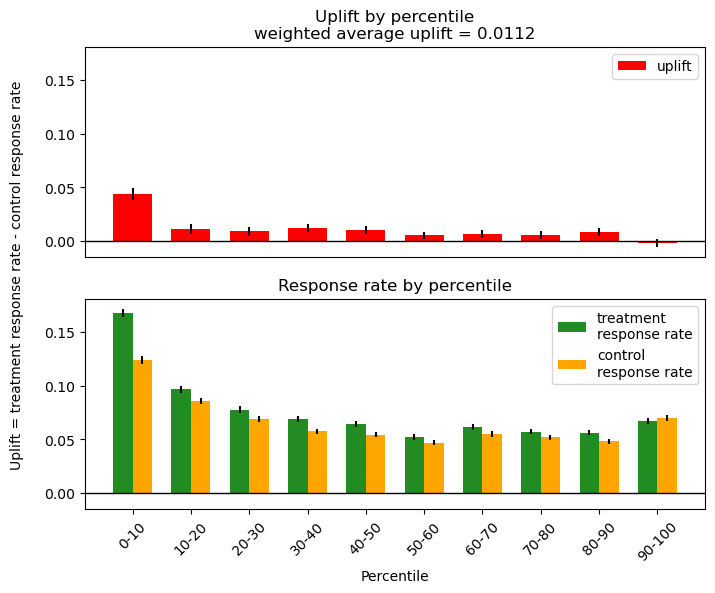

In [25]:
import copy
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      ctbst  = copy.deepcopy(automl.best_pipeline)
      ctbst.fit(X_train_, y_train_)
      y_pred = ctbst.predict(X_test_)
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% = {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')


# Применение библиотеки Scikit-Uplift в комбинации с CatBoost

In [26]:
from sklift.models import ClassTransformationReg
from sklearn.base import BaseEstimator

from sklearn.utils.multiclass import type_of_target
from sklearn.utils.validation import check_consistent_length

from sklift.utils import check_is_binary

In [27]:
import sklift
sklift.__version__

'0.5.1'

In [30]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


NewComer  lftm_type_NewComer  lftm_type_Regular  SEGMENT_N_1  \
7701018976         0                   1                  0            0   
7701018997         0                   1                  0            1   
7701019567         0                   1                  0            0   
7701019870         0                   1                  0            0   
7701020445         0                   1                  0            0   

            SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  SEGMENT_N_5  SEGMENT_N_6  \
7701018976            0            0            1            0            0   
7701018997            0            0            0            0            0   
7701019567            0            1            0            0            0   
7701019870            0            1            0            0            0   
7701020445            0            0            1            0            0   

            SEGMENT_N_8  SUB_EMAIL_Да  SUB_EMAIL_Нет  \
7701018976            0             0              1   
7701018997            0             0              1   
7701019567            0             1              0   
7701019870            0             0              1   
7701020445            0             1              0   

            Тип карты_Без возможности оплаты  \
7701018976                                 1   
7701018997                                 1   
7701019567                                 0   
7701019870                                 1   
7701020445                                 0   

            Тип карты_Как карточное платежное средство  \
7701018976                                           0   
7701018997                                           0   
7701019567                                           1   
7701019870                                           0   
7701020445                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7701018976                        0                          1  36.0   
7701018997                        0                          1  55.0   
7701019567                        1                          0  28.0   
7701019870                        0                          1  36.0   
7701020445                        1                          0  22.0   

            last_order_days    AMOUNT    ORDERS       AOV    LTV_1M  \
7701018976         2.042661 -0.394610 -0.326186 -0.308688 -0.394610   
7701018997        -0.381745 -0.507723 -0.326186 -0.516129 -0.507723   
7701019567         0.601122 -0.193753  0.359438 -0.378950 -0.193753   
7701019870         0.863220 -0.426720 -0.326186 -0.367575 -0.426720   
7701020445        -0.348983 -0.640295 -0.326186 -0.759258 -0.640295   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7701018976     -0.326186  -0.382164   0.000000         0.000000   
7701018997     -0.326186  -0.974353   0.000000         0.000000   
7701019567      0.359438   1.954967   1.881439        -0.028650   
7701019870     -0.326186  -0.382164   0.000000         0.000000   
7701020445     -0.326186   0.440000  -0.945282         1.055797   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7701018976       -0.300324        0.000000          -0.327790   
7701018997       -0.352820        0.000000          -0.945474   
7701019567       -0.186582       -0.357901           2.142946   
7701019870       -0.300324        0.000000          -0.327790   
7701020445       -0.422816        0.000000           0.598736   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7701018976           0.000000             0.0      -0.411228   
7701018997           0.000000             0.0      -0.514400   
7701019567           2.173032             0.0      -0.187688   
7701019870           0.000000             0.0      -0.411228   
7701020445          -1.077897             0.0      -0.651963   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS

target  treat
7701018976       0      1
7701018997       0      0
7701019567       0      1
7701019870       0      1
7701020445       0      0

[[0.       1.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.269954 0.017543 0.266453]
 ...
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]]
[ 0. -0.  0. ...  0. -0. -0.]
0.5010158242714119


Split 1; WAU = 0.007832964790919678; UpLift 30% = 0.01705224195456198


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 2; WAU = 0.009405154111598318; UpLift 30% = 0.017088927883819244


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 3; WAU = 0.009143054846603257; UpLift 30% = 0.02200289575721534


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 4; WAU = 0.0068205753192238615; UpLift 30% = 0.015493891652616804


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 5; WAU = 0.01103813217950361; UpLift 30% = 0.022150146298680284


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Mean WAU = 0.0088; Mean UpLift 30% = 0.0188


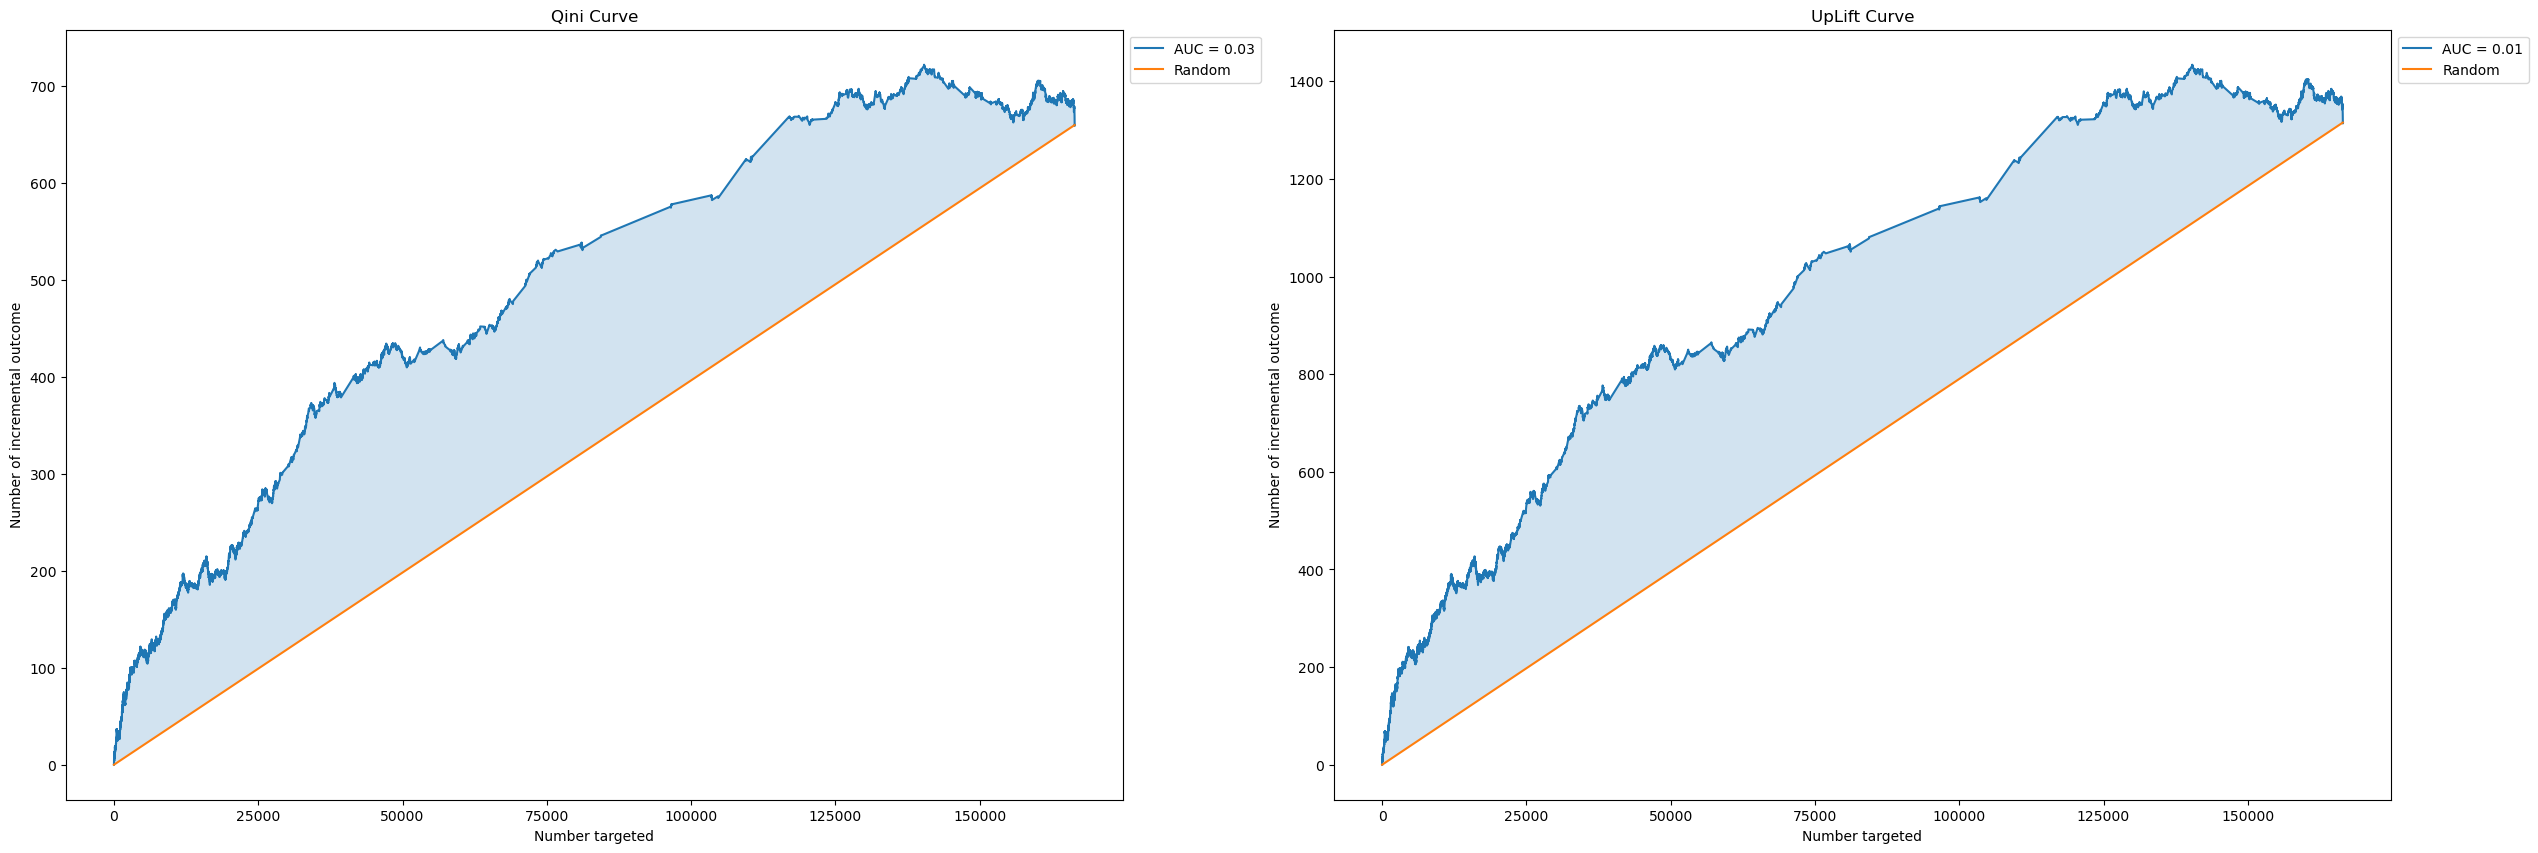

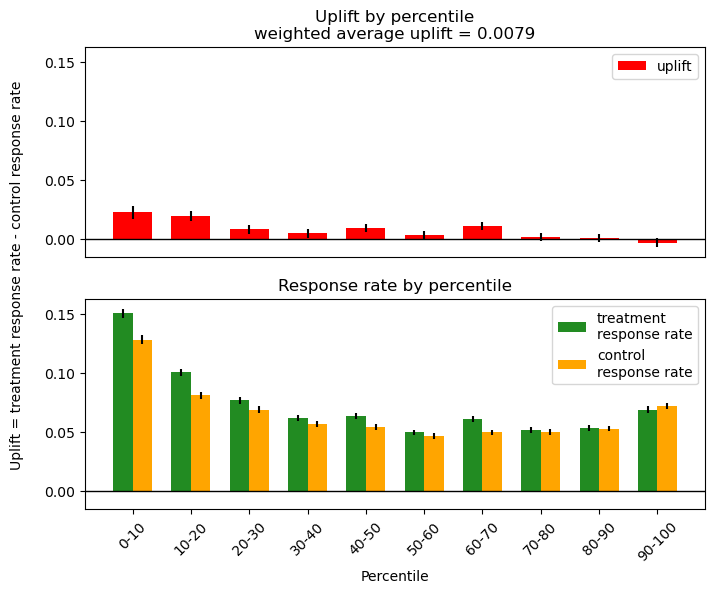

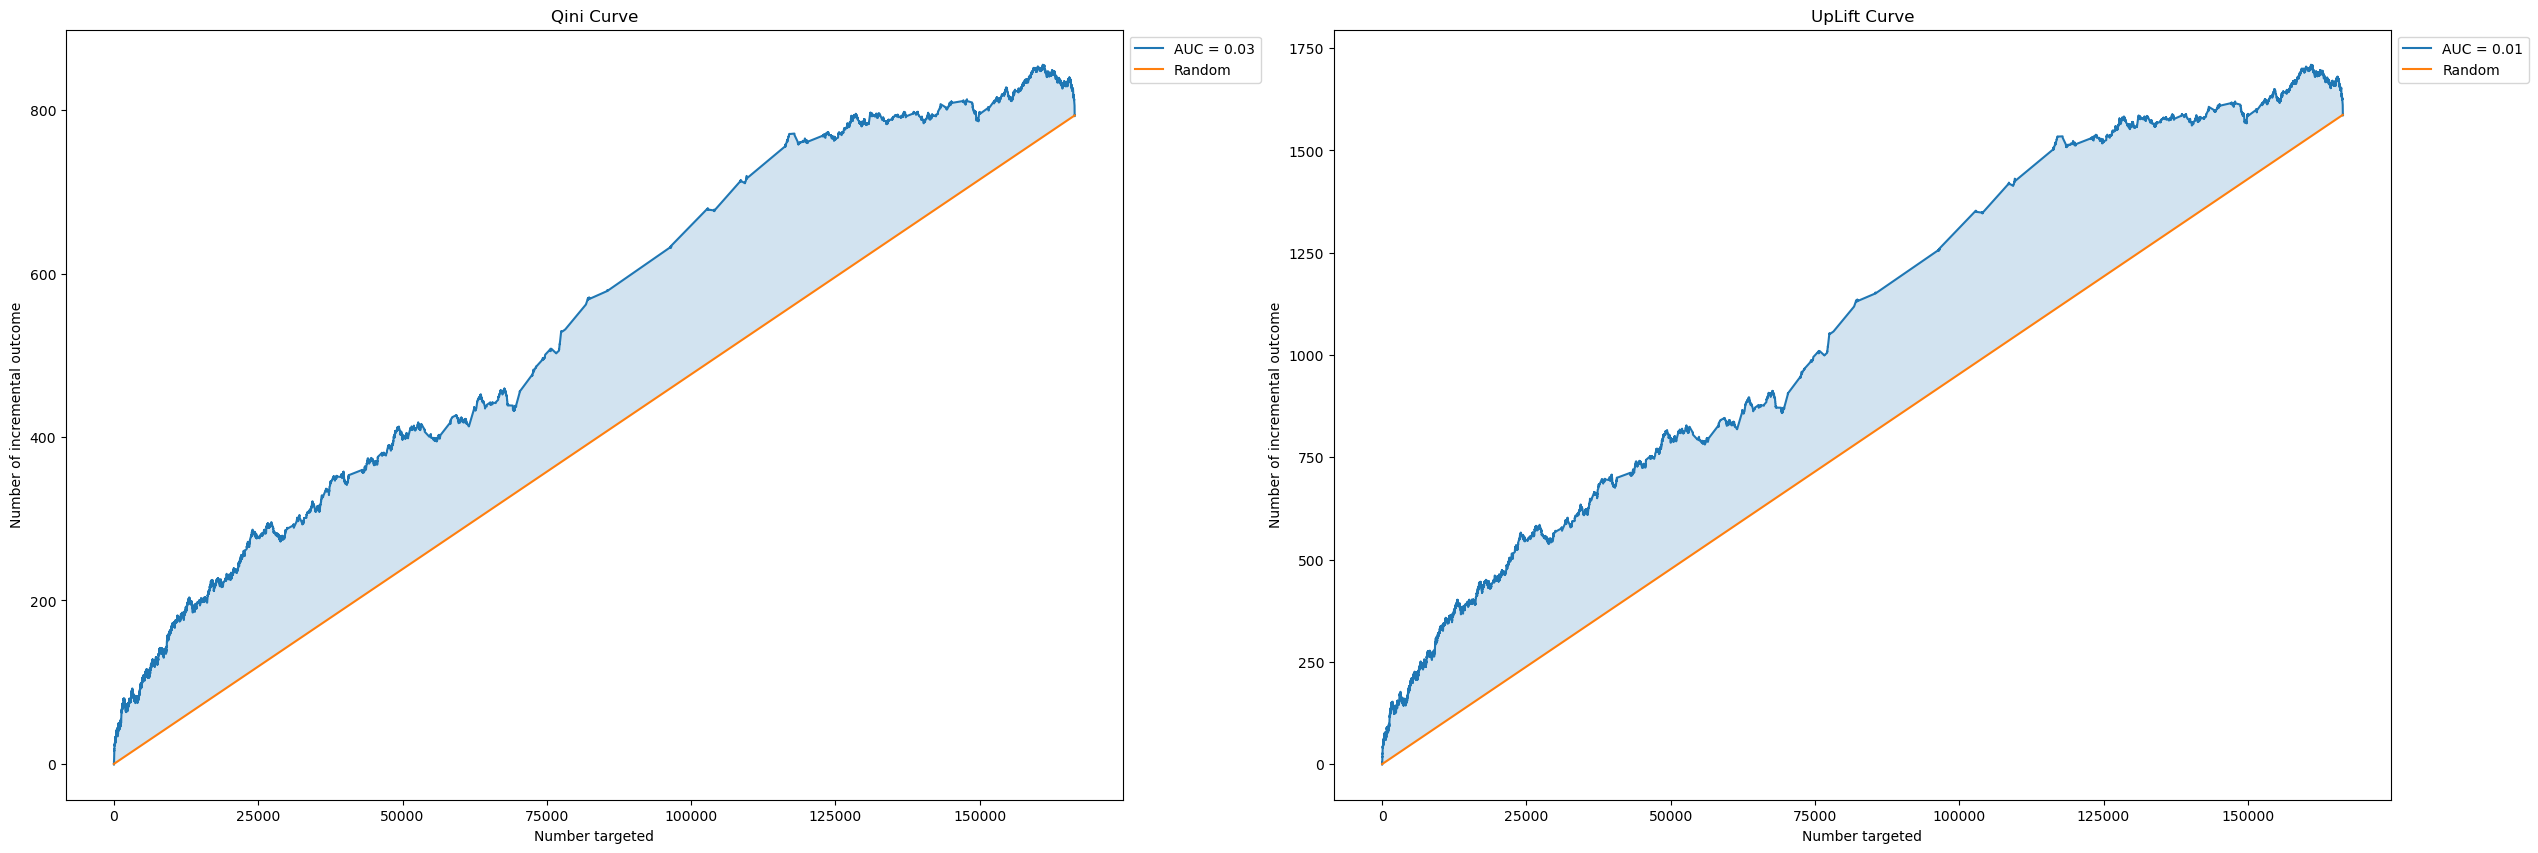

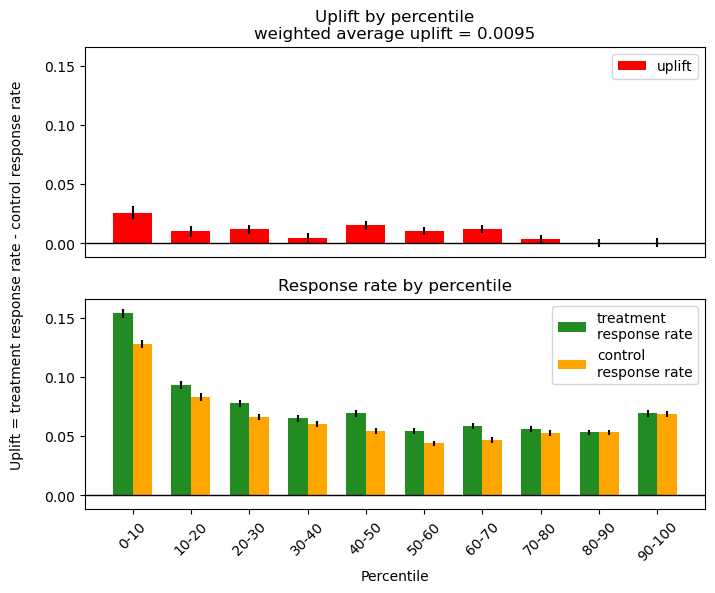

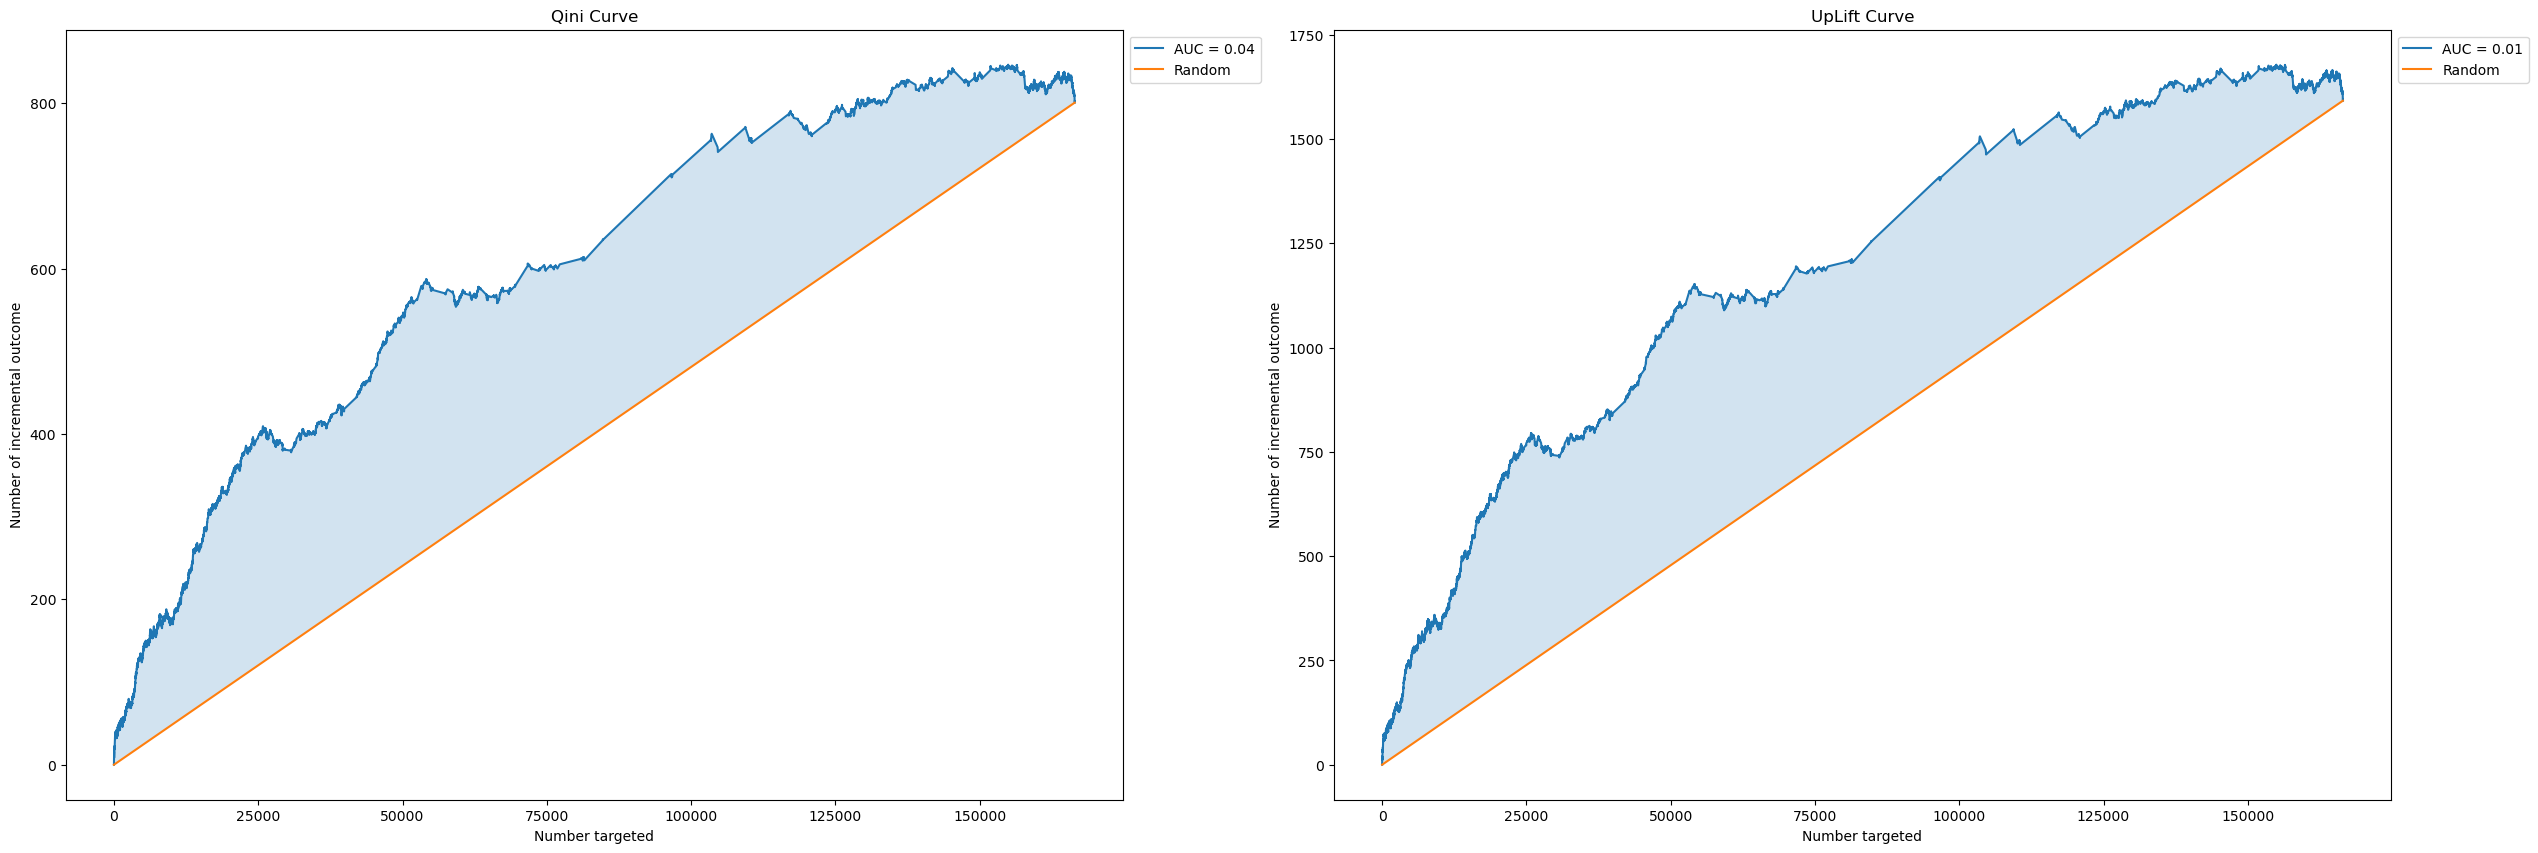

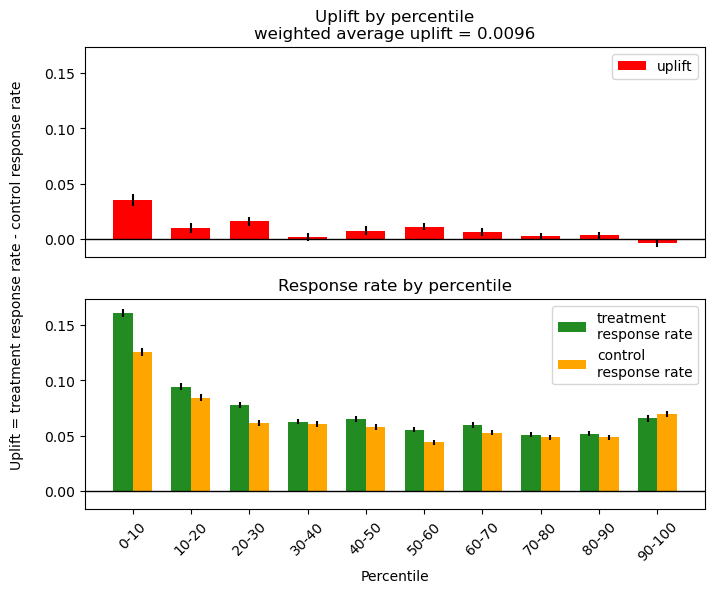

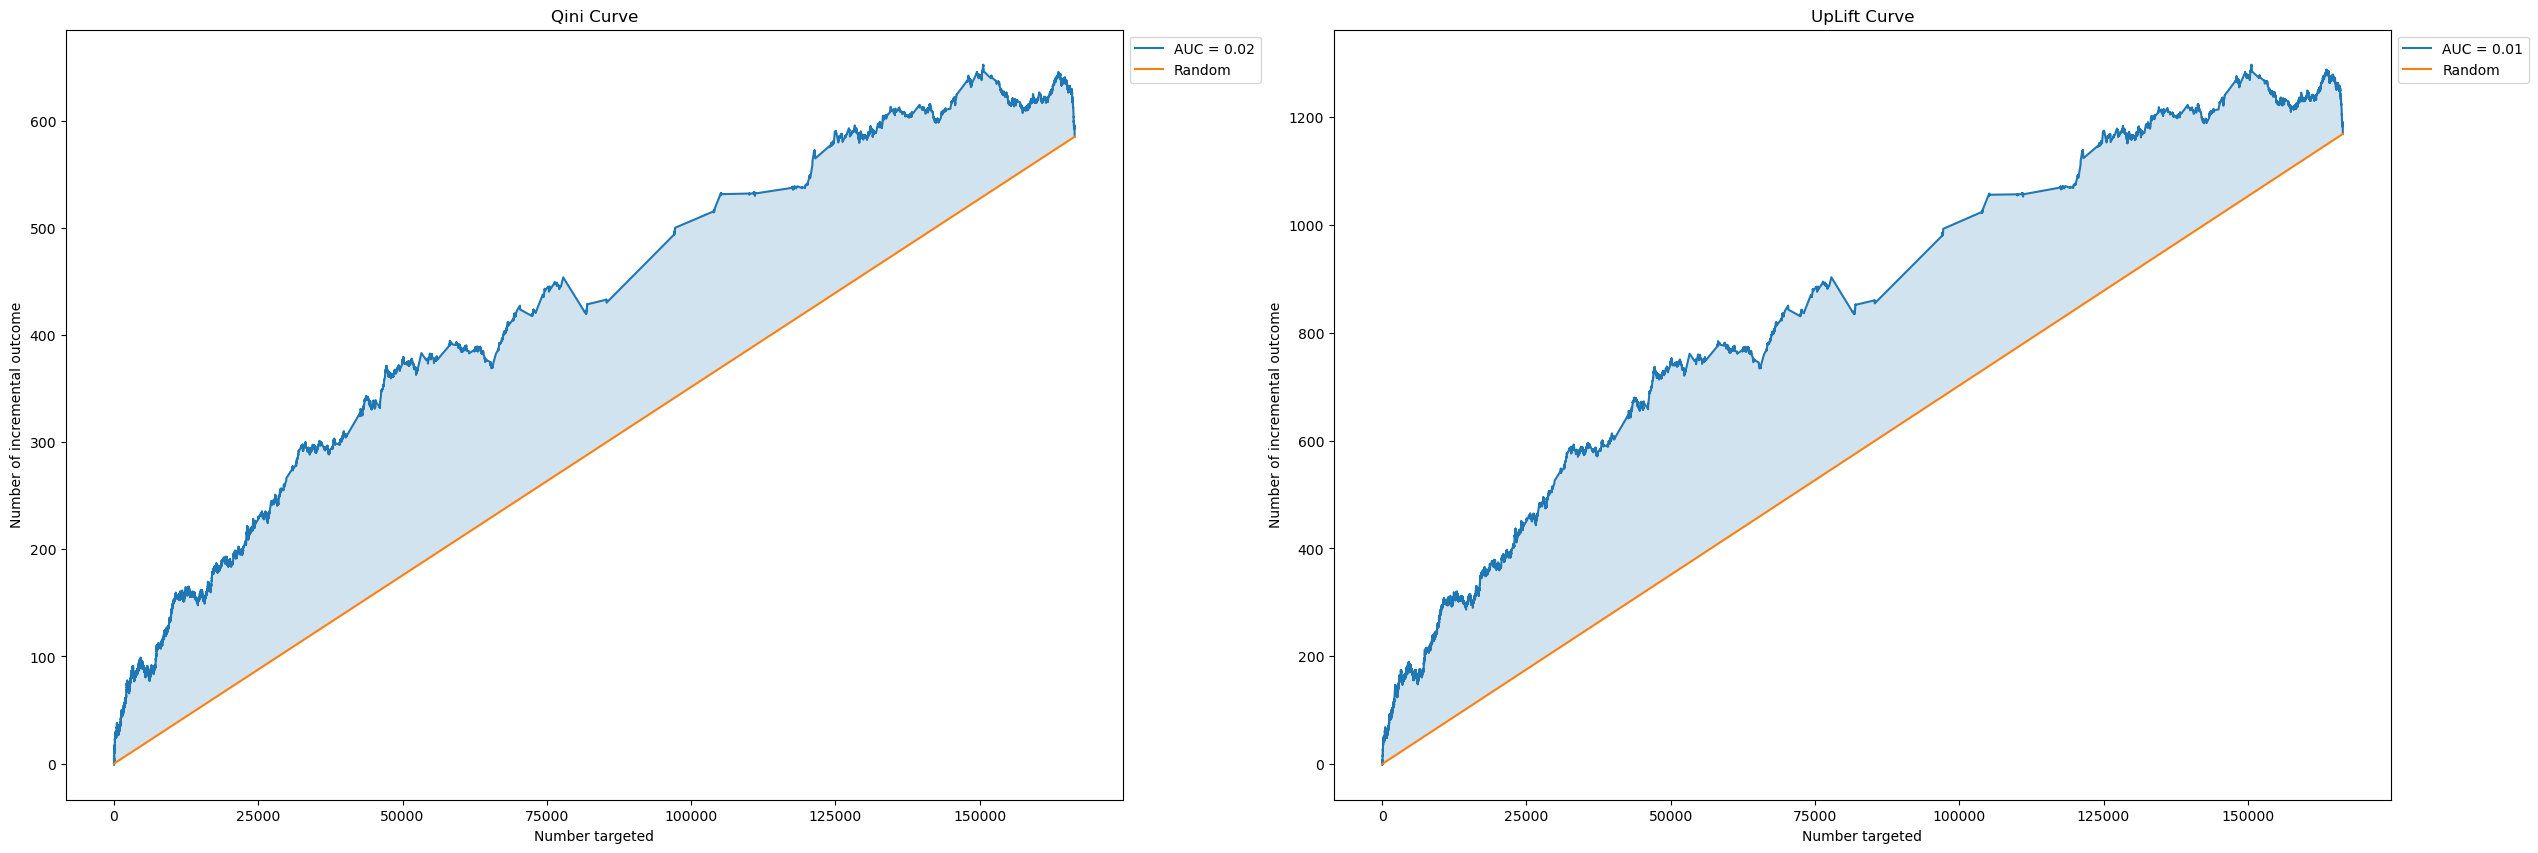

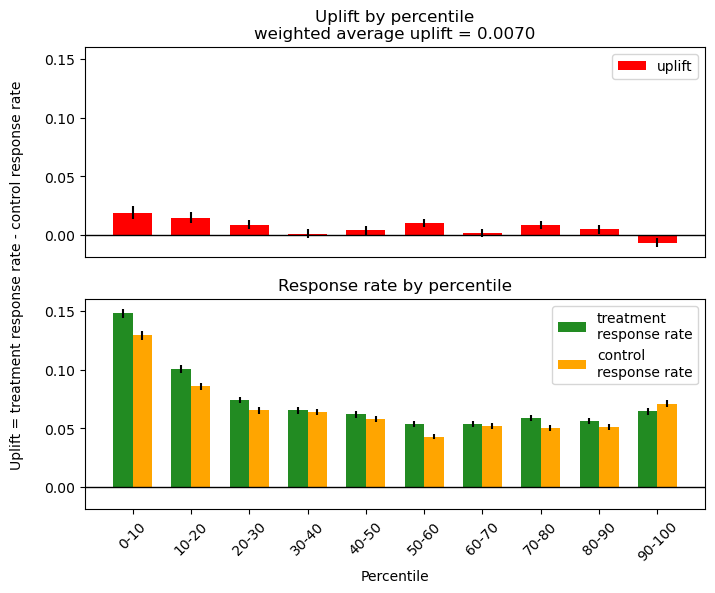

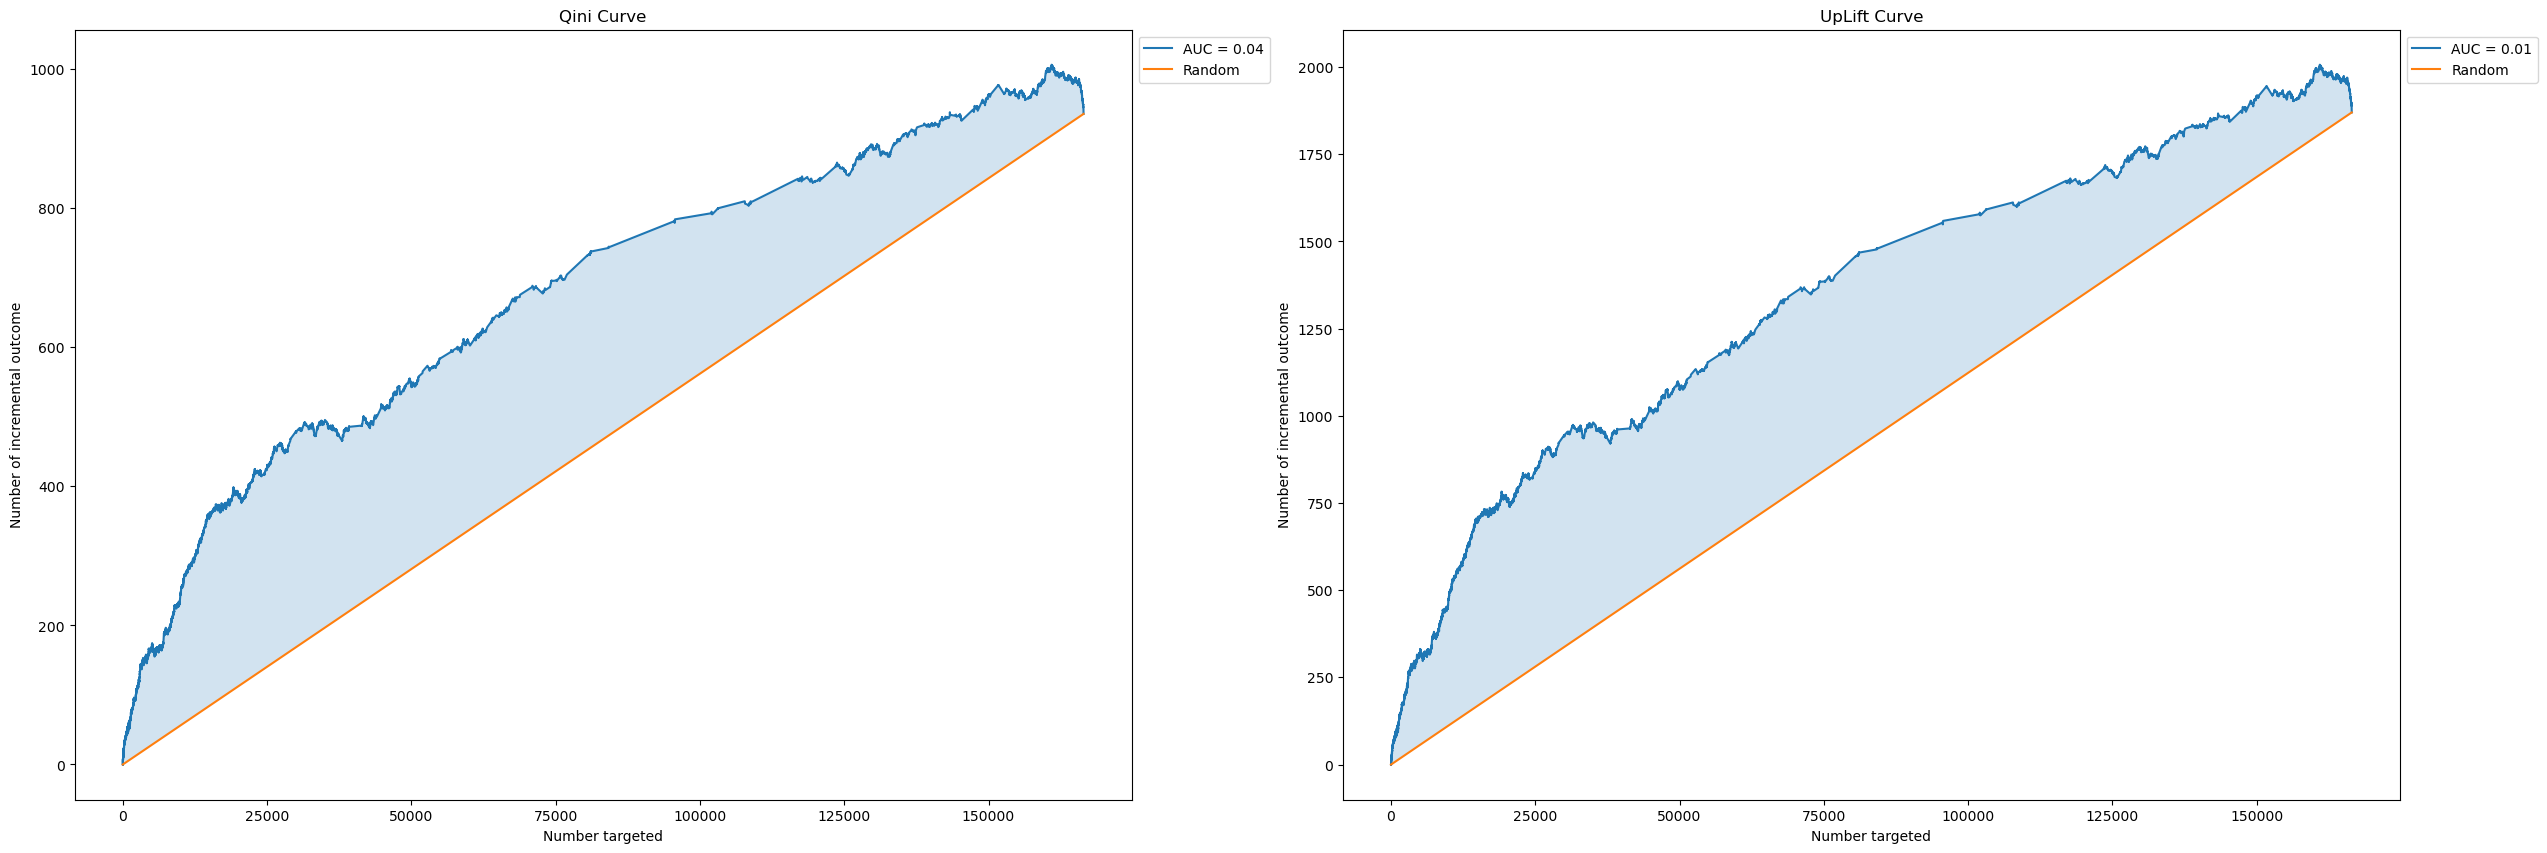

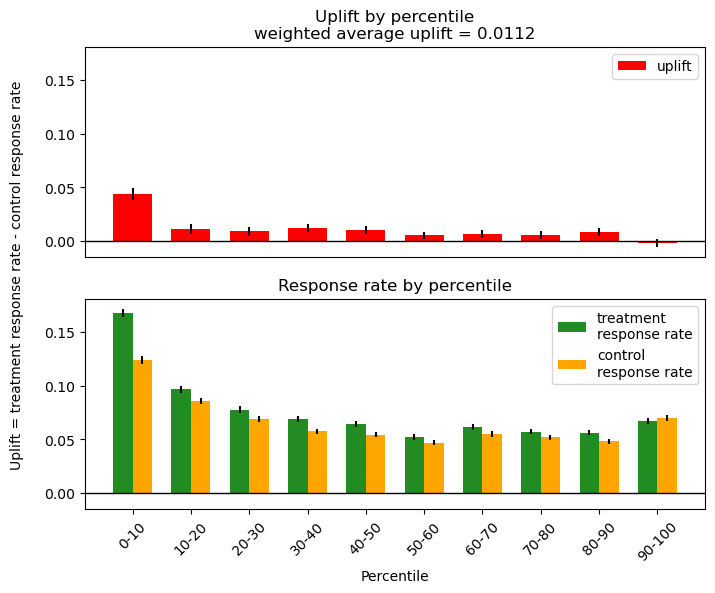

In [31]:
%matplotlib inline
import copy
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0


# grid = { 'max_depth':2,
#     'learning_rate': 0.2, 
#     'n_estimators': 100,}

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      ctbst  = copy.deepcopy(automl.best_pipeline)
      ctbst = ClassTransformationReg(estimator=ctbst, propensity_val=p)
      ctbst.fit(X = X_train_, y = targ[train_index], treatment= treat[train_index])
      y_pred = ctbst.predict(X_test_)
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% = {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')
